table flowReadings deleted


<IPython.core.display.Javascript object>


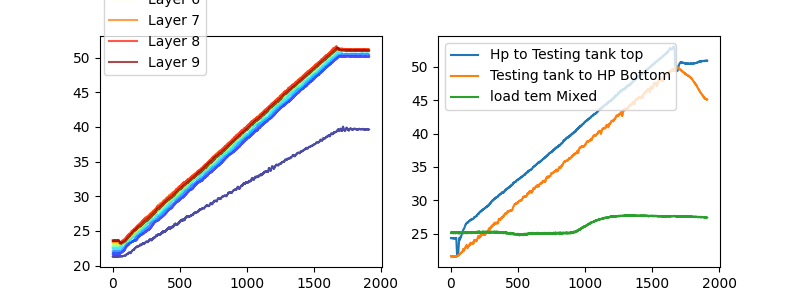

<IPython.core.display.Javascript object>


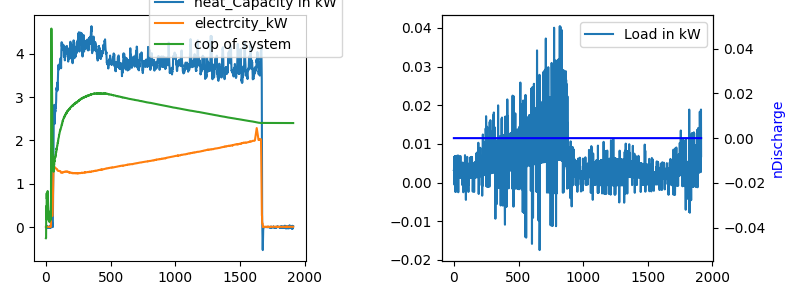

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((10795, datetime.datetime(2021, 3, 25, 13, 13, 1), 23.5021, 24.3475, 21.643, 22.4204, 22.5894, 24.1108, 25.1255, 20.5619, 22.0148, 22.6908, 22.488, 22.0148, 21.6768, 21.3051, 23.5698, 23.6712, 23.4345, 23.2655, 23.0288),)
electricity in khW is: 3.1021722222222224e-06
cop is: -0.25779217275943633
Load in kWh is: 1.767767559836204e-06
heat addition in kwh is: -7.997157174406357e-07
Index([0], dtype='object')
entropysum  is : 0    2954.104801
dtype: float64
whole kJ list is:           0
0 -0.002879
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((10797, datetime.datetime(2021, 3, 25, 13, 13, 4), 23.5021, 24.3475, 21.643, 22.4204, 22

RangeIndex(start=0, stop=10, step=1)
entropysum  is : 0    2773.463271
1    2755.413349
2    2720.796248
3    2804.311632
4    2827.614084
5    2827.220110
6    2845.663195
7    2838.824159
8    2743.625662
9    2763.992251
dtype: float64
whole kJ list is:           0
0 -0.002879
1 -0.004318
2  0.023864
3 -0.004372
4  0.026779
5 -0.004426
6  0.053561
7 -0.004372
8  0.026778
9 -0.004426
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((10813, datetime.datetime(2021, 3, 25, 13, 13, 32), 23.5021, 24.3475, 21.6093, 22.4204, 22.6908, 24.0432, 25.2269, 20.5281, 22.0148, 22.657, 22.4204, 21.981, 21.7106, 21.3389, 23.6036, 23.6712, 23.4007, 23.2655, 23.1302),)
electricity in khW is: 5.099633333333334e-05
cop is: 0.7083914718523917
Load in kWh is: 2.9586043735461532e-05
heat addition in kwh is: 3.61253676290751

RangeIndex(start=0, stop=18, step=1)
entropysum  is : 0     2792.062579
1     2773.891610
2     2739.042362
3     2823.117813
4     2846.576536
5     2846.179920
6     2864.746688
7     2857.861788
8     2762.024874
9     2782.528044
10    2786.118361
11    2841.133244
12    2762.163473
13    2840.203348
14    2823.539465
15    2791.852291
16    2747.422352
17    2767.497356
dtype: float64
whole kJ list is:            0
0  -0.002879
1  -0.004318
2   0.023864
3  -0.004372
4   0.026779
5  -0.004426
6   0.053561
7  -0.004372
8   0.026778
9  -0.004426
10  0.023864
11  0.029831
12 -0.004318
13  0.053559
14 -0.016505
15 -0.005830
16 -0.025985
17 -0.005758
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((10829, datetime.datetime(2021, 3, 25, 13, 13, 59), 23.4683, 24.3475, 21.6093, 22.4204, 22.657, 24.0093, 

RangeIndex(start=0, stop=25, step=1)
entropysum  is : 0     2881.826872
1     2863.071710
2     2827.102065
3     2913.880526
4     2938.093443
5     2937.684075
6     2956.847761
7     2949.741513
8     2850.823460
9     2871.985804
10    2875.691548
11    2932.475149
12    2850.966515
13    2931.515357
14    2914.315734
15    2881.609823
16    2835.751470
17    2856.471881
18    2886.862979
19    2799.892597
20    2869.632563
21    2961.953518
22    2869.263404
23    2845.529000
24    2901.890145
dtype: float64
whole kJ list is:            0
0  -0.002879
1  -0.004318
2   0.023864
3  -0.004372
4   0.026779
5  -0.004426
6   0.053561
7  -0.004372
8   0.026778
9  -0.004426
10  0.023864
11  0.029831
12 -0.004318
13  0.053559
14 -0.016505
15 -0.005830
16 -0.025985
17 -0.005758
18 -0.004372
19 -0.035085
20 -0.004372
21 -0.049516
22  0.023570
23  0.017898
24 -0.005902
________________________________________________________________
flow rates load is =  0.6320192876979889 0.00396449183099980

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238
result is ((10854, datetime.datetime(2021, 3, 25, 13, 14, 42), 23.5021, 24.3813, 21.6093, 22.4542, 22.5894, 24.0432, 25.0916, 20.5619, 21.981, 22.657, 22.4542, 21.981, 21.7106, 21.3389, 23.5698, 23.6036, 23.4683, 23.2655, 23.2317),)
electricity in khW is: 0.00016268305833333328
cop is: 0.2250317895987389
Load in kWh is: 7.332932004372625e-05
heat addition in kwh is: 3.660885975414602e-05
RangeIndex(start=0, stop=31, step=1)
entropysum  is : 0     2877.123497
1     2858.398945
2     2822.488005
3     2909.124838
4     2933.298237
5     2932.889537
6     2952.021947
7     2944.927296
8     2846.170685
9     2867.298491
10    2870.998187
11    2927.689113
12    2846.313507
13    2926.730887
14    2909.559335
15    2876.906803
16    2831.123294
17    2851.809888
18    2882.151385
19    2795.322945
20    2864.949090
21    2957.11937

flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((10864, datetime.datetime(2021, 3, 25, 13, 14, 59), 23.5021, 24.3813, 21.643, 22.4204, 22.5894, 24.1108, 25.0916, 20.5619, 22.0148, 22.7246, 22.5218, 21.981, 21.7106, 21.3389, 23.6036, 23.705, 23.4007, 23.2317, 23.1979),)
electricity in khW is: 0.0001836527805555555
cop is: 0.31669426771220577
Load in kWh is: 9.039280511359802e-05
heat addition in kwh is: 5.816178285135207e-05
RangeIndex(start=0, stop=36, step=1)
entropysum  is : 0     2882.236778
1     2863.478949
2     2827.504187
3     2914.294992
4     2938.511352
5     2938.101927
6     2957.268338
7     2950.161079
8     2851.228956
9     2872.394310
10    2876.100582
11    2932.892260
12    2851.372032
13    2931.932332
14    2914.730261
15    2882.019699
16    2836.154823
17    2856.878181
18    2887.273602
19    2800.290849
20    2870.040735
21    2962.37482

flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.1000335703604236 0.006890282307299865 549.8830530853193
result is ((10873, datetime.datetime(2021, 3, 25, 13, 15, 15), 23.4683, 24.1784, 21.6093, 22.3528, 22.657, 24.1108, 25.1593, 20.5957, 22.0148, 22.657, 22.5218, 22.0148, 21.7444, 21.3389, 23.5698, 23.6712, 23.5359, 23.2655, 22.9612),)
electricity in khW is: 0.0006531850083333333
cop is: 3.1264215832303592
Load in kWh is: 0.00010106502158129683
heat addition in kwh is: 0.0020421317078958352
RangeIndex(start=0, stop=41, step=1)
entropysum  is : 0     2895.988171
1     2877.140846
2     2840.994446
3     2928.199337
4     2952.531236
5     2952.119857
6     2971.377713
7     2964.236544
8     2864.832408
9     2886.098744
10    2889.822698
11    2946.885334
12    2864.976167
13    2945.920826
14    2928.636683
15    2895.770055
16    2849.686355
17    2870.508586
18    2901.049026
19    2813.651271
20    2883.733939
21    2976.508560

RangeIndex(start=0, stop=45, step=1)
entropysum  is : 0     2817.218826
1     2798.884139
2     2763.720902
3     2848.553866
4     2872.223950
5     2871.823760
6     2890.557813
7     2883.610880
8     2786.910484
9     2807.598387
10    2811.221051
11    2866.731613
12    2787.050332
13    2865.793340
14    2848.979316
15    2817.006644
16    2772.176395
17    2792.432272
18    2822.142029
19    2737.121446
20    2805.297903
21    2895.549103
22    2804.937021
23    2781.734721
24    2836.832298
25    2769.568482
26    2884.145174
27    2737.481858
28    2828.295467
29    2861.092955
30    2848.957679
31    2749.240753
32    2798.734241
33    2798.300620
34    2730.861061
35    2825.150907
36    2799.840780
37    2895.775524
38    2831.388583
39    2793.021859
40    2512.435309
41    1654.040029
42     294.029912
43    -666.987987
44   -1206.782003
dtype: float64
whole kJ list is:            0
0  -0.002879
1  -0.004318
2   0.023864
3  -0.004372
4   0.026779
5  -0.004426
6   0.053561

RangeIndex(start=0, stop=49, step=1)
entropysum  is : 0     2771.768501
1     2753.729608
2     2719.133661
3     2802.598011
4     2825.886224
5     2825.492491
6     2843.924306
7     2837.089449
8     2741.949124
9     2762.303268
10    2765.867488
11    2820.482496
12    2742.086716
13    2819.559359
14    2803.016597
15    2771.559741
16    2727.452741
17    2747.381830
18    2776.612277
19    2692.963335
20    2760.039898
21    2848.835072
22    2759.684838
23    2736.856863
24    2791.065548
25    2724.886902
26    2837.615123
27    2693.317933
28    2782.666442
29    2814.934806
30    2802.995309
31    2704.887121
32    2753.582128
33    2753.155503
34    2686.803949
35    2779.572613
36    2754.670815
37    2849.057840
38    2785.709656
39    2747.961904
40    2471.902071
41    1627.355322
42     289.286313
43    -656.227438
44   -1187.312932
45   -1491.683647
46   -1539.243674
47   -1630.121169
48   -1691.649984
dtype: float64
whole kJ list is:            0
0  -0.002879
1  -0

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4660447401348917 0.00918286714772873 982.1296710440471
result is ((10898, datetime.datetime(2021, 3, 25, 13, 15, 58), 23.5021, 21.7444, 21.7444, 21.7782, 22.657, 24.077, 25.2269, 21.643, 21.981, 22.7584, 22.4542, 22.0486, 21.7106, 21.3389, 23.3669, 23.4007, 23.1979, 23.2317, 23.0626),)
electricity in khW is: 0.003933912508333333
cop is: 1.8139118373080048
Load in kWh is: 0.00014192540194194733
heat addition in kwh is: 0.007135770465799858
RangeIndex(start=0, stop=53, step=1)
entropysum  is : 0     2829.489980
1     2811.075431
2     2775.759031
3     2860.961508
4     2884.734693
5     2884.332760
6     2903.148414
7     2896.171222
8     2799.049621
9     2819.827636
10    2823.466080
11    2879.218433
12    2799.190079
13    2878.276073
14    2861.388811
15    2829.276873
16    2784.251354
17    2804.595462
18    2834.434627
19    2749.043714
20    2817.517132
21    2908.161445
22 

flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4640446790978727 0.009170339361715458 979.7676676672235
result is ((10907, datetime.datetime(2021, 3, 25, 13, 16, 13), 23.5359, 22.6908, 21.7782, 21.6768, 22.6908, 24.1446, 25.1931, 20.8321, 22.0148, 22.8598, 22.5556, 22.0824, 21.7782, 21.3051, 23.2317, 23.2993, 23.1302, 23.2317, 23.0964),)
electricity in khW is: 0.006839173341666667
cop is: 1.3321691617055667
Load in kWh is: 0.0001514633744393846
heat addition in kwh is: 0.009110935817327142
RangeIndex(start=0, stop=57, step=1)
entropysum  is : 0     2869.700862
1     2851.024617
2     2815.206323
3     2901.619643
4     2925.730677
5     2925.323032
6     2944.406082
7     2937.329735
8     2838.827905
9     2859.901203
10    2863.591354
11    2920.136024
12    2838.970358
13    2919.180271
14    2902.053019
15    2869.484726
16    2823.819334
17    2844.452559
18    2874.715779
19    2788.111346
20    2857.557863
21    2949.490355


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4660447401348917 0.00918286714772873 982.1296710440471
result is ((10915, datetime.datetime(2021, 3, 25, 13, 16, 27), 23.5021, 23.9755, 21.8796, 21.5755, 22.6232, 24.0093, 25.0578, 19.785, 21.981, 22.9612, 22.5556, 22.0824, 21.7782, 21.3389, 23.164, 23.2993, 23.164, 23.164, 23.0964),)
electricity in khW is: 0.01226091778611111
cop is: 1.3278791417258031
Load in kWh is: 0.00016358205148947374
heat addition in kwh is: 0.016281016986591856
RangeIndex(start=0, stop=61, step=1)
entropysum  is : 0     2928.331333
1     2909.273516
2     2872.723423
3     2960.902242
4     2985.505886
         ...     
56      81.895451
57     459.938079
58    1040.605575
59    1619.076884
60    2376.878328
Length: 61, dtype: float64
whole kJ list is:            0
0  -0.002879
1  -0.004318
2   0.023864
3  -0.004372
4   0.026779
..       ...
56  3.078626
57  3.781084
58  6.522018
59  6.058756
60  9.450434

[

RangeIndex(start=0, stop=68, step=1)
entropysum  is : 0     2829.926764
1     2811.509372
2     2776.187520
3     2861.403150
4     2885.180005
         ...     
63    2894.239339
64    2612.807795
65    2354.421871
66    2315.740841
67    2303.671947
Length: 68, dtype: float64
whole kJ list is:             0
0   -0.002879
1   -0.004318
2    0.023864
3   -0.004372
4    0.026779
..        ...
63   2.820160
64  10.518167
65   7.413202
66   9.602842
67   7.150502

[68 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.460044557023835 0.009145283789688912 975.0436609135761
result is ((10930, datetime.datetime(2021, 3, 25, 13, 16, 53), 23.5021, 24.2122, 22.0486, 21.5079, 22.5894, 24.1108, 25.1593, 19.9201, 21.981, 23.0626, 22.826, 22.1838, 21.8796, 21.3389, 23.2655, 23.4345, 23.5021, 23.2317, 23.3669),)
electricity in khW is: 0.022275706675
cop is: 1.5608939

flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4660447401348917 0.00918286714772873 982.1296710440471
result is ((10943, datetime.datetime(2021, 3, 25, 13, 17, 15), 23.5359, 24.6181, 22.15, 21.4403, 22.5894, 24.077, 25.2269, 19.785, 22.0148, 23.164, 23.0626, 22.319, 21.981, 21.3727, 23.3331, 23.5359, 23.6036, 23.3669, 23.4345),)
electricity in khW is: 0.030620623341666663
cop is: 1.6704678542487226
Load in kWh is: 0.00020011424900250488
heat addition in kwh is: 0.05115076696931226
RangeIndex(start=0, stop=76, step=1)
entropysum  is : 0     2861.445862
1     2842.823342
2     2807.108083
3     2893.272825
4     2917.314502
         ...     
71    2850.886317
72    2773.813253
73    2773.273283
74    2924.350003
75    2944.732484
Length: 76, dtype: float64
whole kJ list is:             0
0   -0.002879
1   -0.004318
2    0.023864
3   -0.004372
4    0.026779
..        ...
71   5.411714
72   8.002894
73   5.335511
74   8.346515
75  1

RangeIndex(start=0, stop=83, step=1)
entropysum  is : 0     2977.768672
1     2958.389114
2     2921.221967
3     3010.889457
4     3035.908470
         ...     
78    3270.947730
79    3361.943161
80    3548.847080
81    3595.277579
82    3721.582958
Length: 83, dtype: float64
whole kJ list is:             0
0   -0.002879
1   -0.004318
2    0.023864
3   -0.004372
4    0.026779
..        ...
78   8.575460
79  11.738209
80   9.305733
81  15.551935
82  12.868088

[83 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4660447401348917 0.00918286714772873 982.1296710440471
result is ((10959, datetime.datetime(2021, 3, 25, 13, 17, 42), 23.5021, 25.0916, 22.2852, 21.4065, 22.6232, 24.1108, 25.1593, 19.5486, 21.981, 23.1979, 23.1979, 22.5556, 22.15, 21.4065, 23.4007, 23.7388, 23.6036, 23.4345, 23.3331),)
electricity in khW is: 0.041110053897222214
cop is: 1.7

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4640446790978727 0.009170339361715458 979.7676676672235
result is ((10974, datetime.datetime(2021, 3, 25, 13, 18, 8), 23.5021, 25.5314, 22.7246, 21.3389, 22.5894, 24.0432, 25.1931, 19.346, 21.9472, 23.2317, 23.4007, 22.7246, 22.2852, 21.4403, 23.5021, 23.8403, 23.8064, 23.6374, 23.5021),)
electricity in khW is: 0.04994874834166666
cop is: 1.9409468523159994
Load in kWh is: 0.000244717919448358
heat addition in kwh is: 0.0969478658708819
RangeIndex(start=0, stop=91, step=1)
entropysum  is : 0     2918.369134
1     2899.376152
2     2862.950403
3     2950.829237
4     2975.349179
         ...     
86    3804.486077
87    3891.531322
88    4077.375593
89    4010.641135
90    4121.674048
Length: 91, dtype: float64
whole kJ list is:             0
0   -0.002879
1   -0.004318
2    0.023864
3   -0.004372
4    0.026779
..        ...
86  13.142671
87   9.948454
88  10.014692
89  12.625002
90  

RangeIndex(start=0, stop=98, step=1)
entropysum  is : 0     2866.079071
1     2847.426398
2     2811.653309
3     2897.957568
4     2922.038173
         ...     
93    4185.548558
94    4155.216410
95    4148.838808
96    4131.644586
97    4150.097692
Length: 98, dtype: float64
whole kJ list is:             0
0   -0.002879
1   -0.004318
2    0.023864
3   -0.004372
4    0.026779
..        ...
93  10.609711
94   7.166395
95  18.297562
96  14.978098
97  11.234097

[98 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4640446790978727 0.009170339361715458 979.7676676672235
result is ((10990, datetime.datetime(2021, 3, 25, 13, 18, 35), 23.4683, 25.8021, 22.5218, 21.2376, 22.5556, 24.0432, 25.2608, 19.1096, 21.981, 23.5021, 23.4345, 23.0288, 22.6232, 21.5079, 23.6712, 23.9417, 23.9755, 23.8064, 23.5359),)
electricity in khW is: 0.06005502611944444
cop is: 

RangeIndex(start=0, stop=106, step=1)
entropysum  is : 0      2935.077223
1      2915.975503
2      2879.341212
3      2967.723164
4      2992.383487
          ...     
101    4436.920075
102    4479.898788
103    4576.711884
104    4643.635118
105    4726.480178
Length: 106, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
101  14.826929
102  11.093855
103  14.639853
104  11.208497
105  11.094015

[106 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4660447401348917 0.00918286714772873 982.1296710440471
result is ((11006, datetime.datetime(2021, 3, 25, 13, 19, 3), 23.5359, 26.2419, 22.9612, 21.2038, 22.6232, 24.0093, 25.0916, 18.907, 21.9472, 23.6374, 23.5021, 23.0964, 22.7922, 21.643, 23.8403, 24.2122, 24.1784, 23.8741, 23.6712),)
electricity in khW is: 0.0697

flow rates load is =  0.6280191656239509 0.003939400110550439 -1.0440182043749497
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((11020, datetime.datetime(2021, 3, 25, 13, 19, 27), 23.5021, 26.5127, 23.0626, 21.1024, 22.657, 23.9755, 25.1593, 18.8057, 21.981, 23.705, 23.6036, 23.164, 22.995, 21.6768, 24.0093, 24.3137, 24.3475, 24.077, 23.7388),)
electricity in khW is: 0.07872607889722225
cop is: 2.2589684758058883
Load in kWh is: 0.00029577224651841167
heat addition in kwh is: 0.17783973045263224
RangeIndex(start=0, stop=114, step=1)
entropysum  is : 0      2805.448872
1      2787.190785
2      2752.174455
3      2836.652999
4      2860.224192
          ...     
109    4593.328203
110    4723.186838
111    4649.435204
112    4705.807362
113    4739.555254
Length: 114, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
109  18.827635
110   7.531279
111  11.148

RangeIndex(start=0, stop=121, step=1)
entropysum  is : 0      2830.244244
1      2811.824786
2      2776.498971
3      2861.724161
4      2885.503684
          ...     
116    4757.389063
117    4802.182611
118    4808.272060
119    4806.922903
120    4686.346296
Length: 121, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
116  11.095029
117  14.676638
118  11.751033
119  16.318248
120  12.437878

[121 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4660447401348917 0.00918286714772873 982.1296710440471
result is ((11036, datetime.datetime(2021, 3, 25, 13, 19, 54), 23.5359, 26.6819, 22.8936, 20.9673, 22.7246, 23.9417, 25.1255, 18.6706, 22.0148, 23.8403, 23.5359, 23.2317, 23.0626, 21.8796, 24.1446, 24.4152, 24.5166, 24.2461, 24.0432),)
electricity in khW is: 0.08

RangeIndex(start=0, stop=129, step=1)
entropysum  is : 0      2954.841464
1      2935.611117
2      2898.730137
3      2987.707236
4      3012.533617
          ...     
124    4873.621224
125    4879.944262
126    4893.024729
127    4887.296652
128    4993.918148
Length: 129, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
124   4.193860
125  21.262141
126  16.550322
127  12.468201
128  16.624719

[129 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4660447401348917 0.00918286714772873 982.1296710440471
result is ((11051, datetime.datetime(2021, 3, 25, 13, 20, 20), 23.5021, 26.7834, 23.0964, 20.8321, 22.657, 23.9417, 25.2269, 18.5356, 22.0148, 24.0432, 23.6374, 23.3331, 23.2993, 21.8458, 24.3475, 24.5843, 24.6857, 24.4152, 24.1108),)
electricity in khW is: 0.096

RangeIndex(start=0, stop=137, step=1)
entropysum  is : 0      2967.550705
1      2948.237646
2      2911.198035
3      3000.557839
4      3025.491002
          ...     
132    5045.612015
133    4997.059031
134    4990.818923
135    4955.054476
136    4965.936381
Length: 137, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
132  20.830471
133  16.663925
134  12.383948
135   8.408962
136  12.613443

[137 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4660447401348917 0.00918286714772873 982.1296710440471
result is ((11066, datetime.datetime(2021, 3, 25, 13, 20, 46), 23.5021, 26.9526, 23.2993, 20.7308, 22.5894, 24.0093, 25.2608, 18.3668, 22.0148, 24.1784, 23.9079, 23.3669, 23.3669, 21.9134, 24.5166, 24.7196, 24.821, 24.5504, 24.5166),)
electricity in khW is: 0.106

flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4660447401348917 0.00918286714772873 982.1296710440471
result is ((11079, datetime.datetime(2021, 3, 25, 13, 21, 8), 23.5359, 27.0203, 23.4345, 20.6632, 22.6908, 24.0093, 25.1255, 18.3668, 22.0486, 24.3137, 24.077, 23.4345, 23.4345, 22.1162, 24.6519, 24.9563, 24.9902, 24.6519, 24.3475),)
electricity in khW is: 0.11416743445277776
cop is: 2.556618351770917
Load in kWh is: 0.00039721738072175404
heat addition in kwh is: 0.2918825580965749
RangeIndex(start=0, stop=145, step=1)
entropysum  is : 0      2889.395205
1      2870.590788
2      2834.526678
3      2921.533040
4      2945.809545
          ...     
140    4787.769664
141    4717.641057
142    4740.129579
143    4744.599728
144    4739.581627
Length: 145, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
140  12.012002
141  15.748979
142   4.032

RangeIndex(start=0, stop=152, step=1)
entropysum  is : 0      2828.434410
1      2810.026730
2      2774.723505
3      2859.894197
4      2883.658513
          ...     
147    4570.449966
148    4610.151311
149    4610.255862
150    4654.420020
151    4603.116786
Length: 152, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
147  11.641028
148  15.748979
149  20.833137
150  12.439323
151  16.242450

[152 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((11096, datetime.datetime(2021, 3, 25, 13, 21, 37), 23.5359, 27.1557, 23.5021, 20.4943, 22.6908, 24.1446, 25.2269, 18.198, 22.0486, 24.4152, 24.2122, 23.5359, 23.5021, 22.2514, 24.821, 24.9902, 25.0916, 24.7872, 24.4828),)
electricity in khW is: 0.124

flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((11109, datetime.datetime(2021, 3, 25, 13, 22), 23.5021, 27.1896, 23.5698, 20.393, 22.6232, 24.1784, 25.1593, 18.063, 22.0824, 24.449, 24.3813, 23.705, 23.5698, 22.3528, 25.024, 25.2269, 25.2946, 25.024, 24.6181),)
electricity in khW is: 0.13231163167499999
cop is: 2.647617201682722
Load in kWh is: 0.00041375385961635135
heat addition in kwh is: 0.3503105520054385
RangeIndex(start=0, stop=160, step=1)
entropysum  is : 0      2827.630933
1      2809.228483
2      2773.935287
3      2859.081783
4      2882.839349
          ...     
155    4558.015158
156    4618.430659
157    4607.812299
158    4529.873797
159    4445.699122
Length: 160, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
155   8.160477
156  20.451209
157  16.360967
158

RangeIndex(start=0, stop=167, step=1)
entropysum  is : 0      2904.806755
1      2885.902038
2      2849.645569
3      2937.116008
4      2961.522000
          ...     
162    4519.565453
163    4530.399138
164    4473.632718
165    4450.173079
166    4416.717316
Length: 167, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
162  20.922806
163  12.155581
164   8.104098
165  16.586214
166  20.259301

[167 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((11124, datetime.datetime(2021, 3, 25, 13, 22, 25), 23.5359, 27.2573, 23.705, 20.2579, 22.5556, 24.2799, 25.2608, 17.8942, 22.1162, 24.6857, 24.4828, 23.9417, 23.5698, 22.5218, 25.1255, 25.2946, 25.3961, 25.0916, 24.821),)
electricity in khW is: 0.14

RangeIndex(start=0, stop=175, step=1)
entropysum  is : 0      2928.418020
1      2909.359639
2      2872.808464
3      2960.989893
4      2985.594265
          ...     
170    4560.289335
171    4656.623782
172    4593.724053
173    4594.050645
174    4593.579361
Length: 175, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
170  12.325398
171  16.130571
172  11.468482
173  16.169909
174  11.812879

[175 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((11141, datetime.datetime(2021, 3, 25, 13, 22, 55), 23.5021, 27.4942, 23.9755, 20.1227, 22.657, 24.3813, 25.2608, 17.7592, 22.15, 24.821, 24.6519, 24.077, 23.6374, 22.657, 25.1931, 25.5314, 25.5652, 25.1255, 25.1255),)
electricity in khW is: 0.1521947

RangeIndex(start=0, stop=183, step=1)
entropysum  is : 0      2896.302835
1      2877.453462
2      2841.303135
3      2928.517501
4      2952.852044
          ...     
178    4429.975506
179    4492.353630
180    4485.830682
181    4397.439707
182    4379.884291
Length: 183, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
178  15.979580
179   4.052501
180  16.209249
181  12.186104
182  16.057233

[183 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4660447401348917 0.00918286714772873 982.1296710440471
result is ((11156, datetime.datetime(2021, 3, 25, 13, 23, 20), 23.5021, 27.5281, 24.077, 20.0214, 22.7246, 24.5504, 25.2608, 17.5567, 22.15, 24.9563, 24.7196, 24.2461, 23.8741, 22.7584, 25.3284, 25.7006, 25.7682, 25.3284, 25.0578),)
electricity in khW is: 0.1609

RangeIndex(start=0, stop=191, step=1)
entropysum  is : 0      2922.514302
1      2903.494344
2      2867.016856
3      2955.020510
4      2979.575280
          ...     
186    4408.445974
187    4435.840496
188    4436.612067
189    4457.627870
190    4452.862422
Length: 191, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
186  20.407965
187  16.440979
188  12.501916
189  17.126737
190  12.471340

[191 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((11172, datetime.datetime(2021, 3, 25, 13, 23, 48), 23.5021, 27.7312, 24.0432, 19.8863, 22.657, 24.6857, 25.2608, 17.3542, 22.1838, 25.1593, 24.7872, 24.3813, 24.1446, 22.7922, 25.5314, 25.8021, 25.8021, 25.5991, 25.2946),)
electricity in khW is: 0.17

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4640446790978727 0.009170339361715458 979.7676676672235
result is ((11186, datetime.datetime(2021, 3, 25, 13, 24, 12), 23.5021, 27.8666, 24.2799, 19.785, 22.5894, 24.7196, 25.2269, 17.1854, 22.2176, 25.1255, 24.821, 24.4828, 24.2122, 22.826, 25.5991, 25.9374, 25.9712, 25.6667, 25.4976),)
electricity in khW is: 0.17909934000833333
cop is: 2.787836721983046
Load in kWh is: 0.0005485758680639631
heat addition in kwh is: 0.49929971695815906
RangeIndex(start=0, stop=199, step=1)
entropysum  is : 0      2804.196465
1      2785.946528
2      2750.945830
3      2835.386661
4      2858.947332
          ...     
194    4218.436570
195    4273.682455
196    4354.063833
197    4338.935004
198    4338.394878
Length: 199, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
194  12.043042
195   8.105454
196  20.45

RangeIndex(start=0, stop=206, step=1)
entropysum  is : 0      2907.572557
1      2888.649840
2      2852.358849
3      2939.912573
4      2964.341803
          ...     
201    4586.130815
202    4585.509801
203    4546.343751
204    4528.770520
205    4489.246311
Length: 206, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
201   3.899818
202  23.052186
203  11.756142
204  11.728618
205  15.446785

[206 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((11202, datetime.datetime(2021, 3, 25, 13, 24, 39), 23.5359, 28.0359, 24.6857, 19.6499, 22.6908, 24.8887, 25.1593, 17.0842, 22.2176, 25.3284, 24.9225, 24.6519, 24.3137, 23.0626, 25.7682, 26.1404, 26.1066, 25.7344, 25.4637),)
electricity in khW is: 0.1

flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((11217, datetime.datetime(2021, 3, 25, 13, 25, 5), 23.5021, 28.239, 24.6519, 19.5148, 22.5894, 25.0578, 25.2269, 16.7805, 22.2514, 25.4976, 25.1593, 24.7872, 24.4828, 22.9612, 25.8697, 26.2758, 26.2758, 25.8697, 25.6667),)
electricity in khW is: 0.19746589834166667
cop is: 2.8259345661941464
Load in kWh is: 0.0006083615239699263
heat addition in kwh is: 0.5580257077682952
RangeIndex(start=0, stop=214, step=1)
entropysum  is : 0      2815.708453
1      2797.383596
2      2762.239210
3      2847.026693
4      2870.684087
          ...     
209    4465.428569
210    4359.616367
211    4370.921937
212    4468.328089
213    4456.838157
Length: 214, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
209  16.591035
210  12.015501
211  11.92

RangeIndex(start=0, stop=221, step=1)
entropysum  is : 0      2772.599111
1      2754.554813
2      2719.948498
3      2803.437860
4      2826.733052
          ...     
216    4304.725174
217    4345.581688
218    4360.777319
219    4340.610049
220    4271.715265
Length: 221, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
216  16.443704
217  12.733445
218  20.265516
219  16.519614
220   3.900521

[221 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((11232, datetime.datetime(2021, 3, 25, 13, 25, 31), 23.5359, 28.3067, 24.7534, 19.4135, 22.6232, 25.2269, 25.1931, 16.6793, 22.2852, 25.5314, 25.2946, 24.8887, 24.5504, 23.164, 26.0389, 26.445, 26.445, 26.2419, 25.7682),)
electricity in khW is: 0.2064

flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4660447401348917 0.00918286714772873 982.1296710440471
result is ((11246, datetime.datetime(2021, 3, 25, 13, 25, 55), 23.5359, 28.476, 24.9563, 19.2784, 22.6908, 25.3284, 25.2608, 16.4768, 22.2514, 25.7344, 25.4637, 24.9225, 24.6181, 23.2317, 26.0728, 26.5465, 26.6142, 26.3773, 25.9712),)
electricity in khW is: 0.21476755111944443
cop is: 2.8620977567152073
Load in kWh is: 0.0006649181248356846
heat addition in kwh is: 0.6146857262741805
RangeIndex(start=0, stop=229, step=1)
entropysum  is : 0      2922.452331
1      2903.432776
2      2866.956062
3      2954.957850
4      2979.512099
          ...     
224    4529.470746
225    4550.738805
226    4573.818585
227    4513.234338
228    4530.926143
Length: 229, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
224  12.418857
225   7.972751
226  11.90

RangeIndex(start=0, stop=236, step=1)
entropysum  is : 0      2908.774223
1      2889.843685
2      2853.537696
3      2941.127604
4      2965.566931
          ...     
231    4500.206053
232    4478.629520
233    4527.507156
234    4458.415632
235    4451.886235
Length: 236, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
231  11.816269
232  15.907789
233  12.504384
234  12.275810
235  16.366984

[236 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((11261, datetime.datetime(2021, 3, 25, 13, 26, 21), 23.5359, 28.6115, 25.0578, 19.1771, 22.6908, 25.4299, 25.2608, 16.3418, 22.319, 25.9712, 25.5314, 25.1593, 24.7196, 23.1979, 26.3773, 26.6819, 26.7496, 26.3096, 26.1404),)
electricity in khW is: 0.22

RangeIndex(start=0, stop=244, step=1)
entropysum  is : 0      2918.221883
1      2899.229860
2      2862.805949
3      2950.680348
4      2975.199053
          ...     
239    4460.339570
240    4363.874186
241    4448.385214
242    4426.465544
243    4399.725026
Length: 244, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
239  17.090606
240  12.304689
241  16.712966
242  12.390150
243   8.432881

[244 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((11276, datetime.datetime(2021, 3, 25, 13, 26, 46), 23.5698, 28.6792, 25.0578, 19.0758, 22.6908, 25.5652, 25.2946, 16.1732, 22.319, 26.1066, 25.7006, 25.2269, 24.9225, 23.3331, 26.445, 26.8172, 26.9526, 26.6142, 26.3096),)
electricity in khW is: 0.232

RangeIndex(start=0, stop=252, step=1)
entropysum  is : 0      2786.950562
1      2768.812863
2      2734.027421
3      2817.948937
4      2841.364709
          ...     
247    4185.542753
248    4128.341765
249    4200.477203
250    4205.336890
251    4220.424527
Length: 252, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
247  16.906129
248  13.109643
249   8.816554
250  13.026239
251  17.897336

[252 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4640446790978727 0.009170339361715458 979.7676676672235
result is ((11290, datetime.datetime(2021, 3, 25, 13, 27, 10), 23.5698, 28.8147, 24.8548, 18.9745, 22.7246, 25.7006, 25.1931, 16.0045, 22.3528, 26.1743, 25.8697, 25.2946, 24.9225, 23.4683, 26.4111, 26.8849, 26.9188, 26.7157, 26.4788),)
electricity in khW is: 0

flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((11304, datetime.datetime(2021, 3, 25, 13, 27, 34), 23.5359, 28.9501, 25.3623, 18.8395, 22.7246, 25.8697, 25.2269, 15.8695, 22.3528, 26.3435, 26.1404, 25.4637, 25.0578, 23.3669, 26.5803, 26.9865, 27.088, 26.8172, 26.5127),)
electricity in khW is: 0.2489902900083333
cop is: 2.9320349652849846
Load in kWh is: 0.0008590716867309952
heat addition in kwh is: 0.7300482363208818
RangeIndex(start=0, stop=260, step=1)
entropysum  is : 0      2882.669593
1      2863.908947
2      2827.928783
3      2914.732621
4      2938.952618
          ...     
255    4388.776656
256    4341.226013
257    4378.985175
258    4326.124113
259    4384.586631
Length: 260, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
255   9.003397
256  12.933267
257  12.59

RangeIndex(start=0, stop=267, step=1)
entropysum  is : 0      2804.404847
1      2786.153554
2      2751.150255
3      2835.597360
4      2859.159782
          ...     
262    4234.317122
263    4294.410454
264    4202.903107
265    4306.331114
266    4161.286579
Length: 267, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
262  17.550052
263   4.376961
264  17.355003
265   4.391368
266  17.286732

[267 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4640446790978727 0.009170339361715458 979.7676676672235
result is ((11318, datetime.datetime(2021, 3, 25, 13, 27, 58), 23.5359, 29.0856, 25.0916, 18.7382, 22.657, 25.9374, 25.2946, 15.7346, 22.3866, 26.4111, 26.2758, 25.5991, 25.1593, 23.5359, 26.7496, 27.1219, 27.1557, 26.7834, 26.5803),)
electricity in khW is: 0.25

RangeIndex(start=0, stop=275, step=1)
entropysum  is : 0      2969.478885
1      2950.153276
2      2913.089599
3      3002.507465
4      3027.456828
          ...     
270    4442.329103
271    4470.986437
272    4479.780765
273    4388.718523
274    4452.635907
Length: 275, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
270  17.593164
271  13.309446
272   8.720380
273  12.965388
274   8.643592

[275 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.462044618060854 0.009157811575702186 977.4056642904
result is ((11331, datetime.datetime(2021, 3, 25, 13, 28, 21), 23.5359, 29.2211, 25.2269, 18.6369, 22.657, 26.0728, 25.1593, 15.5997, 22.4204, 26.648, 26.3773, 25.8021, 25.2946, 23.7388, 26.8511, 27.325, 27.3927, 27.0203, 26.7157),)
electricity in khW is: 0.264934

flow rates load is =  0.6400195318460646 0.004014675271898536 3.6902686728639007
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((11344, datetime.datetime(2021, 3, 25, 13, 28, 43), 23.5359, 29.3227, 25.6667, 18.5694, 22.7246, 26.2081, 25.2608, 15.5322, 22.3866, 26.7496, 26.445, 26.0051, 25.4299, 23.7388, 26.9526, 27.4604, 27.4942, 27.088, 26.9526),)
electricity in khW is: 0.2729281094527778
cop is: 2.9792201429580856
Load in kWh is: 0.0009330001270517051
heat addition in kwh is: 0.8131129212611847
RangeIndex(start=0, stop=283, step=1)
entropysum  is : 0      2845.081825
1      2826.565803
2      2791.054793
3      2876.726776
4      2900.630963
          ...     
278    4147.024654
279    4115.264109
280    4167.819144
281    4199.694118
282    4230.960955
Length: 283, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
278   8.414053
279  16.828892
280  12.736

RangeIndex(start=0, stop=290, step=1)
entropysum  is : 0      2978.184946
1      2958.802678
2      2921.630336
3      3011.310361
4      3036.332872
          ...     
285    4431.394198
286    4437.378019
287    4506.966644
288    4501.870886
289    4501.416069
Length: 290, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
285  12.507435
286  16.910552
287  12.675803
288  17.288540
289   4.304299

[290 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((11359, datetime.datetime(2021, 3, 25, 13, 29, 9), 23.5359, 29.5259, 25.7006, 18.4343, 22.6908, 26.3435, 25.2608, 15.3298, 22.3866, 26.9865, 26.5803, 26.2081, 25.6329, 23.7388, 27.2573, 27.5281, 27.6296, 27.1896, 27.0203),)
electricity in khW is: 0.2

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4640446790978727 0.009170339361715458 979.7676676672235
result is ((11372, datetime.datetime(2021, 3, 25, 13, 29, 31), 23.5359, 29.6614, 25.9374, 18.2993, 22.6908, 26.4788, 25.2946, 15.2624, 22.4542, 27.1557, 26.7157, 26.3096, 25.8359, 23.9079, 27.3588, 27.6296, 27.8327, 27.4604, 27.1896),)
electricity in khW is: 0.2896678761194445
cop is: 3.000864695150731
Load in kWh is: 0.0010270240714782956
heat addition in kwh is: 0.8692541027661366
RangeIndex(start=0, stop=298, step=1)
entropysum  is : 0      2990.378795
1      2970.917168
2      2933.592628
3      3023.639838
4      3048.764801
          ...     
293    4444.569831
294    4502.451405
295    4463.468482
296    4523.453956
297    4442.114055
Length: 298, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
293  12.508452
294  16.523948
295  12.1

RangeIndex(start=0, stop=305, step=1)
entropysum  is : 0      2813.616993
1      2795.305746
2      2760.187466
3      2844.911970
4      2868.551792
          ...     
300    4209.877203
301    4252.542992
302    4291.053183
303    4330.093242
304    4271.845138
Length: 305, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
300   8.512558
301  17.137584
302  12.738276
303   8.225712
304  12.769177

[305 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((11387, datetime.datetime(2021, 3, 25, 13, 29, 57), 23.5359, 29.8985, 26.1404, 18.198, 22.5894, 26.648, 25.2269, 15.0937, 22.4542, 27.2573, 26.7157, 26.4111, 26.0728, 23.9755, 27.4604, 27.8327, 27.9682, 27.3588, 27.3927),)
electricity in khW is: 0.298

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4660447401348917 0.00918286714772873 982.1296710440471
result is ((11401, datetime.datetime(2021, 3, 25, 13, 30, 21), 23.5359, 30.034, 26.3096, 18.0967, 22.5556, 26.7834, 25.2608, 14.9588, 22.4542, 27.1896, 26.7834, 26.4788, 26.2419, 24.0432, 27.6635, 27.9004, 28.002, 27.4942, 27.4604),)
electricity in khW is: 0.30721337334166676
cop is: 3.020568784520958
Load in kWh is: 0.0011502773629552536
heat addition in kwh is: 0.9279591257032216
RangeIndex(start=0, stop=313, step=1)
entropysum  is : 0      2974.762627
1      2955.402632
2      2918.273005
3      3007.849977
4      3032.843733
          ...     
308    4653.899932
309    4646.688897
310    4662.667414
311    4593.413551
312    4651.482363
Length: 313, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
308  12.623791
309  21.039652
310  16.985

RangeIndex(start=0, stop=320, step=1)
entropysum  is : 0      2865.989538
1      2847.337447
2      2811.565476
3      2897.867039
4      2921.946891
          ...     
315    4344.540060
316    4355.024501
317    4364.941335
318    4269.312723
319    4327.389466
Length: 320, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
315  12.395235
316  21.040216
317  16.680648
318   4.208240
319  20.659290

[320 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((11417, datetime.datetime(2021, 3, 25, 13, 30, 48), 23.5698, 30.1356, 26.3435, 17.9955, 22.7246, 26.9188, 25.3284, 14.8577, 22.488, 27.3588, 27.0203, 26.5803, 26.3435, 24.1784, 27.8327, 28.1036, 28.0359, 27.6635, 27.6296),)
electricity in khW is: 0.3

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((11433, datetime.datetime(2021, 3, 25, 13, 31, 16), 23.5359, 30.305, 26.6142, 17.8604, 22.657, 27.0542, 25.3284, 14.689, 22.5218, 27.5619, 27.2234, 26.6819, 26.4111, 24.3813, 27.9343, 28.3067, 28.4422, 27.8666, 27.765),)
electricity in khW is: 0.3262561233416668
cop is: 3.041237627366996
Load in kWh is: 0.001211289736859748
heat addition in kwh is: 0.9922223984655647
RangeIndex(start=0, stop=328, step=1)
entropysum  is : 0      2815.898305
1      2797.572212
2      2762.425457
3      2847.218657
4      2870.877646
          ...     
323    4262.634259
324    4267.446445
325    4287.271409
326    4326.184088
327    4271.798653
Length: 328, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
323  12.770537
324  16.335833
325  12.595107

RangeIndex(start=0, stop=335, step=1)
entropysum  is : 0      2931.514517
1      2912.435984
2      2875.846160
3      2964.120832
4      2988.751220
          ...     
330    4307.119058
331    4352.591541
332    4338.136665
333    4366.708839
334    4373.796094
Length: 335, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
330  16.335833
331  12.886064
332  16.874705
333  13.000644
334  21.860732

[335 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((11450, datetime.datetime(2021, 3, 25, 13, 31, 45), 23.5698, 30.4067, 26.5803, 17.7592, 22.6232, 27.1896, 25.1931, 14.5541, 22.5894, 27.8666, 27.2573, 26.8511, 26.4788, 24.4152, 28.1036, 28.476, 28.6453, 28.3067, 27.9343),)
electricity in khW is: 0.

RangeIndex(start=0, stop=343, step=1)
entropysum  is : 0      2952.097407
1      2932.884919
2      2896.038189
3      2984.932659
4      3009.735984
          ...     
338    4269.999703
339    4259.336719
340    4357.136353
341    4274.595764
342    4275.198874
Length: 343, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
338  21.284932
339   8.452839
340  13.085045
341   8.626236
342  13.178611

[343 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((11463, datetime.datetime(2021, 3, 25, 13, 32, 7), 23.5359, 30.5083, 26.6142, 17.6242, 22.5894, 27.3588, 25.1931, 14.3855, 22.6232, 28.0359, 27.2911, 27.0542, 26.5803, 24.5504, 28.2052, 28.5438, 28.6453, 28.3067, 28.239),)
electricity in khW is: 0.34

RangeIndex(start=0, stop=351, step=1)
entropysum  is : 0      2980.779323
1      2961.380171
2      2924.175446
3      3013.933595
4      3038.977903
          ...     
346    4407.525050
347    4410.553604
348    4329.040841
349    4376.603458
350    4307.636209
Length: 351, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
346  17.447631
347  13.461373
348  18.058295
349  13.626196
350   9.051037

[351 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((11478, datetime.datetime(2021, 3, 25, 13, 32, 33), 23.5698, 30.6438, 26.648, 17.5229, 22.6232, 27.4942, 25.1931, 14.2507, 22.657, 28.1713, 27.3927, 27.1896, 26.7496, 24.4828, 28.3067, 28.7131, 28.8824, 28.5776, 28.4422),)
electricity in khW is: 0.35

flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((11492, datetime.datetime(2021, 3, 25, 13, 32, 57), 23.5359, 30.7794, 27.2234, 17.3204, 22.657, 27.6296, 25.1593, 14.1158, 22.6908, 28.1713, 27.5281, 27.2573, 26.8849, 24.5166, 28.5438, 28.8147, 28.8485, 28.6115, 28.4083),)
electricity in khW is: 0.3624476372305559
cop is: 3.0707617698852947
Load in kWh is: 0.0013423169157423995
heat addition in kwh is: 1.1129903479928451
RangeIndex(start=0, stop=359, step=1)
entropysum  is : 0      2768.049307
1      2750.034619
2      2715.485093
3      2798.837450
4      2822.094415
          ...     
354    4068.912872
355    4031.363324
356    4111.675404
357    4071.578964
358    4098.070018
Length: 359, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
354  12.542540
355  16.302014
356  12.31

RangeIndex(start=0, stop=366, step=1)
entropysum  is : 0      2895.580874
1      2876.736200
2      2840.594883
3      2927.787510
4      2952.115986
          ...     
361    4308.562848
362    4288.845139
363    4275.954341
364    4301.007624
365    4317.841596
Length: 366, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
361  16.763867
362  12.283374
363   8.341516
364  12.658067
365  17.253920

[366 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((11506, datetime.datetime(2021, 3, 25, 13, 33, 21), 23.5698, 30.9488, 27.1219, 17.2192, 22.6232, 27.765, 25.2269, 13.9809, 22.7246, 28.239, 27.7312, 27.4265, 26.9865, 24.7534, 28.6115, 29.0179, 28.984, 28.5776, 28.5438),)
electricity in khW is: 0.370

RangeIndex(start=0, stop=374, step=1)
entropysum  is : 0      2877.680870
1      2858.952691
2      2823.034794
3      2909.688410
4      2933.866492
          ...     
369    4245.031109
370    4194.545666
371    4201.524813
372    4172.505264
373    4156.669458
Length: 374, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
369  17.143459
370  21.097345
371   8.438938
372  20.664374
373   4.142790

[374 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((11521, datetime.datetime(2021, 3, 25, 13, 33, 47), 23.5359, 31.0505, 27.325, 17.0504, 22.6908, 27.8666, 25.2269, 13.9135, 22.8598, 28.5099, 27.8666, 27.6296, 27.1219, 24.9225, 28.7808, 29.1195, 29.2211, 28.7808, 28.5099),)
electricity in khW is: 0.3

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4660447401348917 0.00918286714772873 982.1296710440471
result is ((11535, datetime.datetime(2021, 3, 25, 13, 34, 11), 23.5698, 31.2199, 27.4265, 16.9829, 22.6908, 28.002, 25.1931, 13.7786, 22.8936, 28.3744, 28.002, 27.7312, 27.2573, 24.821, 28.9163, 29.2549, 29.1872, 29.1195, 28.6792),)
electricity in khW is: 0.388687198341667
cop is: 3.0861916269499607
Load in kWh is: 0.0014561217663740223
heat addition in kwh is: 1.1995631770246913
RangeIndex(start=0, stop=382, step=1)
entropysum  is : 0      2949.215737
1      2930.022003
2      2893.211240
3      2982.018936
4      3006.798050
          ...     
377    4299.221053
378    4266.440197
379    4252.294767
380    4228.818675
381    4395.857144
Length: 382, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
377  21.096925
378  16.378736
379  12.42871

RangeIndex(start=0, stop=389, step=1)
entropysum  is : 0      2766.248480
1      2748.245512
2      2713.718463
3      2797.016592
4      2820.258427
          ...     
384    4008.993798
385    3831.539769
386    3951.009518
387    3920.510282
388    3878.790100
Length: 389, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
384  12.429051
385  16.264901
386  12.487964
387  16.805716
388  12.487964

[389 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((11551, datetime.datetime(2021, 3, 25, 13, 34, 38), 23.5359, 31.2199, 27.5958, 16.8142, 22.6908, 28.2052, 25.0916, 13.6101, 22.995, 28.6792, 28.239, 27.9343, 27.3927, 24.9902, 29.1533, 29.3904, 29.2549, 29.0179, 29.0179),)
electricity in khW is: 0.39

RangeIndex(start=0, stop=397, step=1)
entropysum  is : 0      2875.227223
1      2856.515012
2      2820.627741
3      2907.207472
4      2931.364938
          ...     
392    4036.193294
393    3890.309257
394    3937.347952
395    3930.728600
396    3929.741057
Length: 397, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
392  16.226569
393  11.968421
394   7.960076
395  19.947934
396   7.960302

[397 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((11565, datetime.datetime(2021, 3, 25, 13, 35, 2), 23.5698, 31.2877, 27.8327, 16.713, 22.5894, 28.3067, 25.1593, 13.509, 23.1979, 28.7469, 28.2729, 28.0359, 27.5281, 24.9563, 29.2211, 29.6614, 29.4581, 29.3565, 28.984),)
electricity in khW is: 0.4078

RangeIndex(start=0, stop=405, step=1)
entropysum  is : 0      2973.321796
1      2953.971178
2      2916.859535
3      3006.393120
4      3031.374771
          ...     
400    4011.452846
401    4133.358172
402    4132.810568
403    4144.338095
404    4178.571402
Length: 405, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
400  15.387689
401   3.951419
402  19.565692
403  15.653285
404   7.903434

[405 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6280191656239509 0.003939400110550439 -1.0440182043749497
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((11580, datetime.datetime(2021, 3, 25, 13, 35, 28), 23.5359, 31.491, 28.0359, 16.578, 22.657, 28.5438, 25.1255, 13.3741, 23.3331, 29.0179, 28.476, 28.1036, 27.765, 25.2946, 29.2888, 29.6614, 29.5259, 29.3565, 29.2549),)
electricity in khW is: 0.41695

RangeIndex(start=0, stop=413, step=1)
entropysum  is : 0      2967.325654
1      2948.014059
2      2910.977257
3      3000.330284
4      3025.261556
          ...     
408    4206.559538
409    4205.047024
410    4175.369737
411    4043.009514
412    4087.286295
Length: 413, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
408  12.545351
409  16.647841
410   8.363568
411  12.340916
412   8.286779

[413 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6400195318460646 0.004014675271898536 3.6902686728639007
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((11594, datetime.datetime(2021, 3, 25, 13, 35, 52), 23.5359, 31.6605, 28.0359, 16.4768, 22.6908, 28.6115, 25.2269, 13.3067, 23.5021, 29.2211, 28.5776, 28.239, 27.9343, 25.3284, 29.492, 29.8307, 29.763, 29.5598, 29.3904),)
electricity in khW is: 0.42573

RangeIndex(start=0, stop=421, step=1)
entropysum  is : 0      2975.475545
1      2956.110910
2      2918.972385
3      3008.570824
4      3033.570571
          ...     
416    4094.086484
417    4138.056541
418    4112.473321
419    4116.083353
420    4136.156451
Length: 421, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
416  12.115134
417  16.499494
418  20.239158
419  11.913496
420  15.922863

[421 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((11610, datetime.datetime(2021, 3, 25, 13, 36, 20), 23.5359, 31.7961, 28.2729, 16.3418, 22.6908, 28.8147, 25.1255, 13.1719, 23.6036, 29.1872, 28.8824, 28.3744, 28.0697, 25.3961, 29.6275, 29.9324, 29.8646, 29.6953, 29.3227),)
electricity in khW is: 0.4

RangeIndex(start=0, stop=429, step=1)
entropysum  is : 0      2923.680035
1      2904.652490
2      2868.160452
3      2956.199209
4      2980.763773
          ...     
424    3943.481718
425    3992.064350
426    3979.134053
427    4046.970232
428    4090.608397
Length: 429, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
424  15.654366
425  11.684910
426   7.885053
427  16.000470
428  12.086546

[429 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((11624, datetime.datetime(2021, 3, 25, 13, 36, 44), 23.5698, 31.8977, 28.3744, 16.2406, 22.6908, 28.9501, 25.1255, 13.0707, 23.6712, 29.3227, 29.1195, 28.5099, 28.1713, 25.2946, 29.763, 30.034, 30.0001, 29.6953, 29.492),)
electricity in khW is: 0.4448

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((11639, datetime.datetime(2021, 3, 25, 13, 37, 9), 23.5698, 31.9994, 28.4083, 16.0719, 22.6908, 29.0856, 24.9902, 12.9022, 23.8403, 29.492, 29.2549, 28.6453, 28.239, 25.5652, 29.7969, 30.1356, 30.2373, 29.8985, 29.7969),)
electricity in khW is: 0.4544538344527782
cop is: 3.0781304885516168
Load in kWh is: 0.0017701542202691665
heat addition in kwh is: 1.3988682034682858
RangeIndex(start=0, stop=437, step=1)
entropysum  is : 0      2870.590202
1      2851.908170
2      2816.078775
3      2902.518875
4      2926.637382
          ...     
432    3846.239721
433    3810.269104
434    3913.427283
435    3893.272570
436    3896.190107
Length: 437, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
432  11.856511
433  19.713554
434  15.962

RangeIndex(start=0, stop=444, step=1)
entropysum  is : 0      2941.537487
1      2922.393724
2      2885.678798
3      2974.255284
4      2998.969885
          ...     
439    3933.777039
440    3950.236174
441    3884.890848
442    4044.449690
443    4037.396187
Length: 444, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
439  16.115095
440  12.143663
441  16.190794
442  21.012835
443   8.384721

[444 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4660447401348917 0.00918286714772873 982.1296710440471
result is ((11655, datetime.datetime(2021, 3, 25, 13, 37, 37), 23.5359, 32.1011, 28.476, 15.9707, 22.6232, 29.2888, 25.1593, 12.7337, 23.9755, 29.6614, 29.3904, 28.8147, 28.4083, 25.5314, 29.8985, 30.305, 30.4405, 30.034, 29.7291),)
electricity in khW is: 0.46445

flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((11669, datetime.datetime(2021, 3, 25, 13, 38, 1), 23.5359, 32.2706, 28.5099, 15.8358, 22.6232, 29.3904, 24.9902, 12.6326, 24.077, 29.7969, 29.492, 28.9501, 28.5776, 25.6329, 30.0679, 30.4067, 30.3389, 30.2373, 30.0001),)
electricity in khW is: 0.473372637230556
cop is: 3.0811769299049425
Load in kWh is: 0.001873914996895644
heat addition in kwh is: 1.4585448490830506
RangeIndex(start=0, stop=452, step=1)
entropysum  is : 0      2873.472712
1      2854.771919
2      2818.906547
3      2905.433445
4      2929.576171
          ...     
447    3910.448349
448    3865.093896
449    3916.366135
450    3858.440713
451    3904.866626
Length: 452, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
447  12.517943
448  16.729853
449   4.190550

RangeIndex(start=0, stop=459, step=1)
entropysum  is : 0      2893.556842
1      2874.725341
2      2838.609287
3      2925.740965
4      2950.052436
          ...     
454    3897.865720
455    3918.645466
456    3854.836461
457    3877.892003
458    3906.018720
Length: 459, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
454  12.924399
455  17.149437
456   4.308133
457  17.344969
458  12.863018

[459 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6400195318460646 0.004014675271898536 3.6902686728639007
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((11684, datetime.datetime(2021, 3, 25, 13, 38, 27), 23.5359, 32.3723, 28.6792, 15.7009, 22.6232, 29.5598, 25.0578, 12.5315, 24.2799, 29.7969, 29.7291, 29.0517, 28.7808, 25.9374, 30.1356, 30.5761, 30.6777, 30.3728, 30.0679),)
electricity in khW is: 0.4

flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((11698, datetime.datetime(2021, 3, 25, 13, 38, 51), 23.5359, 32.5757, 29.0517, 15.6334, 22.5894, 29.5936, 24.9563, 12.4304, 24.2799, 30.0001, 29.763, 29.2211, 28.9163, 26.0728, 30.3389, 30.6438, 30.6438, 30.4067, 30.5083),)
electricity in khW is: 0.49208901223055607
cop is: 3.081844611276754
Load in kWh is: 0.0020211721984458794
heat addition in kwh is: 1.51654187061124
RangeIndex(start=0, stop=467, step=1)
entropysum  is : 0      2921.326377
1      2902.314149
2      2865.851489
3      2953.819372
4      2978.364161
          ...     
462    3982.973821
463    4016.325150
464    3915.029656
465    4027.011109
466    3930.378917
Length: 467, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
462  12.232410
463  20.196432
464   8.00159

RangeIndex(start=0, stop=474, step=1)
entropysum  is : 0      2836.376947
1      2817.917577
2      2782.515217
3      2867.925076
4      2891.756125
          ...     
469    3831.223438
470    3789.808516
471    3806.188316
472    3777.363261
473    3825.344353
Length: 474, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
469  11.656687
470  23.248479
471  11.364652
472  11.480472
473  15.125415

[474 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((11714, datetime.datetime(2021, 3, 25, 13, 39, 18), 23.5698, 32.7452, 29.3904, 15.4985, 22.5894, 29.763, 24.9563, 12.2956, 24.3813, 30.2034, 29.9324, 29.4243, 29.0856, 25.9036, 30.5083, 30.881, 30.9827, 30.5761, 30.5083),)
electricity in khW is: 0.50

result is ((11727, datetime.datetime(2021, 3, 25, 13, 39, 41), 23.5359, 32.7791, 29.4581, 15.3636, 22.5894, 29.9324, 24.9563, 12.1945, 24.4152, 30.2711, 29.9324, 29.5259, 29.1533, 25.9712, 30.6438, 31.0843, 30.9488, 30.7116, 30.5761),)
electricity in khW is: 0.5109378816750006
cop is: 3.072188102548355
Load in kWh is: 0.0021262690426977014
heat addition in kwh is: 1.5696972812231962
RangeIndex(start=0, stop=482, step=1)
entropysum  is : 0      2979.002266
1      2959.614679
2      2922.432134
3      3012.136772
4      3037.166149
          ...     
477    4024.801687
478    3923.809449
479    3940.466231
480    3984.265326
481    3950.739722
Length: 482, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
477  15.234544
478  18.851630
479  11.310978
480  15.081759
481   7.576891

[482 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.63401934873

RangeIndex(start=0, stop=489, step=1)
entropysum  is : 0      2827.265984
1      2808.865909
2      2773.577267
3      2858.712775
4      2882.467274
          ...     
484    3810.204872
485    3730.455469
486    3773.195245
487    3788.319371
488    3779.397698
Length: 489, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
484  22.854246
485  11.257641
486  11.372553
487  15.353367
488  11.514487

[489 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((11744, datetime.datetime(2021, 3, 25, 13, 40, 10), 23.5698, 32.9826, 29.5598, 15.1949, 22.6908, 30.0001, 24.8887, 12.026, 24.4828, 30.4405, 30.0001, 29.6614, 29.3227, 26.0389, 30.8133, 31.2199, 31.1182, 30.9149, 30.5083),)
electricity in khW is: 0.52

flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((11758, datetime.datetime(2021, 3, 25, 13, 40, 34), 23.5698, 33.0504, 29.5598, 15.1612, 22.7246, 30.1695, 24.9225, 11.9586, 24.5843, 30.5422, 30.1018, 29.7969, 29.4581, 26.1404, 30.9488, 31.2538, 31.2538, 31.0505, 30.9488),)
electricity in khW is: 0.5306573205638895
cop is: 3.063918141271553
Load in kWh is: 0.00226261937825701
heat addition in kwh is: 1.6258905912742547
RangeIndex(start=0, stop=497, step=1)
entropysum  is : 0      2819.666996
1      2801.316376
2      2766.122582
3      2851.029266
4      2874.719919
          ...     
492    3683.230003
493    3726.821629
494    3757.074342
495    3707.280271
496    3712.638056
Length: 497, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
492  18.853333
493   7.545546
494  11.4597

RangeIndex(start=0, stop=504, step=1)
entropysum  is : 0      2919.533377
1      2900.532818
2      2864.092537
3      2952.006429
4      2976.536153
          ...     
499    3865.204781
500    3797.964562
501    3776.795733
502    3819.109485
503    3757.719351
Length: 504, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
499  19.429742
500   7.658536
501  19.045450
502  11.542728
503  15.390304

[504 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((11775, datetime.datetime(2021, 3, 25, 13, 41, 3), 23.5359, 33.1521, 29.7969, 14.9926, 22.5556, 30.3728, 24.9563, 11.8575, 24.5843, 30.7455, 30.2034, 29.9662, 29.5598, 26.3773, 31.0505, 31.3893, 31.3893, 31.186, 30.8471),)
electricity in khW is: 0.542

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((11789, datetime.datetime(2021, 3, 25, 13, 41, 27), 23.5698, 33.2538, 29.9324, 14.8914, 22.6232, 30.5083, 24.7534, 11.7565, 24.5843, 30.9488, 30.3728, 30.0679, 29.7291, 26.445, 31.1182, 31.4232, 31.5249, 31.2877, 31.0166),)
electricity in khW is: 0.5508884427861117
cop is: 3.0534269897339783
Load in kWh is: 0.0023746698209571536
heat addition in kwh is: 1.682097639535636
RangeIndex(start=0, stop=512, step=1)
entropysum  is : 0      2952.843178
1      2933.625836
2      2896.769798
3      2985.686725
4      3010.496315
          ...     
507    3782.790516
508    3801.197159
509    3834.548908
510    3801.397711
511    3803.325084
Length: 512, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
507   7.523780
508  18.719410
509  11.42

RangeIndex(start=0, stop=519, step=1)
entropysum  is : 0      2913.592587
1      2894.630691
2      2858.264561
3      2945.999562
4      2970.479371
          ...     
514    3709.560561
515    3756.104534
516    3729.730296
517    3651.686301
518    3706.786992
Length: 519, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
514  18.854723
515  15.164955
516  11.401004
517  15.165663
518  11.543750

[519 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((11806, datetime.datetime(2021, 3, 25, 13, 41, 56), 23.5359, 33.4234, 30.0001, 14.7902, 22.6908, 30.6777, 24.9225, 11.5206, 24.5166, 31.0843, 30.6777, 30.2034, 29.7969, 26.5127, 31.3216, 31.5927, 31.7622, 31.491, 31.2538),)
electricity in khW is: 0.56

flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((11820, datetime.datetime(2021, 3, 25, 13, 42, 20), 23.5698, 33.4912, 30.034, 14.6553, 22.5894, 30.8471, 24.8887, 11.4195, 24.5843, 31.2199, 30.8471, 30.2711, 29.8646, 26.5803, 31.491, 31.9655, 31.83, 31.5927, 31.1521),)
electricity in khW is: 0.5715498955638894
cop is: 3.042686295254627
Load in kWh is: 0.00255302382949754
heat addition in kwh is: 1.7390470342864597
RangeIndex(start=0, stop=527, step=1)
entropysum  is : 0      2788.497104
1      2770.349340
2      2735.544595
3      2819.512681
4      2842.941447
          ...     
522    3527.137568
523    3509.063681
524    3507.743872
525    3486.624514
526    3503.254173
Length: 527, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
522  11.774666
523  11.747100
524  16.046413
5

RangeIndex(start=0, stop=534, step=1)
entropysum  is : 0      2763.375339
1      2745.391070
2      2710.899882
3      2794.111495
4      2817.329189
          ...     
529    3433.498780
530    3495.723880
531    3412.018716
532    3479.194999
533    3465.805280
Length: 534, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
529   7.831400
530  19.293380
531  14.858989
532  11.429507
533  15.085846

[534 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((11837, datetime.datetime(2021, 3, 25, 13, 42, 50), 23.5359, 33.593, 30.3389, 14.5879, 22.6232, 30.9827, 24.7872, 11.2848, 24.5166, 31.3216, 31.1182, 30.5083, 30.0679, 26.648, 31.5927, 31.9994, 31.9316, 31.7622, 31.2877),)
electricity in khW is: 0.582

flow rates load is =  0.6280191656239509 0.003939400110550439 -1.0440182043749497
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((11851, datetime.datetime(2021, 3, 25, 13, 43, 14), 23.5698, 33.7286, 30.5083, 14.5879, 22.5894, 31.186, 24.821, 11.2174, 24.5843, 31.3893, 31.1521, 30.6438, 30.1695, 26.8172, 31.6605, 31.9316, 32.0672, 31.7961, 31.7622),)
electricity in khW is: 0.5923270705638894
cop is: 3.0306905268559987
Load in kWh is: 0.0026155474650214673
heat addition in kwh is: 1.7951600415583444
RangeIndex(start=0, stop=542, step=1)
entropysum  is : 0      2952.211709
1      2932.998477
2      2896.150321
3      2985.048232
4      3009.852517
          ...     
537    3622.956485
538    3657.230039
539    3642.071286
540    3683.166753
541    3651.487801
Length: 542, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
537  18.043245
538   7.311882
539  18.08

RangeIndex(start=0, stop=549, step=1)
entropysum  is : 0      2990.519389
1      2971.056847
2      2933.730552
3      3023.781996
4      3048.908140
          ...     
544    3731.328020
545    3674.946640
546    3698.314349
547    3763.741430
548    3738.710923
Length: 549, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
544   7.424139
545  14.932349
546   3.724287
547  15.240705
548  11.430529

[549 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6280191656239509 0.003939400110550439 -1.0440182043749497
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((11866, datetime.datetime(2021, 3, 25, 13, 43, 40), 23.5698, 33.8304, 30.5761, 14.453, 22.6232, 31.2877, 24.8887, 11.2174, 24.5166, 31.5249, 31.1182, 30.881, 30.3389, 26.9865, 31.7961, 32.1689, 32.1689, 31.8977, 31.5249),)
electricity in khW is: 0.60

flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((11879, datetime.datetime(2021, 3, 25, 13, 44, 2), 23.5698, 33.966, 30.5083, 14.4867, 22.6908, 31.4232, 24.8887, 11.2511, 24.5504, 31.7622, 31.2877, 30.9488, 30.4744, 27.0542, 31.8977, 32.3723, 32.3384, 32.1011, 31.6266),)
electricity in khW is: 0.6109246594527783
cop is: 3.020555516933348
Load in kWh is: 0.002649682268633243
heat addition in kwh is: 1.8453318505407164
RangeIndex(start=0, stop=557, step=1)
entropysum  is : 0      2980.515729
1      2961.118292
2      2923.916857
3      3013.667068
4      3038.709162
          ...     
552    3627.207850
553    3594.872576
554    3634.894805
555    3667.711454
556    3644.673278
Length: 557, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
552  14.861491
553   7.561389
554  11.315

RangeIndex(start=0, stop=564, step=1)
entropysum  is : 0      2774.852827
1      2756.793861
2      2722.159417
3      2805.716643
4      2829.030771
          ...     
559    3442.557351
560    3421.816444
561    3407.135591
562    3499.586744
563    3462.979925
Length: 564, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
559   7.737268
560  15.703013
561  11.892167
562   7.928482
563  11.720808

[564 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((11893, datetime.datetime(2021, 3, 25, 13, 44, 26), 23.5698, 34.1356, 30.6777, 14.453, 22.6232, 31.5588, 25.024, 11.2174, 24.5166, 31.83, 31.3893, 31.0505, 30.7116, 27.088, 32.0333, 32.4401, 32.4062, 32.1689, 31.9994),)
electricity in khW is: 0.620279

RangeIndex(start=0, stop=572, step=1)
entropysum  is : 0      2764.364538
1      2746.373830
2      2711.870296
3      2795.111696
4      2818.337702
          ...     
567    3403.601757
568    3382.266845
569    3391.454324
570    3388.602858
571    3422.292854
Length: 572, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
567  11.316087
568  14.660502
569  11.085161
570  14.626034
571  11.200965

[572 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((11909, datetime.datetime(2021, 3, 25, 13, 44, 53), 23.5359, 34.2713, 31.0166, 14.4193, 22.7246, 31.5927, 24.8887, 11.2174, 24.5504, 31.9994, 31.6944, 31.186, 30.881, 27.088, 32.2028, 32.474, 32.5079, 32.3045, 31.9655),)
electricity in khW is: 0.63083

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((11922, datetime.datetime(2021, 3, 25, 13, 45, 16), 23.5698, 34.373, 31.0843, 14.3855, 22.6908, 31.6944, 25.024, 11.2174, 24.5166, 32.0672, 31.8638, 31.2538, 30.9488, 27.1557, 32.3045, 32.6096, 32.6774, 32.3723, 32.135),)
electricity in khW is: 0.6398608594527784
cop is: 3.006102236042724
Load in kWh is: 0.002811663416481469
heat addition in kwh is: 1.9234871603572161
RangeIndex(start=0, stop=580, step=1)
entropysum  is : 0      2819.579068
1      2801.229020
2      2766.036323
3      2850.940360
4      2874.630274
          ...     
575    3535.585246
576    3440.587862
577    3527.554941
578    3485.022658
579    3476.433023
Length: 580, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
575  11.342919
576  14.970280
577  18.75711

RangeIndex(start=0, stop=587, step=1)
entropysum  is : 0      2877.127378
1      2858.402800
2      2822.491812
3      2909.128761
4      2933.302193
          ...     
582    3536.647988
583    3500.108199
584    3531.744407
585    3510.937946
586    3516.078380
Length: 587, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
582  11.317109
583  14.627625
584  18.861848
585   3.656735
586  14.627625

[587 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((11937, datetime.datetime(2021, 3, 25, 13, 45, 42), 23.5359, 34.5087, 31.3555, 14.4193, 22.7246, 31.7961, 24.9563, 11.1837, 24.5166, 32.2367, 32.0672, 31.4232, 31.0843, 27.2573, 32.474, 32.7113, 32.7791, 32.5757, 32.2706),)
electricity in khW is: 0.6

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((11951, datetime.datetime(2021, 3, 25, 13, 46, 6), 23.5359, 34.5766, 31.3216, 14.3855, 22.5894, 31.8977, 24.9563, 11.1837, 24.4828, 32.2706, 32.1011, 31.6266, 31.1182, 27.3588, 32.6096, 32.9148, 32.9148, 32.7452, 32.4062),)
electricity in khW is: 0.6591502177861117
cop is: 2.9950923383299246
Load in kWh is: 0.0029601118885780875
heat addition in kwh is: 1.9742157670996845
RangeIndex(start=0, stop=595, step=1)
entropysum  is : 0      2979.188940
1      2959.800138
2      2922.615264
3      3012.325522
4      3037.356468
          ...     
590    3601.219711
591    3609.358093
592    3605.691364
593    3638.239348
594    3565.876981
Length: 595, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
590  10.713648
591  10.803417
592   7.2

RangeIndex(start=0, stop=602, step=1)
entropysum  is : 0      2779.620689
1      2761.530693
2      2726.836738
3      2810.537536
4      2833.891723
          ...     
597    3321.585813
598    3323.331253
599    3357.061291
600    3323.323728
601    3298.564103
Length: 602, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
597  11.548376
598  15.434601
599  11.835555
600  16.051876
601  11.894766

[602 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((11967, datetime.datetime(2021, 3, 25, 13, 46, 33), 23.5698, 34.6783, 31.2199, 14.3181, 22.7246, 31.9994, 25.1255, 11.1163, 24.4828, 32.4062, 32.2706, 31.6605, 31.2199, 27.4604, 32.7113, 32.9487, 33.0165, 32.6774, 32.4062),)
electricity in khW is: 0.

RangeIndex(start=0, stop=610, step=1)
entropysum  is : 0      2776.899487
1      2758.827201
2      2724.167211
3      2807.786067
4      2831.117391
          ...     
605    3317.162457
606    3305.821766
607    3385.000492
608    3381.259198
609    3405.426457
Length: 610, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
605   8.007047
606  19.679617
607   7.699372
608  11.780325
609  15.707100

[610 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((11982, datetime.datetime(2021, 3, 25, 13, 46, 59), 23.5359, 34.9158, 31.491, 14.3181, 22.6908, 32.1011, 25.1593, 11.0827, 24.5843, 32.5079, 32.4062, 31.7961, 31.4232, 27.6296, 32.8809, 33.186, 33.1521, 32.847, 32.7452),)
electricity in khW is: 0.6801

flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((11995, datetime.datetime(2021, 3, 25, 13, 47, 21), 23.5359, 35.0515, 31.83, 14.3181, 22.7246, 32.2367, 25.0578, 11.049, 24.5166, 32.6435, 32.5418, 31.9655, 31.7283, 27.6296, 32.9148, 33.2538, 33.2878, 33.0165, 32.7791),)
electricity in khW is: 0.6892408205638896
cop is: 2.9806822290021837
Load in kWh is: 0.0031654774250087316
heat addition in kwh is: 2.0544078653576685
RangeIndex(start=0, stop=618, step=1)
entropysum  is : 0      2972.955789
1      2953.607553
2      2916.500478
3      3006.023042
4      3031.001617
          ...     
613    3673.822327
614    3642.532802
615    3670.102497
616    3631.087182
617    3643.769434
Length: 618, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
613  11.087885
614   7.468899
615  11.0248

RangeIndex(start=0, stop=625, step=1)
entropysum  is : 0      2920.535091
1      2901.528013
2      2865.075230
3      2953.019285
4      2977.557426
          ...     
620    3559.861969
621    3538.081983
622    3590.011855
623    3569.236676
624    3586.441539
Length: 625, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
620  15.128240
621   7.659123
622  11.720704
623  15.553330
624  19.296097

[625 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((12010, datetime.datetime(2021, 3, 25, 13, 47, 47), 23.5359, 35.1533, 31.7622, 14.3518, 22.6908, 32.4062, 25.0578, 11.0153, 24.5843, 32.847, 32.6096, 32.1011, 31.7622, 27.6635, 33.0165, 33.3895, 33.4234, 33.2199, 32.9487),)
electricity in khW is: 0.699

flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((12025, datetime.datetime(2021, 3, 25, 13, 48, 13), 23.5359, 35.2551, 32.0672, 14.3181, 22.5556, 32.5757, 25.0916, 11.0153, 24.5843, 32.9148, 32.5418, 32.2028, 31.8638, 27.765, 33.0843, 33.4912, 33.6269, 33.3556, 32.9826),)
electricity in khW is: 0.7099833677861118
cop is: 2.970077614230644
Load in kWh is: 0.0033734503835876986
heat addition in kwh is: 2.108705707137613
RangeIndex(start=0, stop=633, step=1)
entropysum  is : 0      2978.265913
1      2958.883118
2      2921.709765
3      3011.392229
4      3036.415419
          ...     
628    3621.237635
629    3615.314927
630    3615.861526
631    3630.981553
632    3625.495134
Length: 633, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
628  18.763128
629  14.545764
630  10.8839

RangeIndex(start=0, stop=640, step=1)
entropysum  is : 0      2864.971663
1      2846.326196
2      2810.566930
3      2896.837842
4      2920.909143
          ...     
635    3484.956829
636    3459.020032
637    3447.913152
638    3476.882037
639    3462.195475
Length: 640, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
635  18.376983
636   7.393176
637  19.195027
638  11.578682
639  15.401468

[640 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((12042, datetime.datetime(2021, 3, 25, 13, 48, 42), 23.5359, 35.4247, 32.1011, 14.2844, 22.6232, 32.7113, 25.024, 11.0153, 24.5843, 33.0504, 32.7791, 32.3045, 31.9994, 27.9343, 33.2538, 33.6608, 33.6608, 33.4234, 33.186),)
electricity in khW is: 0.72

RangeIndex(start=0, stop=648, step=1)
entropysum  is : 0      2849.299666
1      2830.756194
2      2795.192538
3      2880.991530
4      2904.931155
          ...     
643    3492.896012
644    3517.868624
645    3485.342631
646    3484.372322
647    3472.793136
Length: 648, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
643  15.129354
644   3.734843
645  14.562291
646  11.205052
647  14.857185

[648 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((12055, datetime.datetime(2021, 3, 25, 13, 49, 4), 23.5698, 35.5605, 32.2367, 14.2844, 22.5894, 32.7791, 25.1593, 10.9479, 24.5843, 33.2199, 32.8131, 32.4062, 32.1011, 28.0359, 33.4912, 33.7964, 33.7964, 33.4573, 33.3895),)
electricity in khW is: 0.73

RangeIndex(start=0, stop=656, step=1)
entropysum  is : 0      2832.579632
1      2814.144975
2      2778.790011
3      2864.085525
4      2887.884669
          ...     
651    3510.182322
652    3540.977702
653    3546.700053
654    3480.568047
655    3518.705282
Length: 656, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
651  16.056428
652  20.649799
653  12.389301
654   7.855366
655  11.956604

[656 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((12071, datetime.datetime(2021, 3, 25, 13, 49, 32), 23.5359, 35.6962, 32.2028, 14.217, 22.5894, 32.9148, 24.9902, 11.0153, 24.6181, 33.3895, 32.8809, 32.474, 32.2367, 28.1036, 33.6269, 33.7964, 33.8982, 33.6947, 33.4912),)
electricity in khW is: 0.741

RangeIndex(start=0, stop=664, step=1)
entropysum  is : 0      2886.581666
1      2867.795560
2      2831.766567
3      2918.688207
4      2942.941073
          ...     
659    3528.650175
660    3545.065913
661    3439.454638
662    3449.189458
663    3483.419328
Length: 664, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
659  11.293636
660  15.058885
661  11.205733
662  15.130971
663  11.294504

[664 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6280191656239509 0.003939400110550439 -1.0440182043749497
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((12086, datetime.datetime(2021, 3, 25, 13, 49, 58), 23.5359, 35.7641, 32.5079, 14.217, 22.6232, 33.0504, 25.1255, 10.9479, 24.7196, 33.5251, 33.1182, 32.5418, 32.2706, 28.1713, 33.7286, 34.0339, 34.1017, 33.8643, 33.6608),)
electricity in khW is: 0.7

flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((12100, datetime.datetime(2021, 3, 25, 13, 50, 22), 23.5698, 35.8998, 32.5418, 14.2507, 22.5894, 33.186, 25.1255, 10.9479, 24.7196, 33.5251, 33.3895, 32.7113, 32.3045, 28.3067, 33.7625, 34.1017, 34.2034, 33.8643, 33.7286),)
electricity in khW is: 0.7619255927861122
cop is: 2.947113144374495
Load in kWh is: 0.0037161825834698217
heat addition in kwh is: 2.24548092953528
RangeIndex(start=0, stop=672, step=1)
entropysum  is : 0      2914.379985
1      2895.412965
2      2859.037006
3      2946.795717
4      2971.282143
          ...     
667    3534.915143
668    3546.804483
669    3509.328295
670    3508.317809
671    3526.412474
Length: 672, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
667  11.382383
668  11.437341
669  15.28548

RangeIndex(start=0, stop=679, step=1)
entropysum  is : 0      2829.501850
1      2811.087224
2      2775.770676
3      2860.973510
4      2884.746795
          ...     
674    3372.994840
675    3394.137059
676    3389.750186
677    3411.899706
678    3376.623195
Length: 679, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
674  11.437681
675  15.404193
676  11.580731
677  11.812209
678  22.931052

[679 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((12117, datetime.datetime(2021, 3, 25, 13, 50, 51), 23.5359, 36.0356, 32.6774, 14.2844, 22.657, 33.3217, 25.0578, 10.9142, 24.6857, 33.6269, 33.5251, 32.8809, 32.5757, 28.2052, 33.9321, 34.2713, 34.373, 34.2034, 33.8982),)
electricity in khW is: 0.7736

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((12132, datetime.datetime(2021, 3, 25, 13, 51, 17), 23.5359, 36.1713, 32.9148, 14.1832, 22.657, 33.4234, 25.1255, 10.9142, 24.7534, 33.7964, 33.4912, 33.1182, 32.6774, 28.4422, 34.0678, 34.4748, 34.5426, 34.2374, 33.9321),)
electricity in khW is: 0.7838583427861119
cop is: 2.938959632841308
Load in kWh is: 0.0038872674039035836
heat addition in kwh is: 2.3037280273142673
RangeIndex(start=0, stop=687, step=1)
entropysum  is : 0      2882.684355
1      2863.923613
2      2827.943265
3      2914.747547
4      2938.967668
          ...     
682    3496.777102
683    3443.248360
684    3463.049112
685    3438.473257
686    3441.863491
Length: 687, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
682  11.464797
683  14.941641
684  11.403

Load in kWh is: 0.003961760093708601
heat addition in kwh is: 2.32498550855026
RangeIndex(start=0, stop=694, step=1)
entropysum  is : 0      2786.536814
1      2768.401808
2      2733.621530
3      2817.530588
4      2840.942883
          ...     
689    3330.271575
690    3283.534975
691    3320.428878
692    3324.106609
693    3316.293885
Length: 694, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
689  11.349936
690   7.507305
691  15.596203
692  11.492449
693  11.812892

[694 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((12146, datetime.datetime(2021, 3, 25, 13, 51, 41), 23.5698, 36.3071, 32.8131, 14.217, 22.7246, 33.559, 25.1255, 10.9479, 24.7872, 33.7964, 33.6269, 33.2538, 32.7452, 28.543

flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((12159, datetime.datetime(2021, 3, 25, 13, 52, 3), 23.5359, 36.4089, 32.8131, 14.2507, 22.657, 33.6608, 25.0578, 10.9479, 24.8887, 34.0678, 33.6608, 33.2878, 32.9148, 28.6453, 34.4748, 34.6783, 34.6783, 34.4748, 34.2034),)
electricity in khW is: 0.8034697205638894
cop is: 2.92952366858951
Load in kWh is: 0.004035028969463703
heat addition in kwh is: 2.353783563386914
RangeIndex(start=0, stop=702, step=1)
entropysum  is : 0      2929.357014
1      2910.292523
2      2873.729628
3      2961.939332
4      2986.551593
          ...     
697    3550.347614
698    3488.381867
699    3525.994940
700    3472.932272
701    3481.638282
Length: 702, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
697  12.218383
698  16.021814
699  12.016360


RangeIndex(start=0, stop=709, step=1)
entropysum  is : 0      2829.281848
1      2810.868654
2      2775.554852
3      2860.751061
4      2884.522498
          ...     
704    3417.574374
705    3321.763230
706    3383.528323
707    3362.487321
708    3360.182155
Length: 709, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
704  20.797591
705  16.176219
706  11.844403
707  14.838250
708  11.614918

[709 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((12176, datetime.datetime(2021, 3, 25, 13, 52, 32), 23.5359, 36.5447, 33.2878, 14.217, 22.6232, 33.8304, 25.0578, 10.9142, 24.821, 34.1017, 33.9321, 33.4234, 33.0165, 28.6115, 34.4409, 34.8819, 34.8819, 34.7123, 34.407),)
electricity in khW is: 0.814

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((12191, datetime.datetime(2021, 3, 25, 13, 52, 58), 23.5359, 36.7144, 33.4912, 14.217, 22.6908, 33.9321, 25.0916, 10.9142, 24.9563, 34.3391, 33.966, 33.5251, 33.2199, 28.5776, 34.5766, 35.0176, 35.0515, 34.6783, 34.5087),)
electricity in khW is: 0.8256448261194451
cop is: 2.9218389083639997
Load in kWh is: 0.004304910256005201
heat addition in kwh is: 2.412401177445224
RangeIndex(start=0, stop=717, step=1)
entropysum  is : 0      2800.658389
1      2782.431479
2      2747.474941
3      2831.809233
4      2855.340177
          ...     
712    3348.907212
713    3333.325022
714    3354.281463
715    3368.232878
716    3385.066775
Length: 717, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
712  14.671427
713  10.940218
714  14.60221

RangeIndex(start=0, stop=724, step=1)
entropysum  is : 0      2890.291117
1      2871.480870
2      2835.405577
3      2922.438917
4      2946.722950
          ...     
719    3469.295806
720    3444.394636
721    3465.321136
722    3408.153763
723    3399.909477
Length: 724, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
719  10.862241
720  14.790876
721  11.182714
722  14.909832
723  18.829836

[724 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((12207, datetime.datetime(2021, 3, 25, 13, 53, 26), 23.5698, 36.8162, 33.5251, 14.2507, 22.6908, 34.1017, 25.1255, 10.8805, 24.9902, 34.5426, 33.9999, 33.6947, 33.3556, 28.7808, 34.7462, 35.1533, 35.1872, 34.9837, 34.6783),)
electricity in khW is: 0.8

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((12222, datetime.datetime(2021, 3, 25, 13, 53, 51), 23.5359, 37.0199, 33.5251, 14.1832, 22.5894, 34.1695, 25.1255, 10.9479, 25.0578, 34.5426, 34.1017, 33.8304, 33.3895, 29.0179, 34.848, 35.2551, 35.323, 35.1194, 34.7462),)
electricity in khW is: 0.8479530677861118
cop is: 2.910875094312736
Load in kWh is: 0.004531802886545682
heat addition in kwh is: 2.468285466164672
RangeIndex(start=0, stop=732, step=1)
entropysum  is : 0      2848.781951
1      2830.241848
2      2794.684655
3      2880.468057
4      2904.403333
          ...     
727    3387.669588
728    3317.858297
729    3401.896268
730    3407.508154
731    3448.428090
Length: 732, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
727  11.815071
728  11.583803
729  23.979414

RangeIndex(start=0, stop=739, step=1)
entropysum  is : 0      2854.179918
1      2835.604684
2      2799.980116
3      2885.926064
4      2909.906692
          ...     
734    3472.668074
735    3466.445363
736    3387.714939
737    3381.767265
738    3373.487951
Length: 739, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
734  11.843557
735  15.946834
736  11.759122
737  15.716356
738  11.843557

[739 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((12239, datetime.datetime(2021, 3, 25, 13, 54, 21), 23.5359, 37.1217, 33.593, 14.1832, 22.5556, 34.3052, 25.0578, 10.9142, 25.0916, 34.5426, 34.2374, 33.9999, 33.5251, 28.8824, 34.9158, 35.4587, 35.5605, 35.2212, 34.9158),)
electricity in khW is: 0.85

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((12255, datetime.datetime(2021, 3, 25, 13, 54, 48), 23.5698, 37.1896, 33.9999, 14.217, 22.657, 34.5087, 25.0578, 10.8805, 25.2269, 34.7123, 34.373, 34.1695, 33.7286, 29.0179, 35.1533, 35.5605, 35.5605, 35.2212, 35.0515),)
electricity in khW is: 0.8712058150083339
cop is: 2.9040412979222348
Load in kWh is: 0.0047432406969013805
heat addition in kwh is: 2.5300176657742006
RangeIndex(start=0, stop=747, step=1)
entropysum  is : 0      2883.455901
1      2864.690137
2      2828.700159
3      2915.527674
4      2939.754278
          ...     
742    3390.839921
743    3415.109312
744    3407.600279
745    3403.011307
746    3397.055611
Length: 747, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
742  15.754619
743  11.387128
744  15.1012

RangeIndex(start=0, stop=754, step=1)
entropysum  is : 0      2878.889527
1      2860.153482
2      2824.220499
3      2910.910510
4      2935.098747
          ...     
749    3335.528308
750    3381.173470
751    3314.831745
752    3377.993301
753    3433.343840
Length: 754, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
749  14.228206
750  10.979915
751  10.864111
752  14.828469
753  18.729920

[754 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((12272, datetime.datetime(2021, 3, 25, 13, 55, 17), 23.5698, 37.3594, 34.0339, 14.1495, 22.657, 34.6783, 25.1255, 10.8805, 25.2608, 34.9837, 34.4748, 34.2034, 33.8304, 29.2211, 35.4247, 35.6962, 35.7641, 35.5605, 35.2212),)
electricity in khW is: 0.883

RangeIndex(start=0, stop=762, step=1)
entropysum  is : 0      2952.035518
1      2932.823433
2      2895.977475
3      2984.870081
4      3009.672886
          ...     
757    3486.898046
758    3393.214301
759    3514.975966
760    3464.370636
761    3400.027325
Length: 762, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
757  15.293029
758  11.210659
759  15.029824
760  11.272894
761  11.523876

[762 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4680448011719107 0.009195394933742003 984.4916744208709
result is ((12288, datetime.datetime(2021, 3, 25, 13, 55, 45), 23.5698, 37.4612, 34.1017, 14.1495, 22.7246, 34.7801, 25.0916, 10.8805, 25.2946, 35.2551, 34.5766, 34.2713, 33.9321, 29.3565, 35.4587, 35.8659, 35.8319, 35.6962, 35.4247),)
electricity in khW is: 0.

RangeIndex(start=0, stop=770, step=1)
entropysum  is : 0      2837.701692
1      2819.233700
2      2783.814805
3      2869.264556
4      2893.106736
          ...     
765    3302.580312
766    3253.306052
767    3306.829744
768    3334.968227
769    3244.076282
Length: 770, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
765  15.138207
766  18.538160
767  11.354185
768  15.211037
769  11.121858

[770 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((12306, datetime.datetime(2021, 3, 25, 13, 56, 16), 23.5698, 37.5971, 34.2374, 14.1495, 22.6232, 34.9837, 25.0578, 10.8469, 25.3623, 35.4247, 34.814, 34.407, 34.1356, 29.3227, 35.6962, 35.9677, 35.9677, 35.6623, 35.5605),)
electricity in khW is: 0.907

RangeIndex(start=0, stop=778, step=1)
entropysum  is : 0      2967.755416
1      2948.441024
2      2911.398858
3      3000.764827
4      3025.699709
          ...     
773    3430.666945
774    3488.306066
775    3500.678515
776    3537.818525
777    3463.655347
Length: 778, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
773  11.470260
774   7.723996
775  11.613393
776  15.374848
777   3.814426

[778 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((12321, datetime.datetime(2021, 3, 25, 13, 56, 41), 23.5698, 37.7668, 34.407, 14.1832, 22.5894, 35.0176, 25.1255, 10.9142, 25.4637, 35.4247, 34.9158, 34.5426, 34.2374, 29.3904, 35.7301, 36.0695, 36.2392, 35.7641, 35.7641),)
electricity in khW is: 0.9

RangeIndex(start=0, stop=786, step=1)
entropysum  is : 0      2783.400753
1      2765.286156
2      2730.545021
3      2814.359644
4      2837.745591
          ...     
781    3277.448800
782    3250.858700
783    3165.574499
784    3212.748008
785    3224.854920
Length: 786, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
781  11.328349
782  19.027156
783   7.397936
784  18.598028
785   7.475484

[786 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((12336, datetime.datetime(2021, 3, 25, 13, 57, 7), 23.5698, 37.8687, 34.6105, 14.1495, 22.7246, 35.0855, 25.1593, 10.8805, 25.4976, 35.6283, 34.9837, 34.7123, 34.407, 29.6953, 35.8659, 36.2392, 36.2392, 36.0016, 35.798),)
electricity in khW is: 0.929

flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((12350, datetime.datetime(2021, 3, 25, 13, 57, 31), 23.5698, 38.0045, 34.373, 14.1495, 22.5556, 35.1533, 25.0916, 10.8805, 25.5314, 35.8659, 35.289, 34.848, 34.4748, 29.6614, 36.0695, 36.4089, 36.341, 36.0695, 36.0016),)
electricity in khW is: 0.9395972455638891
cop is: 2.875774636369184
Load in kWh is: 0.005255165727556903
heat addition in kwh is: 2.70206992719498
RangeIndex(start=0, stop=794, step=1)
entropysum  is : 0      2969.692083
1      2950.365088
2      2913.298749
3      3002.723035
4      3027.674189
          ...     
789    3428.886640
790    3373.997282
791    3393.630905
792    3322.039369
793    3381.062054
Length: 794, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
789  20.663059
790  16.644239
791   4.084282
79

RangeIndex(start=0, stop=801, step=1)
entropysum  is : 0      2952.942000
1      2933.724016
2      2896.866744
3      2985.786646
4      3010.597067
          ...     
796    3402.857239
797    3335.573477
798    3353.077645
799    3332.590924
800    3334.053099
Length: 801, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
796  15.758435
797  11.818826
798  11.934560
799  15.951108
800  12.282676

[801 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((12367, datetime.datetime(2021, 3, 25, 13, 58), 23.5698, 38.0724, 34.5766, 14.1158, 22.6232, 35.289, 25.1255, 10.8805, 25.6667, 35.6962, 35.4587, 35.0176, 34.6105, 29.5936, 36.2053, 36.5107, 36.6126, 36.2731, 36.0016),)
electricity in khW is: 0.9518689

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((12381, datetime.datetime(2021, 3, 25, 13, 58, 24), 23.6036, 38.2083, 34.9837, 14.1495, 22.6908, 35.4247, 25.1593, 10.8805, 25.7006, 35.8659, 35.6623, 35.1533, 34.7462, 29.7291, 36.1713, 36.6126, 36.5447, 36.4089, 36.2731),)
electricity in khW is: 0.9620499455638892
cop is: 2.86819458253581
Load in kWh is: 0.005503204877852316
heat addition in kwh is: 2.759346441995218
RangeIndex(start=0, stop=809, step=1)
entropysum  is : 0      2940.785245
1      2921.646378
2      2884.940841
3      2973.494675
4      2998.202956
          ...     
804    3335.055600
805    3351.981229
806    3411.604727
807    3270.624709
808    3319.497238
Length: 809, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
804   7.570822
805  18.791234
806  15.2959

RangeIndex(start=0, stop=816, step=1)
entropysum  is : 0      2940.271086
1      2921.135564
2      2884.436445
3      2972.974797
4      2997.678758
          ...     
811    3253.835523
812    3287.398030
813    3251.051440
814    3351.552749
815    3284.716523
Length: 816, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
811  18.346963
812  11.239976
813  14.986634
814   3.814993
815  15.605489

[816 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((12396, datetime.datetime(2021, 3, 25, 13, 58, 50), 23.6036, 38.3441, 34.8819, 14.1495, 22.7246, 35.5605, 25.1255, 10.8805, 25.8359, 36.1374, 35.9677, 35.289, 34.8819, 29.9324, 36.341, 36.7823, 36.6804, 36.4768, 36.2392),)
electricity in khW is: 0.97

RangeIndex(start=0, stop=824, step=1)
entropysum  is : 0      2987.186408
1      2967.745558
2      2930.460863
3      3020.411944
4      3045.510084
          ...     
819    3317.928039
820    3380.054094
821    3352.495701
822    3328.041552
823    3352.863587
Length: 824, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
819  15.913826
820  11.704458
821  18.927311
822  14.988243
823   3.794593

[824 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6400195318460646 0.004014675271898536 3.6902686728639007
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((12413, datetime.datetime(2021, 3, 25, 13, 59, 19), 23.6036, 38.5479, 35.1872, 14.0821, 22.6232, 35.6623, 25.0916, 10.8805, 26.0051, 36.1374, 36.0016, 35.4587, 35.0515, 30.0001, 36.5447, 36.8502, 36.8502, 36.6126, 36.5107),)
electricity in khW is: 0.9

RangeIndex(start=0, stop=832, step=1)
entropysum  is : 0      2792.394167
1      2774.221040
2      2739.367653
3      2823.453089
4      2846.914598
          ...     
827    3167.745237
828    3115.911038
829    3163.113853
830    3114.057030
831    3101.181014
Length: 832, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
827  15.297776
828  11.588867
829  15.297776
830  11.357257
831  15.297776

[832 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((12429, datetime.datetime(2021, 3, 25, 13, 59, 47), 23.6036, 38.6158, 35.289, 14.1495, 22.6908, 35.7641, 25.024, 10.8132, 26.3096, 36.341, 35.9677, 35.6623, 35.2212, 30.0679, 36.7144, 37.0538, 36.952, 36.7483, 36.5447),)
electricity in khW is: 0.99745

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((12444, datetime.datetime(2021, 3, 25, 14, 0, 13), 23.5698, 38.8196, 35.6283, 14.1495, 22.5556, 35.8998, 25.0916, 10.7795, 26.5465, 36.2053, 36.0695, 35.7641, 35.3569, 30.1018, 36.7483, 37.1557, 37.1217, 36.8162, 36.6465),)
electricity in khW is: 1.0081867261194453
cop is: 2.851156846814703
Load in kWh is: 0.006121124332716677
heat addition in kwh is: 2.874498487043156
RangeIndex(start=0, stop=840, step=1)
entropysum  is : 0      2974.348526
1      2954.991226
2      2917.866768
3      3007.431270
4      3032.421547
          ...     
835    3454.541312
836    3475.810794
837    3466.454515
838    3460.681420
839    3451.998669
Length: 840, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
835   3.863070
836  15.298687
837  11.2425

RangeIndex(start=0, stop=847, step=1)
entropysum  is : 0      2799.360156
1      2781.141694
2      2746.201361
3      2830.496559
4      2854.016596
          ...     
842    3283.000288
843    3341.834591
844    3316.482511
845    3346.842890
846    3317.756151
Length: 847, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
842  10.958112
843  11.073628
844  14.681441
845  11.074145
846  14.836208

[847 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((12459, datetime.datetime(2021, 3, 25, 14, 0, 38), 23.5698, 39.0234, 35.7641, 14.1158, 22.6908, 35.9677, 25.1255, 10.7458, 27.088, 36.5107, 36.3071, 35.8659, 35.5265, 30.0001, 36.8841, 37.3594, 37.1896, 37.0199, 36.7483),)
electricity in khW is: 1.0198

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((12474, datetime.datetime(2021, 3, 25, 14, 1, 4), 23.5698, 39.1253, 35.8659, 14.1158, 22.6232, 36.0695, 25.0916, 10.7795, 27.9004, 36.6465, 36.341, 35.9338, 35.6623, 30.2034, 37.0538, 37.3933, 37.3933, 37.1217, 37.0538),)
electricity in khW is: 1.030599417786112
cop is: 2.83988622262929
Load in kWh is: 0.006261030252011367
heat addition in kwh is: 2.926785087620547
RangeIndex(start=0, stop=855, step=1)
entropysum  is : 0      2788.248196
1      2770.102052
2      2735.300413
3      2819.261004
4      2842.687679
          ...     
850    3236.210570
851    3299.137118
852    3193.141753
853    3208.445843
854    3238.403784
Length: 855, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
850  14.681667
851  11.439948
852  18.288399
8

RangeIndex(start=0, stop=862, step=1)
entropysum  is : 0      2853.546238
1      2834.975129
2      2799.358469
3      2885.285336
4      2909.260640
          ...     
857    3288.747628
858    3322.250824
859    3314.068347
860    3382.496699
861    3321.621989
Length: 862, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
857  11.243048
858  14.990731
859  11.270355
860  15.300250
861  11.475722

[862 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((12490, datetime.datetime(2021, 3, 25, 14, 1, 32), 23.5698, 39.3291, 35.9677, 14.0821, 22.657, 36.1374, 25.0578, 10.7458, 28.8824, 36.8502, 36.375, 36.0695, 35.8319, 30.4067, 37.1896, 37.631, 37.5292, 37.2915, 37.0878),)
electricity in khW is: 1.04272

flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((12505, datetime.datetime(2021, 3, 25, 14, 1, 57), 23.6036, 39.3971, 36.0016, 14.0821, 22.7246, 36.2053, 25.0578, 10.7795, 30.0001, 37.0538, 36.4768, 36.1713, 35.9677, 30.5761, 37.3594, 37.5631, 37.631, 37.4612, 37.1557),)
electricity in khW is: 1.0540096455638899
cop is: 2.830183055380596
Load in kWh is: 0.006503842112605648
heat addition in kwh is: 2.9830402390826287
RangeIndex(start=0, stop=870, step=1)
entropysum  is : 0      2870.708514
1      2852.025711
2      2816.194840
3      2902.638502
4      2926.758003
          ...     
865    3306.816014
866    3313.625271
867    3311.645740
868    3207.280036
869    3317.021167
Length: 870, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
865  23.413970
866  11.823606
867  11.82305

RangeIndex(start=0, stop=877, step=1)
entropysum  is : 0      2908.548645
1      2889.619576
2      2853.316401
3      2940.899517
4      2965.336948
          ...     
872    3282.084809
873    3369.020677
874    3290.172309
875    3293.195691
876    3344.261947
Length: 877, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
872  15.300705
873  11.823396
874  15.373599
875  11.476405
876  11.414263

[877 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((12521, datetime.datetime(2021, 3, 25, 14, 2, 25), 23.6036, 39.5669, 36.2392, 14.1495, 22.657, 36.2392, 25.1593, 10.7795, 31.0166, 37.1557, 36.5786, 36.3071, 36.0695, 30.5422, 37.4952, 37.7668, 37.8687, 37.5292, 37.3254),)
electricity in khW is: 1.0653

RangeIndex(start=0, stop=885, step=1)
entropysum  is : 0      2911.152761
1      2892.206744
2      2855.871067
3      2943.532598
4      2967.991909
          ...     
880    3304.758852
881    3362.417515
882    3304.019588
883    3318.154361
884    3383.040072
Length: 885, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
880   7.341744
881  18.740689
882  14.838939
883  11.243889
884   7.573302

[885 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((12538, datetime.datetime(2021, 3, 25, 14, 2, 54), 23.6036, 39.6009, 36.2731, 14.1495, 22.657, 36.2731, 25.1931, 10.7795, 31.8638, 37.2915, 36.6804, 36.4428, 36.1713, 30.5083, 37.631, 38.0385, 37.9366, 37.7668, 37.3933),)
electricity in khW is: 1.077

RangeIndex(start=0, stop=893, step=1)
entropysum  is : 0      2923.297635
1      2904.272578
2      2867.785314
3      2955.812556
4      2980.373907
          ...     
888    3243.934106
889    3310.145181
890    3321.446563
891    3251.739364
892    3316.826055
Length: 893, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
888  11.476553
889  15.722694
890  11.736241
891  15.457550
892  11.736241

[893 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((12554, datetime.datetime(2021, 3, 25, 14, 3, 21), 23.6374, 39.8048, 36.341, 14.1495, 22.6232, 36.375, 25.1255, 10.7795, 32.5418, 37.4952, 36.986, 36.6126, 36.2731, 30.6438, 37.8008, 38.1064, 38.1743, 37.8687, 37.5971),)
electricity in khW is: 1.090626

flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((12569, datetime.datetime(2021, 3, 25, 14, 3, 47), 23.6036, 39.9407, 36.6126, 14.1495, 22.7246, 36.4428, 25.2269, 10.7795, 32.9487, 37.5971, 37.1217, 36.7144, 36.375, 30.8133, 37.9027, 38.2422, 38.2083, 38.0045, 37.7329),)
electricity in khW is: 1.102024959452779
cop is: 2.812601472007647
Load in kWh is: 0.006723441448557046
heat addition in kwh is: 3.0995570231460534
RangeIndex(start=0, stop=901, step=1)
entropysum  is : 0      2856.525463
1      2837.934965
2      2802.281120
3      2888.297698
4      2912.298034
          ...     
896    3174.604117
897    3159.263343
898    3158.940732
899    3183.940987
900    3273.383934
Length: 901, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
896  19.128726
897  14.994616
898  11.102857

RangeIndex(start=0, stop=908, step=1)
entropysum  is : 0      2852.291768
1      2833.728823
2      2798.127821
3      2884.016912
4      2907.981677
          ...     
903    3139.303376
904    3176.761300
905    3181.860700
906    3227.514513
907    3152.671046
Length: 908, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
903  19.368202
904  15.568930
905  11.709033
906  15.767994
907  11.477577

[908 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((12586, datetime.datetime(2021, 3, 25, 14, 4, 16), 23.6374, 39.9746, 36.6804, 14.1158, 22.5556, 36.5447, 25.2608, 10.7795, 33.3895, 37.7668, 37.3933, 36.8502, 36.5107, 30.9488, 38.0385, 38.48, 38.446, 38.2422, 37.9706),)
electricity in khW is: 1.114323

flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((12600, datetime.datetime(2021, 3, 25, 14, 4, 40), 23.6036, 40.1445, 36.8841, 14.1158, 22.6232, 36.6126, 25.3284, 10.7795, 33.6608, 37.8687, 37.7329, 37.0199, 36.6126, 30.9488, 38.1743, 38.3781, 38.5819, 38.3441, 37.9706),)
electricity in khW is: 1.1253343677861123
cop is: 2.8039868236382923
Load in kWh is: 0.006754076981787724
heat addition in kwh is: 3.155422739459587
RangeIndex(start=0, stop=916, step=1)
entropysum  is : 0      2889.154440
1      2870.351590
2      2834.290486
3      2921.289597
4      2945.564079
          ...     
911    3160.047970
912    3131.480006
913    3148.178439
914    3130.219820
915    3198.932726
Length: 916, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
911  15.148881
912  11.130051
913  14.95910

RangeIndex(start=0, stop=923, step=1)
entropysum  is : 0      2933.933974
1      2914.839695
2      2878.219673
3      2966.567200
4      2991.217917
          ...     
918    3206.118882
919    3238.488862
920    3242.361276
921    3212.668197
922    3240.820281
Length: 923, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
918  19.516763
919  15.687794
920  11.478066
921  14.911682
922  11.246803

[923 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((12617, datetime.datetime(2021, 3, 25, 14, 5, 10), 23.6036, 40.2125, 37.0199, 14.0821, 22.657, 36.5447, 25.3284, 10.7795, 33.966, 38.0724, 37.7329, 37.1557, 36.7823, 30.9827, 38.3441, 38.7177, 38.6498, 38.48, 38.1404),)
electricity in khW is: 1.13813

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((12631, datetime.datetime(2021, 3, 25, 14, 5, 34), 23.6036, 40.3824, 37.0199, 14.1158, 22.6908, 36.6465, 25.2946, 10.7795, 34.1356, 38.1743, 37.665, 37.3594, 36.8841, 31.2877, 38.446, 38.7177, 38.8196, 38.5819, 38.5479),)
electricity in khW is: 1.1483102455638898
cop is: 2.797040766071422
Load in kWh is: 0.00682135359326646
heat addition in kwh is: 3.211870568939685
RangeIndex(start=0, stop=931, step=1)
entropysum  is : 0      2885.507910
1      2866.728791
2      2830.713201
3      2917.602507
4      2941.846351
          ...     
926    3087.788659
927    3096.404502
928    3112.812244
929    3109.677298
930    3121.310623
Length: 931, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
926  14.841433
927  11.041244
928  15.031458
9

RangeIndex(start=0, stop=938, step=1)
entropysum  is : 0      2937.537499
1      2918.419768
2      2881.754768
3      2970.210806
4      2994.891799
          ...     
933    3255.643325
934    3213.160156
935    3214.788914
936    3286.305854
937    3314.058185
Length: 938, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
933  15.386363
934  11.711082
935  15.269253
936  11.540112
937  15.460206

[938 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((12648, datetime.datetime(2021, 3, 25, 14, 6, 3), 23.6036, 40.6203, 37.2236, 14.1158, 22.657, 36.8162, 25.4637, 10.7795, 34.407, 38.2422, 37.7329, 37.5631, 37.0538, 31.2877, 38.5819, 38.8536, 38.9215, 38.6837, 38.6498),)
electricity in khW is: 1.16119

RangeIndex(start=0, stop=946, step=1)
entropysum  is : 0      2884.805774
1      2866.031225
2      2830.024398
3      2916.892562
4      2941.130507
          ...     
941    3257.900628
942    3257.328020
943    3270.802277
944    3297.919356
945    3255.359263
Length: 946, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
941  19.223535
942  11.390967
943  14.948868
944  11.391309
945  15.069009

[946 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4800451673940245 0.009270561649821638 998.6636946818128
result is ((12665, datetime.datetime(2021, 3, 25, 14, 6, 32), 23.5698, 40.7562, 37.3254, 14.1158, 22.7246, 36.8841, 25.4299, 10.7795, 34.6105, 38.48, 37.9366, 37.6989, 37.1896, 31.0843, 38.7517, 39.1593, 39.0574, 38.8536, 38.5819),)
electricity in khW is: 1.174

flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((12680, datetime.datetime(2021, 3, 25, 14, 6, 58), 23.6036, 40.8582, 37.4952, 14.1158, 22.7246, 37.1557, 25.5991, 10.7795, 34.9158, 38.5139, 38.1743, 37.8347, 37.3254, 31.3555, 38.8875, 39.0234, 39.2612, 38.9215, 38.7177),)
electricity in khW is: 1.1862116733416677
cop is: 2.7845075292149093
Load in kWh is: 0.006896921787895508
heat addition in kwh is: 3.30301533566249
RangeIndex(start=0, stop=954, step=1)
entropysum  is : 0      2939.720714
1      2920.588774
2      2883.896524
3      2972.418303
4      2997.117640
          ...     
949    3305.399175
950    3262.049644
951    3245.708224
952    3346.604288
953    3278.959498
Length: 954, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
949  12.785751
950  16.618540
951  12.11713

RangeIndex(start=0, stop=961, step=1)
entropysum  is : 0      2942.341776
1      2923.192778
2      2886.467813
3      2975.068519
4      2999.789877
          ...     
956    3298.387189
957    3297.920276
958    3253.093285
959    3270.519104
960    3309.620216
Length: 961, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
956  14.724396
957  10.810947
958  14.225374
959  18.018815
960  10.785095

[961 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((12698, datetime.datetime(2021, 3, 25, 14, 7, 29), 23.6036, 41.0621, 37.8687, 14.1158, 22.657, 37.2236, 25.6667, 10.8132, 35.1533, 38.5479, 38.412, 37.9366, 37.5631, 31.5588, 39.0234, 39.499, 39.2952, 39.1593, 38.9555),)
electricity in khW is: 1.19967

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((12712, datetime.datetime(2021, 3, 25, 14, 7, 53), 23.6712, 41.0961, 37.9366, 14.0821, 22.6908, 37.1896, 25.7006, 10.7458, 35.3569, 38.7517, 38.5819, 38.0045, 37.7329, 31.5588, 39.1593, 39.2612, 39.533, 39.1932, 38.9555),)
electricity in khW is: 1.2109014316750004
cop is: 2.773509720796287
Load in kWh is: 0.006919629836005661
heat addition in kwh is: 3.3584468916767545
RangeIndex(start=0, stop=969, step=1)
entropysum  is : 0      2900.933583
1      2882.054073
2      2845.845947
3      2933.199756
4      2957.573206
          ...     
964    3212.124882
965    3185.663214
966    3162.724125
967    3160.250692
968    3179.626124
Length: 969, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
964  14.380581
965  10.734213
966  14.5009

RangeIndex(start=0, stop=976, step=1)
entropysum  is : 0      2966.367725
1      2947.062365
2      2910.037519
3      2999.361701
4      3024.284924
          ...     
971    3288.856536
972    3213.963611
973    3267.011096
974    3214.690671
975    3166.900601
Length: 976, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
971  14.690086
972  18.169167
973   7.267894
974  18.019116
975   7.052754

[976 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((12729, datetime.datetime(2021, 3, 25, 14, 8, 22), 23.6374, 41.3, 38.1404, 14.0821, 22.7246, 37.3254, 25.9036, 10.8132, 35.5265, 38.8875, 38.6837, 38.1743, 37.7668, 31.8638, 39.2272, 39.6349, 39.5669, 39.3971, 39.1932),)
electricity in khW is: 1.22352

flow rates load is =  0.6280191656239509 0.003939400110550439 -1.0440182043749497
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((12744, datetime.datetime(2021, 3, 25, 14, 8, 48), 23.6036, 41.402, 38.0045, 14.1158, 22.6232, 37.665, 25.9374, 10.8132, 35.6962, 39.0234, 38.8196, 38.3102, 37.9706, 31.8638, 39.3631, 39.7708, 39.7708, 39.465, 39.1593),)
electricity in khW is: 1.235720848341667
cop is: 2.762972531180756
Load in kWh is: 0.006964187776355603
heat addition in kwh is: 3.414262760175407
RangeIndex(start=0, stop=984, step=1)
entropysum  is : 0      2809.091591
1      2790.809797
2      2755.748000
3      2840.336234
4      2863.938034
          ...     
979    3074.802516
980    3036.013689
981    3072.901416
982    3095.185902
983    3081.125047
Length: 984, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
979  18.451521
980  10.927810
981  14.725535
9

RangeIndex(start=0, stop=991, step=1)
entropysum  is : 0      2818.635093
1      2800.291189
2      2765.110274
3      2849.985886
4      2873.667869
          ...     
986    3072.606096
987    3056.840013
988    3117.045621
989    3105.026127
990    3085.169170
Length: 991, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
986  23.484800
987  11.714496
988  11.858193
989   7.790924
990  15.656260

[991 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((12760, datetime.datetime(2021, 3, 25, 14, 9, 15), 23.6036, 41.538, 38.0724, 14.1158, 22.7246, 37.7329, 26.0389, 10.7458, 35.8659, 39.2952, 38.7856, 38.446, 38.1743, 31.8638, 39.499, 39.8387, 39.8387, 39.6689, 39.3971),)
electricity in khW is: 1.2479

flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((12773, datetime.datetime(2021, 3, 25, 14, 9, 37), 23.6036, 41.7079, 38.2422, 14.0821, 22.6232, 37.8687, 26.1066, 10.7795, 35.9677, 39.3971, 38.9215, 38.5479, 38.1404, 31.9994, 39.6009, 39.9407, 40.0086, 39.7368, 39.6349),)
electricity in khW is: 1.2584355900083337
cop is: 2.755709036647197
Load in kWh is: 0.00699631958737827
heat addition in kwh is: 3.467882327424412
RangeIndex(start=0, stop=999, step=1)
entropysum  is : 0      2944.097154
1      2924.936732
2      2888.189858
3      2976.843421
4      3001.579529
          ...     
994    3224.983173
995    3250.603435
996    3246.043854
997    3295.382697
998    3275.034101
Length: 999, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
..         ...
994   7.906059
995  20.152028
996   3.904877


RangeIndex(start=0, stop=1006, step=1)
entropysum  is : 0       2877.851426
1       2859.122136
2       2823.202111
3       2909.860863
4       2934.040378
           ...     
1001    3197.406288
1002    3226.417369
1003    3198.555411
1004    3197.056483
1005    3229.521995
Length: 1006, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1001  11.687068
1002   7.983479
1003  15.731588
1004  11.687613
1005  19.479014

[1006 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((12789, datetime.datetime(2021, 3, 25, 14, 10, 5), 23.6036, 41.8439, 38.48, 14.0821, 22.7246, 37.8347, 26.1743, 10.8132, 36.0695, 39.465, 38.9555, 38.6837, 38.3441, 31.9994, 39.7368, 40.0766, 40.1445, 39.9407, 39.6689),)
elec

flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4800451673940245 0.009270561649821638 998.6636946818128
result is ((12804, datetime.datetime(2021, 3, 25, 14, 10, 31), 23.6374, 41.9459, 38.7856, 14.1158, 22.6908, 38.1743, 26.2758, 10.7795, 36.2053, 39.6009, 39.0913, 38.7517, 38.48, 32.0672, 39.9407, 40.2125, 40.3144, 39.9407, 39.9067),)
electricity in khW is: 1.2826410150083336
cop is: 2.7483205483360225
Load in kWh is: 0.007032872560961264
heat addition in kwh is: 3.525108657685976
RangeIndex(start=0, stop=1014, step=1)
entropysum  is : 0       2868.514730
1       2849.846204
2       2814.042715
3       2900.420317
4       2924.521386
           ...     
1009    3184.428568
1010    3228.378908
1011    3181.734703
1012    3131.458865
1013    3175.171362
Length: 1014, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1009  11.395073
1010  1

RangeIndex(start=0, stop=1021, step=1)
entropysum  is : 0       2885.006597
1       2866.230741
2       2830.221408
3       2917.095618
4       2941.335251
           ...     
1016    3178.335259
1017    3199.830584
1018    3190.405260
1019    3180.181137
1020    3209.201424
Length: 1021, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1016  22.093092
1017   3.729690
1018  14.848479
1019  11.136359
1020  15.194343

[1021 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((12820, datetime.datetime(2021, 3, 25, 14, 10, 58), 23.6374, 42.0819, 38.7517, 14.1158, 22.5894, 38.2762, 26.3773, 10.7795, 36.341, 39.6689, 39.2612, 38.9555, 38.5479, 32.2028, 40.0086, 40.4843, 40.4504, 40.2125, 39.9746),)
e

flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((12836, datetime.datetime(2021, 3, 25, 14, 11, 26), 23.6374, 42.1839, 38.8536, 14.0821, 22.6908, 38.446, 26.5127, 10.8132, 36.4768, 39.8727, 39.431, 39.0574, 38.6498, 32.1689, 40.2465, 40.4843, 40.5863, 40.2805, 40.0766),)
electricity in khW is: 1.3074207427861113
cop is: 2.7400965840566123
Load in kWh is: 0.007061738425289047
heat addition in kwh is: 3.5824591112329824
RangeIndex(start=0, stop=1029, step=1)
entropysum  is : 0       2930.653289
1       2911.580361
2       2875.001287
3       2963.250025
4       2987.873177
           ...     
1024    3214.682707
1025    3216.863678
1026    3246.740167
1027    3201.063106
1028    3209.802647
Length: 1029, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1024  11.279228
1025  1

RangeIndex(start=0, stop=1036, step=1)
entropysum  is : 0       2932.693734
1       2913.607526
2       2877.002984
3       2965.313164
4       2989.953461
           ...     
1031    3165.179095
1032    3201.980275
1033    3202.064914
1034    3150.763114
1035    3156.526059
Length: 1036, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1031  15.158439
1032  19.334929
1033  11.368829
1034  15.350384
1035   7.715549

[1036 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((12853, datetime.datetime(2021, 3, 25, 14, 11, 55), 23.6374, 42.3199, 38.9215, 14.0821, 22.5894, 38.6498, 26.5127, 10.7795, 36.5786, 40.0766, 39.499, 39.1932, 38.9215, 32.474, 40.3484, 40.7222, 40.7562, 40.5183, 40.2465),)
el

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((12869, datetime.datetime(2021, 3, 25, 14, 12, 22), 23.6374, 42.4559, 39.1593, 14.0821, 22.7246, 38.7517, 26.648, 10.8132, 36.6804, 40.2805, 39.6689, 39.3971, 39.0234, 32.6096, 40.4164, 40.8582, 40.8582, 40.6543, 40.4164),)
electricity in khW is: 1.333679420563889
cop is: 2.7304295335138105
Load in kWh is: 0.007104363045889399
heat addition in kwh is: 3.641517678147229
RangeIndex(start=0, stop=1044, step=1)
entropysum  is : 0       2901.007628
1       2882.127637
2       2845.918586
3       2933.274624
4       2957.648696
           ...     
1039    3073.601577
1040    3073.653867
1041    3110.876467
1042    3084.324855
1043    3088.189002
Length: 1044, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1039  18.755177
1040  

RangeIndex(start=0, stop=1051, step=1)
entropysum  is : 0       2980.827120
1       2961.427656
2       2924.222335
3       3013.981923
4       3039.026633
           ...     
1046    3211.610493
1047    3179.035447
1048    3177.412524
1049    3194.395316
1050    3230.210839
Length: 1051, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1046  15.661552
1047  19.724217
1048   4.060351
1049  24.479309
1050  11.978298

[1051 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((12886, datetime.datetime(2021, 3, 25, 14, 12, 51), 23.6374, 42.6259, 39.2272, 14.0821, 22.6232, 38.9894, 26.7157, 10.7795, 36.8162, 40.4164, 40.0426, 39.5669, 39.0574, 32.3723, 40.6543, 40.9601, 40.9601, 40.6882, 40.5183),)


RangeIndex(start=0, stop=1059, step=1)
entropysum  is : 0       2978.863051
1       2959.476370
2       2922.295563
3       3011.996008
4       3037.024216
           ...     
1054    3182.523027
1055    3226.154218
1056    3181.904406
1057    3153.765250
1058    3144.903084
Length: 1059, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1054   7.425377
1055  11.254655
1056  15.005507
1057  10.969832
1058  14.541706

[1059 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6280191656239509 0.003939400110550439 -1.0440182043749497
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((12901, datetime.datetime(2021, 3, 25, 14, 13, 17), 23.6374, 42.6939, 39.533, 14.0484, 22.5894, 39.0913, 26.7834, 10.8132, 36.8162, 40.4843, 40.2125, 39.6009, 39.2612, 32.7113, 40.7562, 41.0621, 41.0621, 40.8242, 40.6203),)
e

flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((12914, datetime.datetime(2021, 3, 25, 14, 13, 39), 23.6374, 42.864, 39.7028, 14.1158, 22.6908, 39.2612, 26.8511, 10.8132, 36.952, 40.6882, 40.4164, 39.6689, 39.465, 32.8131, 40.8242, 41.0621, 41.1981, 40.9601, 40.7902),)
electricity in khW is: 1.3694204594527777
cop is: 2.7179781100493154
Load in kWh is: 0.007192677303495334
heat addition in kwh is: 3.722054832246326
RangeIndex(start=0, stop=1067, step=1)
entropysum  is : 0       2789.588096
1       2771.433231
2       2736.614868
3       2820.615807
4       2844.053740
           ...     
1062    3004.451911
1063    2944.451906
1064    2958.181755
1065    2991.727076
1066    2978.167398
Length: 1067, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1062  14.421464
1063  10

RangeIndex(start=0, stop=1074, step=1)
entropysum  is : 0       2828.254575
1       2809.848066
2       2774.547086
3       2859.712362
4       2883.475167
           ...     
1069    3001.816855
1070    3010.609647
1071    3010.354612
1072    2989.310362
1073    2979.160440
Length: 1074, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1069  14.388319
1070  10.726033
1071  14.612356
1072  10.932775
1073  14.577714

[1074 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.626019104586932 0.003926854250325756 -1.833066017248055
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((12930, datetime.datetime(2021, 3, 25, 14, 14, 7), 23.6374, 42.932, 39.7368, 14.1158, 22.5894, 39.2272, 26.9526, 10.7795, 37.0538, 40.7562, 40.4164, 39.9407, 39.465, 32.8131, 40.9941, 41.3, 41.334, 41.1301, 40.8922),)
electric

RangeIndex(start=0, stop=1082, step=1)
entropysum  is : 0       2831.618288
1       2813.189888
2       2777.846923
3       2863.113488
4       2886.904555
           ...     
1077    2999.897879
1078    2958.486112
1079    2966.175811
1080    3004.329193
1081    2993.441381
Length: 1082, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1077  14.923335
1078  11.166487
1079   7.366417
1080  11.398648
1081  15.007328

[1082 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((12944, datetime.datetime(2021, 3, 25, 14, 14, 31), 23.6712, 43.034, 39.7368, 14.1158, 22.5894, 39.465, 26.9526, 10.8132, 37.1217, 40.8582, 40.4164, 40.2125, 39.5669, 32.8131, 41.1301, 41.436, 41.504, 41.232, 40.9601),)
elect

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((12958, datetime.datetime(2021, 3, 25, 14, 14, 55), 23.6374, 43.1701, 39.9407, 14.0821, 22.6232, 39.465, 27.0203, 10.8469, 37.2915, 40.9601, 40.4843, 40.2125, 39.8387, 32.9826, 41.1981, 41.538, 41.538, 41.266, 41.0961),)
electricity in khW is: 1.4049235622305554
cop is: 2.7045676445126703
Load in kWh is: 0.007254899766148667
heat addition in kwh is: 3.799710809422243
RangeIndex(start=0, stop=1090, step=1)
entropysum  is : 0       2768.924031
1       2750.903650
2       2716.343206
3       2799.721902
4       2822.986217
           ...     
1085    2919.448790
1086    2935.039846
1087    2951.236470
1088    2912.028937
1089    2919.749750
Length: 1090, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1085   7.444206
1086  18

RangeIndex(start=0, stop=1097, step=1)
entropysum  is : 0       2826.687108
1       2808.290801
2       2773.009385
3       2858.127461
4       2881.877097
           ...     
1092    3012.574332
1093    3018.925297
1094    3016.821126
1095    3041.385125
1096    2998.796152
Length: 1097, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1092  11.113400
1093  22.458365
1094  11.256520
1095  11.229183
1096   7.349252

[1097 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((12974, datetime.datetime(2021, 3, 25, 14, 15, 23), 23.6374, 43.3401, 40.1445, 14.1158, 22.7246, 39.6009, 27.0542, 10.7795, 37.4273, 40.9941, 40.5523, 40.4843, 39.9067, 33.0843, 41.266, 41.64, 41.7419, 41.402, 41.232),)
elect

RangeIndex(start=0, stop=1105, step=1)
entropysum  is : 0       2803.674482
1       2785.427942
2       2750.433759
3       2834.858872
4       2858.415157
           ...     
1100    2999.320849
1101    3017.478120
1102    3042.369090
1103    3025.317737
1104    3047.105313
Length: 1105, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1100  10.766394
1101  11.166814
1102  15.045357
1103  11.230387
1104  14.735572

[1105 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((12990, datetime.datetime(2021, 3, 25, 14, 15, 50), 23.6712, 43.5782, 40.3484, 14.0821, 22.6908, 39.8048, 27.1219, 10.8132, 37.4273, 41.0621, 40.6543, 40.4843, 40.0426, 33.1182, 41.368, 41.9119, 41.8439, 41.674, 41.436),)
ele

RangeIndex(start=0, stop=1113, step=1)
entropysum  is : 0       2827.117709
1       2808.718599
2       2773.431809
3       2858.562851
4       2882.316105
           ...     
1108    3050.338419
1109    3038.171147
1110    3091.431915
1111    3055.580631
1112    3017.548284
Length: 1113, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1108  10.882857
1109   7.367442
1110  18.524036
1111  14.889998
1112  11.051679

[1113 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6280191656239509 0.003939400110550439 -1.0440182043749497
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13006, datetime.datetime(2021, 3, 25, 14, 16, 18), 23.6374, 43.6462, 40.2465, 14.0821, 22.657, 39.9067, 27.1896, 10.7795, 37.631, 41.334, 40.8922, 40.5183, 40.2125, 33.0843, 41.504, 41.9799, 42.0139, 41.7419, 41.538),)
elec

RangeIndex(start=0, stop=1121, step=1)
entropysum  is : 0       2944.843757
1       2925.678476
2       2888.922283
3       2977.598328
4       3002.340708
           ...     
1116    3168.147455
1117    3138.828006
1118    3181.738141
1119    3198.749866
1120    3167.079547
Length: 1121, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1116  20.989370
1117   8.375225
1118  21.713631
1119   8.608123
1120  12.796447

[1121 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13021, datetime.datetime(2021, 3, 25, 14, 16, 44), 23.6374, 43.7823, 40.1106, 14.1158, 22.6232, 40.0086, 27.2234, 10.8132, 37.6989, 41.402, 40.9941, 40.6543, 40.3484, 33.2878, 41.7759, 42.1159, 42.1499, 41.8779, 41.538),)
el

RangeIndex(start=0, stop=1129, step=1)
entropysum  is : 0       2862.507360
1       2843.877931
2       2808.149423
3       2894.346130
4       2918.396725
           ...     
1124    3071.510113
1125    3075.266435
1126    3074.927492
1127    3118.205082
1128    3066.693457
Length: 1129, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1124  15.511633
1125  11.455574
1126  15.356252
1127  11.455383
1128  14.892756

[1129 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((13037, datetime.datetime(2021, 3, 25, 14, 17, 11), 23.6712, 43.9184, 40.6882, 14.0484, 22.7246, 40.2125, 27.2234, 10.8132, 37.8687, 41.572, 41.0961, 40.8582, 40.4843, 33.4573, 41.8779, 42.2859, 42.3199, 41.9799, 41.7419),)
e

flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13053, datetime.datetime(2021, 3, 25, 14, 17, 39), 23.6374, 44.0204, 40.7222, 14.0484, 22.5894, 40.3484, 27.325, 10.8132, 38.0385, 41.7419, 41.1981, 40.9601, 40.6543, 33.5251, 42.1499, 42.3199, 42.4559, 42.2519, 41.9459),)
electricity in khW is: 1.4820678261194435
cop is: 2.6811444290848034
Load in kWh is: 0.007367840384553429
heat addition in kwh is: 3.9736378955259712
RangeIndex(start=0, stop=1137, step=1)
entropysum  is : 0       2925.059572
1       2906.023048
2       2869.513792
3       2957.594090
4       2982.170245
           ...     
1132    3126.917867
1133    3122.606964
1134    3138.689604
1135    3096.602482
1136    3065.905104
Length: 1137, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1132  11.285203
113

RangeIndex(start=0, stop=1144, step=1)
entropysum  is : 0       2868.197388
1       2849.530928
2       2813.731400
3       2900.099447
4       2924.197849
           ...     
1139    3063.058868
1140    3048.247167
1141    3025.060303
1142    3046.553720
1143    3019.561633
Length: 1144, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1139  15.202507
1140   7.601608
1141  11.116125
1142  11.518215
1143  14.892279

[1144 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13068, datetime.datetime(2021, 3, 25, 14, 18, 4), 23.6374, 44.1565, 40.8582, 14.1158, 22.7246, 40.5183, 27.3927, 10.8132, 38.1404, 41.9119, 41.266, 41.1301, 40.7562, 33.559, 42.1499, 42.5239, 42.5919, 42.2519, 42.1499),)
el

flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13082, datetime.datetime(2021, 3, 25, 14, 18, 28), 23.6712, 44.2926, 40.8582, 14.0821, 22.6232, 40.6543, 27.3588, 10.8132, 38.2422, 42.1159, 41.368, 41.1301, 40.8582, 33.593, 42.2859, 42.6599, 42.6599, 42.3199, 42.2859),)
electricity in khW is: 1.5059713900083322
cop is: 2.6732915842525937
Load in kWh is: 0.0074024972445069295
heat addition in kwh is: 4.025900643034455
RangeIndex(start=0, stop=1152, step=1)
entropysum  is : 0       2917.306790
1       2898.320722
2       2861.908233
3       2949.755077
4       2974.266093
           ...     
1147    3139.582795
1148    3116.772663
1149    3109.188383
1150    3123.868236
1151    3104.766147
Length: 1152, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1147  15.594563
1148

RangeIndex(start=0, stop=1159, step=1)
entropysum  is : 0       2968.513689
1       2949.194363
2       2912.142732
3       3001.531534
4       3026.472787
           ...     
1154    3178.346530
1155    3187.682473
1156    3211.630950
1157    3200.455951
1158    3141.006235
Length: 1159, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1154  15.631070
1155  19.346877
1156   7.834745
1157  18.572250
1158   7.386551

[1159 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((13098, datetime.datetime(2021, 3, 25, 14, 18, 56), 23.6374, 44.3946, 41.1981, 14.1158, 22.657, 40.7902, 27.4265, 10.8469, 38.3441, 42.1839, 41.504, 41.266, 40.9941, 33.6608, 42.3879, 42.796, 42.83, 42.5239, 42.3879),)
elect

RangeIndex(start=0, stop=1167, step=1)
entropysum  is : 0       2897.889208
1       2879.029511
2       2842.859383
3       2930.121518
4       2954.469390
           ...     
1162    3062.528281
1163    3056.737126
1164    3032.913823
1165    3058.061521
1166    3044.330102
Length: 1167, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1162  10.860436
1163  14.428763
1164  18.661873
1165  11.233793
1166  15.049218

[1167 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4800451673940245 0.009270561649821638 998.6636946818128
result is ((13115, datetime.datetime(2021, 3, 25, 14, 19, 25), 23.6712, 44.4967, 41.266, 14.0821, 22.6908, 40.9941, 27.4942, 10.8132, 38.48, 42.0819, 41.64, 41.368, 41.1301, 34.0678, 42.6599, 42.966, 43.0, 42.762, 42.4899),)
electricity

RangeIndex(start=0, stop=1175, step=1)
entropysum  is : 0       2784.445284
1       2766.323890
2       2731.569717
3       2815.415794
4       2838.810517
           ...     
1170    2932.964046
1171    2883.177909
1172    2963.915666
1173    2962.281478
1174    2946.236872
Length: 1175, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1170  19.780983
1171  15.595198
1172  12.623246
1173  12.622657
1174  17.262190

[1175 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((13132, datetime.datetime(2021, 3, 25, 14, 19, 54), 23.6712, 44.7009, 40.9941, 14.0821, 22.657, 41.0961, 27.4942, 10.8469, 38.6158, 42.3199, 41.9119, 41.504, 41.232, 33.7625, 42.796, 43.102, 43.102, 42.796, 42.6599),)
electri

flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((13147, datetime.datetime(2021, 3, 25, 14, 20, 20), 23.6374, 44.837, 41.436, 14.1158, 22.5894, 41.232, 27.4942, 10.8469, 38.6837, 42.728, 42.0819, 41.64, 41.334, 33.8643, 42.932, 43.2381, 43.2721, 42.932, 42.762),)
electricity in khW is: 1.5594270011194433
cop is: 2.6584471239558414
Load in kWh is: 0.007497649942411757
heat addition in kwh is: 4.145654226145067
RangeIndex(start=0, stop=1183, step=1)
entropysum  is : 0       2872.283523
1       2853.590470
2       2817.739941
3       2904.231030
4       2928.363764
           ...     
1178    3028.796410
1179    3025.461934
1180    3021.919970
1181    2978.858711
1182    3016.067002
Length: 1183, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1178  15.205953
1179  11.233950

RangeIndex(start=0, stop=1190, step=1)
entropysum  is : 0       2807.859677
1       2789.585899
2       2754.539479
3       2839.090617
4       2862.682066
           ...     
1185    2901.843799
1186    2861.680608
1187    2849.794100
1188    2899.606662
1189    2893.271750
Length: 1190, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1185  15.277970
1186  11.171784
1187  18.814111
1188  15.361530
1189  11.554522

[1190 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13163, datetime.datetime(2021, 3, 25, 14, 20, 48), 23.6374, 44.871, 41.504, 14.0484, 22.6232, 41.334, 27.4942, 10.8469, 38.7856, 42.6259, 42.2179, 41.8099, 41.47, 34.3391, 42.966, 43.3401, 43.4081, 43.034, 42.864),)
electric

flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13179, datetime.datetime(2021, 3, 25, 14, 21, 15), 23.6374, 44.9731, 41.8779, 14.0821, 22.657, 41.47, 27.5281, 10.8469, 38.9215, 42.864, 42.3539, 41.9799, 41.606, 34.1356, 43.068, 43.4762, 43.5442, 43.2041, 43.0),)
electricity in khW is: 1.5865613122305549
cop is: 2.6489262853129443
Load in kWh is: 0.007546903692345995
heat addition in kwh is: 4.202683963228114
RangeIndex(start=0, stop=1198, step=1)
entropysum  is : 0       2970.635106
1       2951.301973
2       2914.223864
3       3003.676546
4       3028.635623
           ...     
1193    3002.295694
1194    3017.224930
1195    2994.981839
1196    3034.481830
1197    2999.382670
Length: 1198, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1193  15.015521
1194  18.232

RangeIndex(start=0, stop=1205, step=1)
entropysum  is : 0       2942.449121
1       2923.299425
2       2886.573121
3       2975.177058
4       2999.899319
           ...     
1200    2911.322248
1201    2979.598963
1202    3015.971805
1203    2980.382869
1204    3057.868351
Length: 1205, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1200  10.707447
1201  22.112592
1202  10.913963
1203  10.798408
1204  14.812483

[1205 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((13196, datetime.datetime(2021, 3, 25, 14, 21, 44), 23.6712, 45.1772, 41.9459, 14.1495, 22.6232, 41.606, 27.5619, 10.8132, 38.9555, 43.102, 42.5579, 42.1499, 41.7759, 34.0678, 43.3061, 43.6122, 43.6122, 43.4081, 43.2381),)
el

flow rates load is =  0.6280191656239509 0.003939400110550439 -1.0440182043749497
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13211, datetime.datetime(2021, 3, 25, 14, 22, 10), 23.6712, 45.2793, 41.8439, 14.0821, 22.6908, 41.7759, 27.5619, 10.8469, 39.0913, 43.102, 42.796, 42.2519, 41.9119, 34.3052, 43.3741, 43.7483, 43.7823, 43.5442, 43.2381),)
electricity in khW is: 1.6133631455638882
cop is: 2.6399895875900183
Load in kWh is: 0.0075819950994195535
heat addition in kwh is: 4.259261905290144
RangeIndex(start=0, stop=1213, step=1)
entropysum  is : 0       2906.360980
1       2887.446148
2       2851.170280
3       2938.687520
4       2963.106570
           ...     
1208    2897.719314
1209    2965.970599
1210    2978.140027
1211    2914.563264
1212    2937.685494
Length: 1213, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1208  14.707382
1209 

RangeIndex(start=0, stop=1220, step=1)
entropysum  is : 0       2917.914696
1       2898.924672
2       2862.504595
3       2950.369744
4       2974.885868
           ...     
1215    2921.681892
1216    2871.017924
1217    2925.274533
1218    2943.623192
1219    2963.661065
Length: 1220, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1215  11.057496
1216  14.587071
1217  19.010863
1218  11.461075
1219  22.922149

[1220 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((13229, datetime.datetime(2021, 3, 25, 14, 22, 41), 23.6374, 45.4495, 42.1499, 14.0821, 22.6232, 41.9119, 27.5958, 10.8805, 39.1932, 43.2041, 42.932, 42.4899, 42.0819, 34.5426, 43.6122, 43.8843, 43.9184, 43.6462, 43.4762),)
e

RangeIndex(start=0, stop=1228, step=1)
entropysum  is : 0       2844.922526
1       2826.407541
2       2790.898519
3       2876.565705
4       2900.468554
           ...     
1223    2830.285160
1224    2877.550695
1225    2939.635836
1226    2933.436751
1227    2884.633244
Length: 1228, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1223  11.057322
1224  19.056295
1225   7.837345
1226  15.519577
1227  11.058180

[1228 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13245, datetime.datetime(2021, 3, 25, 14, 23, 8), 23.6712, 45.5856, 42.3539, 14.0821, 22.6232, 42.0819, 27.5958, 10.8805, 39.3291, 43.2721, 42.966, 42.6259, 42.2519, 34.5087, 43.6122, 44.0544, 44.0544, 43.7483, 43.5782),)
el

result is ((13259, datetime.datetime(2021, 3, 25, 14, 23, 33), 23.6374, 45.7558, 42.5239, 14.1158, 22.5894, 42.1839, 27.6296, 10.8805, 39.499, 43.5442, 43.2041, 42.728, 42.3879, 34.4409, 43.7143, 44.1225, 44.1565, 43.8843, 43.7143),)
electricity in khW is: 1.6535984538972213
cop is: 2.627637447850148
Load in kWh is: 0.007674284485949629
heat addition in kwh is: 4.345057221167445
RangeIndex(start=0, stop=1236, step=1)
entropysum  is : 0       2987.182985
1       2967.742157
2       2930.457505
3       3020.408482
4       3045.506594
           ...     
1231    2999.707432
1232    3059.872116
1233    3088.241875
1234    3044.519622
1235    3080.139496
Length: 1236, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1231   6.845107
1232  17.654443
1233  14.279124
1234  10.825841
1235  14.710112

[1236 rows x 1 columns]
________________________________________________________________
flow rates lo

RangeIndex(start=0, stop=1243, step=1)
entropysum  is : 0       2885.481681
1       2866.702734
2       2830.687471
3       2917.575987
4       2941.819611
           ...     
1238    2954.585962
1239    2905.859664
1240    2901.939667
1241    2957.383150
1242    2944.028138
Length: 1243, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1238  10.476673
1239  13.968897
1240  10.360478
1241  10.593008
1242  13.969548

[1243 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6280191656239509 0.003939400110550439 -1.0440182043749497
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13274, datetime.datetime(2021, 3, 25, 14, 23, 58), 23.6374, 45.892, 42.728, 14.0821, 22.6232, 42.3199, 27.6635, 10.8805, 39.6689, 43.5102, 43.2041, 42.864, 42.5239, 34.6783, 43.9184, 44.2245, 44.2586, 44.0204, 43.7823),)
el

flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((13290, datetime.datetime(2021, 3, 25, 14, 24, 26), 23.6712, 46.0281, 42.796, 14.1158, 22.5894, 42.4559, 27.6973, 10.9142, 39.8048, 43.7823, 43.3061, 43.0, 42.6939, 34.7123, 43.9864, 44.4967, 44.4627, 44.2245, 44.0204),)
electricity in khW is: 1.6798199900083324
cop is: 2.6185330758407863
Load in kWh is: 0.0076894162241862305
heat addition in kwh is: 4.398664205295358
RangeIndex(start=0, stop=1251, step=1)
entropysum  is : 0       2908.170825
1       2889.244214
2       2852.945756
3       2940.517495
4       2964.951751
           ...     
1246    3068.599464
1247    2962.781509
1248    3067.684467
1249    2975.960273
1250    2972.679523
Length: 1251, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1246  15.602008
1247  

Load in kWh is: 0.007710346351312968
heat addition in kwh is: 4.424146721839493
RangeIndex(start=0, stop=1258, step=1)
entropysum  is : 0       2795.681212
1       2777.486694
2       2742.592279
3       2826.776696
4       2850.265822
           ...     
1253    2847.695193
1254    2937.435706
1255    2949.971065
1256    2900.309562
1257    2862.749250
Length: 1258, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1253  10.774907
1254  11.122595
1255  14.902099
1256  18.345543
1257  10.878162

[1258 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((13308, datetime.datetime(2021, 3, 25, 14, 24, 57), 23.6712, 46.2324, 42.898, 14.1158, 22.6908, 42.5579, 27.6635, 10.8805, 39.9746, 43.8163, 43.4

flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13324, datetime.datetime(2021, 3, 25, 14, 25, 24), 23.6712, 46.2324, 43.068, 14.1158, 22.7246, 42.728, 27.6635, 10.8132, 40.1445, 43.9184, 43.6802, 43.2381, 42.932, 34.9158, 44.3606, 44.7009, 44.7689, 44.5988, 44.2586),)
electricity in khW is: 1.7085995816749993
cop is: 2.6092802965605095
Load in kWh is: 0.007740990445213973
heat addition in kwh is: 4.458215223176104
RangeIndex(start=0, stop=1266, step=1)
entropysum  is : 0       2914.521858
1       2895.553914
2       2859.176185
3       2946.939168
4       2971.426786
           ...     
1261    3041.057470
1262    2969.903533
1263    2914.801738
1264    2988.224443
1265    2905.080596
Length: 1266, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1261  22.585461
1262  11

RangeIndex(start=0, stop=1273, step=1)
entropysum  is : 0       2841.237983
1       2822.746977
2       2787.283944
3       2872.840180
4       2896.712072
           ...     
1268    2912.368112
1269    2990.114596
1270    2994.280865
1271    2927.588121
1272    2997.474810
Length: 1273, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1268  10.943725
1269  22.354159
1270   3.764472
1271  14.866902
1272  11.991768

[1273 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((13340, datetime.datetime(2021, 3, 25, 14, 25, 52), 23.6712, 46.4707, 42.762, 14.1158, 22.7246, 42.864, 27.6973, 10.8132, 40.3144, 44.0204, 43.7823, 43.3061, 43.068, 34.9837, 44.5307, 44.871, 44.8029, 44.7009, 44.4287),)
elect

RangeIndex(start=0, stop=1281, step=1)
entropysum  is : 0       2903.730967
1       2884.833252
2       2848.590209
3       2936.028254
4       2960.425207
           ...     
1276    2912.714047
1277    2966.049688
1278    2887.317793
1279    2946.684991
1280    2977.434122
Length: 1281, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1276  17.074820
1277  13.093548
1278  17.075616
1279  13.124812
1280  17.653679

[1281 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13355, datetime.datetime(2021, 3, 25, 14, 26, 17), 23.6374, 46.5387, 42.83, 14.1495, 22.6908, 42.966, 27.6973, 10.8469, 40.4504, 44.1905, 43.9864, 43.4421, 43.136, 35.0176, 44.7009, 44.939, 45.0411, 44.8029, 44.7349),)
elect

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13371, datetime.datetime(2021, 3, 25, 14, 26, 45), 23.6712, 46.5728, 43.5782, 14.1495, 22.7246, 43.136, 27.6973, 10.8469, 40.6203, 44.3946, 44.0544, 43.5102, 43.2721, 35.289, 44.7689, 45.1432, 45.1432, 44.939, 44.7349),)
electricity in khW is: 1.7495014705638883
cop is: 2.5983010857910243
Load in kWh is: 0.007804570112402719
heat addition in kwh is: 4.545731570559145
RangeIndex(start=0, stop=1289, step=1)
entropysum  is : 0       2989.421807
1       2969.966408
2       2932.653812
3       3022.672206
4       3047.789128
           ...     
1284    2959.078320
1285    2930.170779
1286    2992.216815
1287    2926.182545
1288    2910.115696
Length: 1289, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1284  17.768046
1285  1

RangeIndex(start=0, stop=1296, step=1)
entropysum  is : 0       2954.651424
1       2935.422314
2       2898.543706
3       2987.515083
4       3012.339867
           ...     
1291    2907.190864
1292    3003.818244
1293    2948.826910
1294    2913.435403
1295    2849.276550
Length: 1296, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1291  10.828921
1292  15.023468
1293  11.178106
1294  10.945261
1295  14.437888

[1296 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((13387, datetime.datetime(2021, 3, 25, 14, 27, 12), 23.6374, 46.6749, 43.5442, 14.1158, 22.6232, 43.2721, 27.6973, 10.8469, 40.7562, 44.6328, 43.9524, 43.6462, 43.4421, 35.2551, 44.871, 45.1432, 45.2453, 45.0752, 44.871),)


electricity in khW is: 1.7750563150083327
cop is: 2.589574794199501
Load in kWh is: 0.007857555865275883
heat addition in kwh is: 4.596641091630228
RangeIndex(start=0, stop=1304, step=1)
entropysum  is : 0       2768.288042
1       2750.271800
2       2715.719294
3       2799.078840
4       2822.337810
           ...     
1299    2745.639652
1300    2657.080490
1301    2680.227283
1302    2709.663558
1303    2728.748949
Length: 1304, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1299  14.559233
1300  10.363900
1301  17.549267
1302   7.097632
1303  10.688304

[1304 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((13404, datetime.datetime(2021, 3, 25, 14, 27, 41), 23.6712, 46.9473, 43.7483

entropysum  is : 0       2927.130182
1       2908.080182
2       2871.545082
3       2959.687731
4       2984.281282
           ...     
1306    2905.241654
1307    2845.045109
1308    2865.590607
1309    2879.697295
1310    2971.889026
Length: 1311, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1306  10.971789
1307  18.631615
1308  15.060869
1309  11.321967
1310  19.455054

[1311 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((13420, datetime.datetime(2021, 3, 25, 14, 28, 9), 23.6712, 47.0154, 43.7143, 14.1158, 22.6908, 43.5442, 27.7312, 10.8805, 40.9941, 44.8029, 44.3606, 43.8503, 43.6122, 35.4587, 45.1092, 45.5176, 45.5516, 45.3474, 45.0752),)
electricity in khW is: 1.791167220563888

RangeIndex(start=0, stop=1319, step=1)
entropysum  is : 0       2959.010626
1       2939.753146
2       2902.820128
3       2991.922771
4       3016.784180
           ...     
1314    2908.673829
1315    2951.926296
1316    2886.659701
1317    2942.602821
1318    2969.108859
Length: 1319, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1314  14.834905
1315   3.774103
1316  14.820043
1317  19.019671
1318   7.590371

[1319 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((13435, datetime.datetime(2021, 3, 25, 14, 28, 35), 23.6712, 47.1175, 43.7823, 14.1495, 22.6908, 43.5782, 27.7312, 10.8469, 41.1301, 44.939, 44.5648, 44.0204, 43.7483, 35.4587, 45.3134, 45.6877, 45.6877, 45.4155, 45.3134),)
e

flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13448, datetime.datetime(2021, 3, 25, 14, 28, 57), 23.6712, 47.1856, 44.0885, 14.0484, 22.6232, 43.7143, 27.7312, 10.8805, 41.232, 45.1432, 44.837, 44.1225, 43.8503, 35.5944, 45.4155, 45.6197, 45.6877, 45.5176, 45.3134),)
electricity in khW is: 1.8159080788972213
cop is: 2.577644667294817
Load in kWh is: 0.00792172853746328
heat addition in kwh is: 4.680765775866998
RangeIndex(start=0, stop=1327, step=1)
entropysum  is : 0       2964.595219
1       2945.301394
2       2908.298672
3       2997.569480
4       3022.477811
           ...     
1322    2872.539359
1323    2937.184980
1324    2883.659934
1325    2872.348892
1326    2875.984462
Length: 1327, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1322   3.765156
1323  14.

RangeIndex(start=0, stop=1334, step=1)
entropysum  is : 0       2852.005167
1       2833.444088
2       2797.846663
3       2883.727124
4       2907.689481
           ...     
1329    2722.876478
1330    2840.748777
1331    2775.701233
1332    2732.740006
1333    2709.532967
Length: 1334, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1329  17.274643
1330  14.063693
1331   3.454929
1332  13.664601
1333  16.926989

[1334 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13463, datetime.datetime(2021, 3, 25, 14, 29, 23), 23.6712, 47.2538, 44.2926, 14.1832, 22.657, 43.8843, 27.6973, 10.8805, 41.402, 45.2113, 44.837, 44.2926, 44.0204, 35.6283, 45.5176, 45.7218, 45.8579, 45.6877, 45.4155),)
e

flow rates load is =  0.6280191656239509 0.003939400110550439 -1.0440182043749497
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((13478, datetime.datetime(2021, 3, 25, 14, 29, 48), 23.6712, 47.4921, 44.1905, 14.1158, 22.657, 43.9864, 27.765, 10.8805, 41.538, 45.3474, 44.939, 44.4967, 44.1225, 35.8659, 45.6537, 45.926, 46.0281, 45.7558, 45.5516),)
electricity in khW is: 1.8422678122305545
cop is: 2.567716870077988
Load in kWh is: 0.007970658158234372
heat addition in kwh is: 4.730422140666062
RangeIndex(start=0, stop=1342, step=1)
entropysum  is : 0       2831.680609
1       2813.251803
2       2777.908060
3       2863.176502
4       2886.968093
           ...     
1337    2778.428357
1338    2753.736038
1339    2659.758638
1340    2629.459594
1341    2768.987267
Length: 1342, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1337  17.662744
1338  10.7

RangeIndex(start=0, stop=1349, step=1)
entropysum  is : 0       2951.489015
1       2932.280486
2       2895.441350
3       2984.317500
4       3009.115713
           ...     
1344    2793.495750
1345    2778.244923
1346    2765.955745
1347    2813.651938
1348    2784.929983
Length: 1349, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1344  18.352633
1345  14.752221
1346  10.831153
1347  14.286424
1348   3.502075

[1349 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13495, datetime.datetime(2021, 3, 25, 14, 30, 18), 23.705, 47.5943, 44.4627, 14.1495, 22.6232, 44.0544, 27.6973, 10.9479, 41.64, 45.4835, 44.871, 44.7009, 44.3266, 35.9338, 45.7899, 46.0622, 46.0962, 45.8579, 45.6877),)
elec

RangeIndex(start=0, stop=1357, step=1)
entropysum  is : 0       2958.855475
1       2939.599005
2       2902.667923
3       2991.765894
4       3016.626000
           ...     
1352    2910.333197
1353    2893.247509
1354    2942.829640
1355    2947.690081
1356    2907.250244
Length: 1357, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1352  14.320621
1353  10.573638
1354  14.064399
1355  10.690379
1356  14.010324

[1357 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13511, datetime.datetime(2021, 3, 25, 14, 30, 45), 23.705, 47.7305, 44.7009, 14.1495, 22.6232, 44.1905, 27.7312, 10.9479, 41.8099, 45.6197, 45.0752, 44.8029, 44.4627, 35.7641, 45.892, 46.1983, 46.2324, 46.0622, 45.7899),)
el

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4800451673940245 0.009270561649821638 998.6636946818128
result is ((13526, datetime.datetime(2021, 3, 25, 14, 31, 11), 23.6712, 47.9689, 44.4627, 14.1832, 22.6908, 44.2586, 27.7312, 10.9479, 41.9459, 45.7218, 45.2453, 45.0411, 44.5988, 35.8998, 45.9941, 46.3004, 46.4026, 46.0622, 45.892),)
electricity in khW is: 1.884142512230554
cop is: 2.5550571695387787
Load in kWh is: 0.008070400288879315
heat addition in kwh is: 4.814091834307483
RangeIndex(start=0, stop=1365, step=1)
entropysum  is : 0       2814.219154
1       2795.903989
2       2760.778192
3       2845.520829
4       2869.165710
           ...     
1360    2794.160238
1361    2822.567117
1362    2838.562014
1363    2798.158257
1364    2841.635527
Length: 1365, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1360  10.639449
1361  

RangeIndex(start=0, stop=1372, step=1)
entropysum  is : 0       2787.434283
1       2769.293436
2       2734.501956
3       2818.438039
4       2841.857875
           ...     
1367    2760.328241
1368    2778.455056
1369    2721.454569
1370    2752.060910
1371    2753.519273
Length: 1372, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1367  12.288040
1368  16.617235
1369  12.258976
1370  15.958310
1371  11.852674

[1372 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13542, datetime.datetime(2021, 3, 25, 14, 31, 38), 23.6712, 48.037, 44.7349, 14.1495, 22.5556, 44.3606, 27.7312, 10.9479, 42.0819, 45.8579, 45.5176, 45.2453, 44.7689, 36.1374, 46.1302, 46.4366, 46.5387, 46.2324, 46.0962),)
e

flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((13556, datetime.datetime(2021, 3, 25, 14, 32, 3), 23.6712, 48.1733, 45.0752, 14.1495, 22.657, 44.4627, 27.7312, 10.9479, 42.2179, 45.96, 45.4835, 45.3474, 44.871, 36.2392, 46.3004, 46.6749, 46.6749, 46.3685, 46.1983),)
electricity in khW is: 1.9103665344527765
cop is: 2.5489410167672206
Load in kWh is: 0.008115278801436768
heat addition in kwh is: 4.869411616726132
RangeIndex(start=0, stop=1380, step=1)
entropysum  is : 0       2782.031996
1       2763.926308
2       2729.202256
3       2812.975664
4       2836.350110
           ...     
1375    2685.743997
1376    2691.359321
1377    2690.213166
1378    2761.734308
1379    2715.360267
Length: 1380, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1375  14.444275
1376   3.

RangeIndex(start=0, stop=1387, step=1)
entropysum  is : 0       2827.812457
1       2809.408825
2       2774.113363
3       2859.265326
4       2883.024417
           ...     
1382    2738.827723
1383    2742.009172
1384    2784.215168
1385    2768.644697
1386    2812.265165
Length: 1387, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1382  13.669344
1383  10.600878
1384  14.290074
1385  10.808145
1386  14.634772

[1387 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13573, datetime.datetime(2021, 3, 25, 14, 32, 32), 23.6712, 48.3436, 45.1772, 14.1158, 22.6232, 44.5988, 27.6973, 10.9479, 42.3539, 45.926, 45.6877, 45.4835, 45.0071, 36.2731, 46.4366, 46.743, 46.8111, 46.5728, 46.4366),)
e

RangeIndex(start=0, stop=1395, step=1)
entropysum  is : 0       2920.779927
1       2901.771256
2       2865.315417
3       2953.266845
4       2977.807042
           ...     
1390    2870.838432
1391    2936.232011
1392    2910.457015
1393    2873.129282
1394    2892.636967
Length: 1395, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1390  10.717555
1391  14.756327
1392  10.859979
1393  14.392008
1394  10.885726

[1395 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((13588, datetime.datetime(2021, 3, 25, 14, 32, 57), 23.6712, 48.4458, 45.2113, 14.1158, 22.657, 44.7689, 27.6973, 10.9479, 42.5239, 46.1983, 45.6197, 45.4835, 45.1092, 36.2053, 46.5728, 46.8111, 46.9133, 46.6409, 46.5387),)


flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((13603, datetime.datetime(2021, 3, 25, 14, 33, 23), 23.705, 48.6161, 45.4495, 14.1832, 22.5894, 44.939, 27.6973, 10.9479, 42.6599, 46.3345, 45.8239, 45.5856, 45.2453, 36.4428, 46.6749, 47.0154, 47.0494, 46.743, 46.5728),)
electricity in khW is: 1.9522802677861102
cop is: 2.5350646441999616
Load in kWh is: 0.008200032769487341
heat addition in kwh is: 4.949156682433801
RangeIndex(start=0, stop=1403, step=1)
entropysum  is : 0       2779.418262
1       2761.329584
2       2726.638156
3       2810.332858
4       2833.685344
           ...     
1398    2719.327224
1399    2758.070207
1400    2748.626326
1401    2780.268336
1402    2778.222086
Length: 1403, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1398  10.602056
1399  14.

RangeIndex(start=0, stop=1410, step=1)
entropysum  is : 0       2912.616992
1       2893.661446
2       2857.307492
3       2945.013115
4       2969.484728
           ...     
1405    2920.759267
1406    2906.823737
1407    2901.767549
1408    2908.886984
1409    2909.270571
Length: 1410, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1405  21.386220
1406  10.886413
1407  11.067930
1408  15.378606
1409   7.766860

[1410 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((13619, datetime.datetime(2021, 3, 25, 14, 33, 51), 23.6712, 48.7524, 45.3814, 14.1832, 22.6908, 45.1092, 27.6635, 10.9816, 42.83, 46.4707, 45.8579, 45.6537, 45.4155, 36.5107, 46.7771, 47.1856, 47.1856, 46.8792, 46.7771),)
ele

RangeIndex(start=0, stop=1418, step=1)
entropysum  is : 0       2838.627718
1       2820.153700
2       2784.723247
3       2870.200882
4       2894.050842
           ...     
1413    2855.502647
1414    2820.149400
1415    2808.825686
1416    2833.096090
1417    2819.068429
Length: 1418, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1413   4.029174
1414  19.704823
1415  15.342061
1416  11.650089
1417   7.767088

[1418 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((13635, datetime.datetime(2021, 3, 25, 14, 34, 18), 23.6712, 48.7864, 45.4155, 14.1832, 22.6232, 45.2453, 27.6973, 10.9816, 42.966, 46.5728, 46.0622, 45.7899, 45.5516, 36.5786, 46.9473, 47.2197, 47.3219, 47.0494, 46.8792),)


RangeIndex(start=0, stop=1426, step=1)
entropysum  is : 0       2769.757823
1       2751.732016
2       2717.161165
3       2800.564969
4       2823.836289
           ...     
1421    2728.385373
1422    2713.933147
1423    2709.674825
1424    2716.603144
1425    2661.385449
Length: 1426, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1421  20.436772
1422   8.116568
1423  20.195941
1424  12.000664
1425  15.140455

[1426 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((13652, datetime.datetime(2021, 3, 25, 14, 34, 47), 23.6712, 48.9568, 45.5856, 14.1832, 22.657, 45.2113, 27.6973, 10.9142, 43.1701, 46.6409, 46.4366, 45.96, 45.5856, 36.6804, 47.1175, 47.3219, 47.4581, 47.1856, 46.9813),)
el

RangeIndex(start=0, stop=1434, step=1)
entropysum  is : 0       2937.812886
1       2918.693363
2       2882.024926
3       2970.489255
4       2995.172562
           ...     
1429    2854.516761
1430    2867.170750
1431    2846.036603
1432    2865.528789
1433    2850.676075
Length: 1434, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1429  12.582683
1430  16.777367
1431  12.350012
1432  15.883885
1433  11.562736

[1434 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((13669, datetime.datetime(2021, 3, 25, 14, 35, 17), 23.6712, 49.0249, 45.7899, 14.1832, 22.5894, 45.4155, 27.6635, 10.9816, 43.3061, 46.7771, 46.5728, 46.0622, 45.7899, 36.7823, 47.2197, 47.5602, 47.6624, 47.3219, 47.1175),)


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13683, datetime.datetime(2021, 3, 25, 14, 35, 41), 23.6712, 49.1271, 45.96, 14.217, 22.6232, 45.4495, 27.6973, 10.9479, 43.4081, 46.8792, 46.6409, 46.2324, 45.8579, 36.952, 47.3559, 47.7305, 47.7646, 47.424, 47.2538),)
electricity in khW is: 2.024296926119444
cop is: 2.517793719646905
Load in kWh is: 0.008316657551507487
heat addition in kwh is: 5.096762087284071
RangeIndex(start=0, stop=1442, step=1)
entropysum  is : 0       2899.815007
1       2880.942777
2       2844.748612
3       2932.068738
4       2956.432790
           ...     
1437    2779.241706
1438    2754.939728
1439    2792.626452
1440    2766.625987
1441    2736.511122
Length: 1442, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1437  18.103395
1438  10.83

RangeIndex(start=0, stop=1449, step=1)
entropysum  is : 0       2919.411348
1       2900.411583
2       2863.972826
3       2951.883043
4       2976.411742
           ...     
1444    2780.912323
1445    2761.232331
1446    2768.760619
1447    2800.236329
1448    2784.352449
Length: 1449, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1444  14.449293
1445  10.720792
1446  17.673262
1447  14.414956
1448  10.720635

[1449 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((13701, datetime.datetime(2021, 3, 25, 14, 36, 11), 23.6712, 49.2975, 46.1983, 14.2507, 22.7246, 45.6197, 27.6973, 11.0153, 43.5442, 47.1856, 46.743, 46.3345, 45.9941, 36.8841, 47.424, 47.9349, 47.8327, 47.5602, 47.4581),)
e

RangeIndex(start=0, stop=1457, step=1)
entropysum  is : 0       2894.324826
1       2875.488327
2       2839.362688
3       2926.517491
4       2950.835415
           ...     
1452    2791.504817
1453    2762.417349
1454    2768.851474
1455    2747.715544
1456    2768.573817
Length: 1457, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1452  14.260211
1453  10.837817
1454  14.725356
1455  10.927958
1456  14.381527

[1457 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((13718, datetime.datetime(2021, 3, 25, 14, 36, 41), 23.6712, 49.5019, 46.3004, 14.217, 22.6908, 45.8239, 27.6973, 11.049, 43.6802, 47.3559, 46.8452, 46.4366, 46.2324, 36.952, 47.5943, 47.9689, 47.9349, 47.6965, 47.5262),)
el

flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13731, datetime.datetime(2021, 3, 25, 14, 37, 3), 23.705, 49.5701, 46.3685, 14.217, 22.6232, 45.926, 27.6973, 11.049, 43.8163, 47.4581, 46.9813, 46.4707, 46.3004, 37.1217, 47.6624, 48.0711, 48.1052, 47.7986, 47.6965),)
electricity in khW is: 2.067526698341666
cop is: 2.5048578743167798
Load in kWh is: 0.008366714599080281
heat addition in kwh is: 5.178860530701295
RangeIndex(start=0, stop=1465, step=1)
entropysum  is : 0       2776.890344
1       2758.818118
2       2724.158242
3       2807.776823
4       2831.108070
           ...     
1460    2688.360765
1461    2715.061784
1462    2670.005391
1463    2667.224549
1464    2669.377181
Length: 1465, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1460   3.651444
1461  15.

RangeIndex(start=0, stop=1472, step=1)
entropysum  is : 0       2897.089066
1       2878.234577
2       2842.074436
3       2929.312477
4       2953.653626
           ...     
1467    2805.098057
1468    2795.061742
1469    2813.942911
1470    2808.240254
1471    2808.345305
Length: 1472, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1467   3.556735
1468  21.160247
1469  10.348488
1470   6.992660
1471  17.287759

[1472 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((13748, datetime.datetime(2021, 3, 25, 14, 37, 32), 23.6712, 49.7405, 46.6749, 14.217, 22.6908, 45.926, 27.6296, 11.1163, 43.9524, 47.5602, 47.0494, 46.6749, 46.4366, 37.1217, 47.9008, 48.1392, 48.2073, 48.037, 47.7305),)
ele

flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((13763, datetime.datetime(2021, 3, 25, 14, 37, 58), 23.6712, 49.8427, 46.5387, 14.2507, 22.7246, 46.1302, 27.6635, 11.0827, 44.0885, 47.6624, 47.2197, 46.743, 46.6068, 37.2575, 47.9689, 48.3436, 48.4117, 48.1052, 47.9008),)
electricity in khW is: 2.0967238927861094
cop is: 2.496068117067014
Load in kWh is: 0.00839788887119931
heat addition in kwh is: 5.233565659076044
RangeIndex(start=0, stop=1480, step=1)
entropysum  is : 0       2928.007205
1       2908.951498
2       2872.405451
3       2960.574509
4       2985.175430
           ...     
1475    2838.885130
1476    2832.430618
1477    2826.561592
1478    2839.130999
1479    2815.075923
Length: 1480, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1475  14.607144
1476  10

RangeIndex(start=0, stop=1487, step=1)
entropysum  is : 0       2978.445802
1       2959.061836
2       2921.886238
3       3011.574118
4       3036.598821
           ...     
1482    2825.248324
1483    2846.630315
1484    2828.719752
1485    2824.578093
1486    2851.076713
Length: 1487, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1482  12.645924
1483  16.937042
1484  12.672595
1485  16.315675
1486   3.923394

[1487 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4800451673940245 0.009270561649821638 998.6636946818128
result is ((13779, datetime.datetime(2021, 3, 25, 14, 38, 26), 23.705, 49.9449, 46.6749, 14.2507, 22.7246, 46.2664, 27.6635, 10.9816, 44.2586, 47.7646, 47.3559, 47.1175, 46.6749, 37.2915, 48.1052, 48.4458, 48.4798, 48.2755, 48.0711),)


RangeIndex(start=0, stop=1495, step=1)
entropysum  is : 0       2964.116764
1       2944.826053
2       2907.829303
3       2997.085703
4       3021.990014
           ...     
1490    2810.325893
1491    2830.549939
1492    2834.141543
1493    2843.147489
1494    2834.582211
Length: 1495, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1490  10.722187
1491  14.141803
1492  10.671568
1493  10.838859
1494  14.142259

[1495 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((13794, datetime.datetime(2021, 3, 25, 14, 38, 51), 23.6712, 50.1153, 46.9473, 14.2507, 22.657, 46.3345, 27.6973, 10.9479, 44.3946, 47.8667, 47.4581, 47.2197, 46.8452, 37.3933, 48.2414, 48.5139, 48.6161, 48.3436, 48.2073),)
el

heat addition in kwh is: 5.316324495430118
RangeIndex(start=0, stop=1503, step=1)
entropysum  is : 0       2969.538509
1       2950.212513
2       2913.148091
3       3002.567752
4       3027.517616
           ...     
1498    2869.209931
1499    2859.427715
1500    2849.131515
1501    2855.299984
1502    2870.349752
Length: 1503, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1498  18.261211
1499  14.729684
1500  18.797801
1501   7.459478
1502  11.538549

[1503 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((13811, datetime.datetime(2021, 3, 25, 14, 39, 21), 23.6712, 50.2516, 46.7771, 14.2507, 22.7246, 46.4366, 27.6973, 10.9816, 44.5648, 48.037, 47.5943, 47.3219, 47.0154, 37.4952, 48.343

RangeIndex(start=0, stop=1511, step=1)
entropysum  is : 0       2890.821336
1       2872.007637
2       2835.925727
3       2922.975033
4       2947.263520
           ...     
1506    2763.908002
1507    2800.931857
1508    2778.543179
1509    2758.907794
1510    2791.315205
Length: 1511, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1506  20.202041
1507  15.695857
1508  18.755034
1509  10.930521
1510  14.523010

[1511 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((13829, datetime.datetime(2021, 3, 25, 14, 39, 51), 23.6712, 50.388, 47.2197, 14.2844, 22.657, 46.6068, 27.6973, 10.9816, 44.7009, 48.2073, 47.7305, 47.5602, 47.0835, 37.5292, 48.5139, 48.8886, 48.8886, 48.6502, 48.4458),)
el

RangeIndex(start=0, stop=1519, step=1)
entropysum  is : 0       2829.715104
1       2811.299090
2       2775.979880
3       2861.189136
4       2884.964213
           ...     
1514    2705.922864
1515    2659.840454
1516    2708.748880
1517    2693.417432
1518    2688.604526
Length: 1519, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1514  10.258031
1515  13.367147
1516  10.399363
1517  13.522261
1518  10.001070

[1519 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4720449232459487 0.009220450505768548 989.2156811745183
result is ((13845, datetime.datetime(2021, 3, 25, 14, 40, 19), 23.6712, 50.5243, 47.5262, 14.2844, 22.657, 46.7771, 27.6635, 11.0153, 44.837, 48.3436, 47.8327, 47.5943, 47.2878, 37.7329, 48.6502, 48.9568, 49.059, 48.7524, 48.7183),)
el

RangeIndex(start=0, stop=1527, step=1)
entropysum  is : 0       2951.610359
1       2932.401041
2       2895.560390
3       2984.440193
4       3009.239426
           ...     
1522    2835.784442
1523    2830.213639
1524    2826.073413
1525    2826.102968
1526    2821.979544
Length: 1527, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1522  14.021560
1523  10.491728
1524  13.922288
1525  10.516513
1526  14.300110

[1527 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6280191656239509 0.003939400110550439 -1.0440182043749497
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13862, datetime.datetime(2021, 3, 25, 14, 40, 48), 23.705, 50.6947, 47.5602, 14.2844, 22.6908, 46.9473, 27.6635, 11.15, 44.9731, 48.4117, 48.003, 47.5602, 47.3559, 37.7668, 48.7864, 49.1271, 49.1612, 48.9227, 48.7524),)
ele

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((13877, datetime.datetime(2021, 3, 25, 14, 41, 14), 23.6712, 50.7629, 47.1856, 14.2844, 22.7246, 46.9813, 27.6296, 11.15, 45.1432, 48.582, 48.1052, 47.6624, 47.4921, 37.7668, 48.8546, 49.2293, 49.3316, 49.059, 48.8886),)
electricity in khW is: 2.201793715008332
cop is: 2.4682972428478713
Load in kWh is: 0.008530478870673574
heat addition in kwh is: 5.4346813560748375
RangeIndex(start=0, stop=1535, step=1)
entropysum  is : 0       2916.220817
1       2897.241817
2       2860.842882
3       2948.657024
4       2973.158917
           ...     
1530    2802.568897
1531    2781.934704
1532    2805.894364
1533    2788.118203
1534    2792.986831
Length: 1535, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1530  18.026660
1531  14

RangeIndex(start=0, stop=1542, step=1)
entropysum  is : 0       2826.687786
1       2808.291474
2       2773.010049
3       2858.128146
4       2881.877787
           ...     
1537    2718.883470
1538    2686.500519
1539    2698.983713
1540    2680.051154
1541    2697.017053
Length: 1542, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1537  17.178091
1538  12.326916
1539  16.358715
1540  19.623243
1541  11.602210

[1542 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4800451673940245 0.009270561649821638 998.6636946818128
result is ((13895, datetime.datetime(2021, 3, 25, 14, 41, 45), 23.6712, 50.9334, 47.5943, 14.2844, 22.5894, 47.1516, 27.6635, 11.1837, 45.2793, 48.7864, 48.2414, 47.8327, 47.6283, 37.9027, 49.1271, 49.3997, 49.4338, 49.093, 48.9568),)
e

flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13910, datetime.datetime(2021, 3, 25, 14, 42, 11), 23.705, 51.0015, 47.8667, 14.2844, 22.6908, 47.2878, 27.6635, 11.0827, 45.4495, 48.9568, 48.3436, 48.0711, 47.7986, 38.1404, 49.2293, 49.5019, 49.5019, 49.2634, 49.1953),)
electricity in khW is: 2.232671106674999
cop is: 2.461459207603531
Load in kWh is: 0.008555210060386639
heat addition in kwh is: 5.495628853075541
RangeIndex(start=0, stop=1550, step=1)
entropysum  is : 0       2850.464232
1       2831.913181
2       2796.334990
3       2882.169050
4       2906.118460
           ...     
1545    2701.923538
1546    2672.645178
1547    2682.340754
1548    2650.307733
1549    2659.470993
Length: 1550, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1545  10.726109
1546  17

RangeIndex(start=0, stop=1557, step=1)
entropysum  is : 0       2928.130636
1       2909.074125
2       2872.526537
3       2960.699312
4       2985.301270
           ...     
1552    2783.688241
1553    2744.417078
1554    2733.242054
1555    2784.936371
1556    2746.872736
Length: 1557, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1552  14.455700
1553  17.749967
1554  10.609774
1555  14.079584
1556  10.376761

[1557 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13928, datetime.datetime(2021, 3, 25, 14, 42, 41), 23.7388, 51.172, 48.1392, 14.2844, 22.657, 47.39, 27.6635, 11.0827, 45.6197, 49.059, 48.582, 48.2414, 47.9689, 38.1064, 49.3997, 49.7064, 49.7405, 49.3656, 49.2293),)
elect

heat addition in kwh is: 5.5499250098226405
RangeIndex(start=0, stop=1565, step=1)
entropysum  is : 0       2972.614157
1       2953.268144
2       2916.165333
3       3005.677610
4       3030.653315
           ...     
1560    2810.803991
1561    2794.737554
1562    2815.326581
1563    2834.860407
1564    2801.524387
Length: 1565, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1560  14.146162
1561  10.790927
1562  14.578804
1563  10.985682
1564  14.578804

[1565 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13944, datetime.datetime(2021, 3, 25, 14, 43, 9), 23.705, 51.3084, 48.1052, 14.3518, 22.5894, 47.4581, 27.6296, 11.0827, 45.7558, 49.093, 48.7183, 48.3095, 48.0711, 38.1064, 49.501

RangeIndex(start=0, stop=1573, step=1)
entropysum  is : 0       2778.688121
1       2760.604195
2       2725.921880
3       2809.594596
4       2832.940948
           ...     
1568    2603.686038
1569    2578.872389
1570    2582.351315
1571    2556.846410
1572    2609.353747
Length: 1573, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1568  14.698906
1569  11.309838
1570  11.775657
1571  23.664352
1572   3.877093

[1573 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13960, datetime.datetime(2021, 3, 25, 14, 43, 36), 23.705, 51.4447, 48.1052, 14.3855, 22.6232, 47.5602, 27.5958, 11.1163, 45.892, 49.1612, 48.7864, 48.5139, 48.2073, 38.3781, 49.6382, 49.9449, 49.9449, 49.7405, 49.536),)
e

RangeIndex(start=0, stop=1581, step=1)
entropysum  is : 0       2815.786782
1       2797.461414
2       2762.316051
3       2847.105893
4       2870.763945
           ...     
1576    2656.632947
1577    2646.897459
1578    2646.865646
1579    2656.412792
1580    2641.312741
Length: 1581, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1576  15.080697
1577  11.076651
1578   7.384434
1579  11.077510
1580  15.546225

[1581 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13975, datetime.datetime(2021, 3, 25, 14, 44, 2), 23.705, 51.547, 47.9689, 14.3855, 22.6232, 47.6283, 27.5958, 11.1163, 46.0281, 49.2975, 48.9227, 48.548, 48.3095, 38.3441, 49.7064, 50.0812, 50.0812, 49.8427, 49.6382),)
el

flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((13992, datetime.datetime(2021, 3, 25, 14, 44, 31), 23.705, 51.6834, 48.4798, 14.3181, 22.6908, 47.7646, 27.5958, 11.1163, 46.1302, 49.5701, 49.1612, 48.7864, 48.5139, 38.48, 49.8086, 50.2516, 50.2176, 49.9108, 49.8086),)
electricity in khW is: 2.309121451119443
cop is: 2.4427958344192935
Load in kWh is: 0.008641876273742431
heat addition in kwh is: 5.640712261962809
RangeIndex(start=0, stop=1589, step=1)
entropysum  is : 0       2957.837544
1       2938.587699
2       2901.669323
3       2990.736642
4       3015.588195
           ...     
1584    2788.728777
1585    2771.160176
1586    2791.382603
1587    2798.636993
1588    2751.801816
Length: 1589, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1584  12.242687
1585  15.

Load in kWh is: 0.008641983894043925
heat addition in kwh is: 5.668087140182573
RangeIndex(start=0, stop=1596, step=1)
entropysum  is : 0       2955.543714
1       2936.308797
2       2899.419052
3       2988.417298
4       3013.249578
           ...     
1591    2771.741681
1592    2789.053738
1593    2739.269169
1594    2763.171402
1595    2771.296286
Length: 1596, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1591  11.256922
1592  15.392031
1593  19.091736
1594   7.600130
1595  11.427694

[1596 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((14010, datetime.datetime(2021, 3, 25, 14, 45, 2), 23.705, 51.8539, 48.582, 14.3518, 22.6908, 47.8327, 27.6635, 11.1163, 46.3004, 49.7405, 49.263

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4740449842829677 0.00923297829178182 991.5776845513418
result is ((14024, datetime.datetime(2021, 3, 25, 14, 45, 26), 23.6712, 51.9562, 48.9227, 14.3855, 22.657, 48.037, 27.5619, 11.2848, 46.4707, 49.7064, 49.3656, 48.9568, 48.7183, 38.6158, 50.1153, 50.4221, 50.4561, 50.1494, 50.0812),)
electricity in khW is: 2.338929723341665
cop is: 2.4355747935390117
Load in kWh is: 0.008665127569866569
heat addition in kwh is: 5.696638278030133
RangeIndex(start=0, stop=1604, step=1)
entropysum  is : 0       2801.261868
1       2783.031029
2       2748.066960
3       2832.419423
4       2855.955438
           ...     
1599    2631.414145
1600    2620.760913
1601    2632.925167
1602    2634.534548
1603    2644.077680
Length: 1604, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1599   7.024241
1600  10

RangeIndex(start=0, stop=1611, step=1)
entropysum  is : 0       2967.191106
1       2947.880387
2       2910.845265
3       3000.194240
4       3025.124382
           ...     
1606    2775.293034
1607    2765.782880
1608    2755.467963
1609    2734.981110
1610    2771.011274
Length: 1611, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1606  14.027505
1607  10.496176
1608  17.839223
1609  13.994901
1610  10.612358

[1611 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  1.4780451063570055 0.009258033863808364 996.3016913049889
result is ((14042, datetime.datetime(2021, 3, 25, 14, 45, 57), 23.6712, 52.1267, 48.9568, 14.3855, 22.5894, 48.1733, 27.6296, 11.2511, 46.5387, 49.979, 49.536, 49.1612, 48.8886, 38.7856, 50.2516, 50.5925, 50.6266, 50.3198, 50.1494),)


RangeIndex(start=0, stop=1619, step=1)
entropysum  is : 0       2929.561567
1       2910.495744
2       2873.930296
3       2962.146160
4       2986.760140
           ...     
1614    2808.960850
1615    2790.923270
1616    2758.157160
1617    2779.960872
1618    2758.837244
Length: 1619, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1614  14.721908
1615  11.026904
1616   7.213513
1617  10.988768
1618  14.306497

[1619 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((14056, datetime.datetime(2021, 3, 25, 14, 46, 21), 23.6712, 52.2631, 49.0249, 14.4193, 22.657, 48.3095, 27.6296, 11.1837, 46.6749, 50.0472, 49.6041, 49.1612, 48.9908, 38.6837, 50.3539, 50.7288, 50.7629, 50.3539, 50.2857),)
e

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4800451673940245 0.009270561649821638 998.6636946818128
result is ((14071, datetime.datetime(2021, 3, 25, 14, 46, 47), 23.705, 52.4677, 49.2293, 14.4193, 22.5894, 48.3776, 27.5958, 11.049, 46.8452, 50.1153, 49.7405, 49.3997, 49.1271, 38.9215, 50.4561, 50.8652, 50.8652, 50.5925, 50.4561),)
electricity in khW is: 2.3861909816749978
cop is: 2.4212713080658976
Load in kWh is: 0.008707594644636668
heat addition in kwh is: 5.77761575949527
RangeIndex(start=0, stop=1627, step=1)
entropysum  is : 0       2968.442607
1       2949.123743
2       2912.072999
3       3001.459661
4       3026.400317
           ...     
1622    2828.799314
1623    2839.519470
1624    2820.989004
1625    2856.501111
1626    2869.926878
Length: 1627, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1622  14.618093
1623  1

RangeIndex(start=0, stop=1634, step=1)
entropysum  is : 0       2946.568229
1       2927.391726
2       2890.614008
3       2979.341982
4       3004.098851
           ...     
1629    2905.115028
1630    2907.019728
1631    2916.694526
1632    2932.775157
1633    2943.283023
Length: 1634, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1629  19.337542
1630   7.602533
1631  11.608339
1632  11.663775
1633  15.632609

[1634 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  1.4700448622089297 0.009207922719755275 986.8536777976944
result is ((14089, datetime.datetime(2021, 3, 25, 14, 47, 18), 23.6712, 52.7406, 49.2293, 14.453, 22.5894, 48.582, 27.6296, 11.0153, 47.0494, 50.4221, 49.8086, 49.536, 49.2293, 39.0234, 50.5925, 51.0015, 51.0697, 50.7629, 50.5925),)
ele

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4800451673940245 0.009270561649821638 998.6636946818128
result is ((14105, datetime.datetime(2021, 3, 25, 14, 47, 46), 23.705, 52.6042, 49.3656, 14.4867, 22.5894, 48.7183, 27.6296, 11.2848, 47.1856, 50.4902, 50.0131, 49.7064, 49.3656, 38.9555, 50.7288, 51.172, 51.2402, 50.9334, 50.6607),)
electricity in khW is: 2.4208499788972198
cop is: 2.4127270434890216
Load in kWh is: 0.008742561890533136
heat addition in kwh is: 5.840850212315149
RangeIndex(start=0, stop=1642, step=1)
entropysum  is : 0       2832.230781
1       2813.798395
2       2778.447785
3       2863.732794
4       2887.529007
           ...     
1637    2741.685459
1638    2740.016204
1639    2706.999022
1640    2691.183194
1641    2627.655404
Length: 1642, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1637  11.747523
1638  

RangeIndex(start=0, stop=1649, step=1)
entropysum  is : 0       2796.078600
1       2777.881495
2       2742.982120
3       2827.178503
4       2850.670969
           ...     
1644    2537.372389
1645    2537.192773
1646    2543.138242
1647    2530.094043
1648    2487.314332
Length: 1649, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1644  14.238535
1645  10.589187
1646  14.429302
1647   3.585695
1648  21.747396

[1649 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((14120, datetime.datetime(2021, 3, 25, 14, 48, 11), 23.6712, 52.6383, 49.4338, 14.4193, 22.6908, 48.8546, 27.6296, 11.4869, 47.2878, 50.5925, 50.0472, 49.8086, 49.536, 39.1593, 50.8993, 51.3084, 51.3765, 51.1038, 50.8652),)
e

flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((14136, datetime.datetime(2021, 3, 25, 14, 48, 39), 23.6712, 52.8088, 49.5019, 14.453, 22.5894, 48.9568, 27.6296, 11.3522, 47.424, 50.797, 50.2516, 49.8768, 49.6382, 39.2272, 51.0015, 51.3765, 51.3765, 51.2061, 51.0356),)
electricity in khW is: 2.4511673844527753
cop is: 2.4046736222182457
Load in kWh is: 0.008775505710343258
heat addition in kwh is: 5.8942575530352785
RangeIndex(start=0, stop=1657, step=1)
entropysum  is : 0       2902.736460
1       2883.845217
2       2847.614588
3       2935.022686
4       2959.411283
           ...     
1652    2607.442757
1653    2591.357406
1654    2621.580904
1655    2687.887113
1656    2641.709872
Length: 1657, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1652  10.964939
1653  1

RangeIndex(start=0, stop=1664, step=1)
entropysum  is : 0       2825.772258
1       2807.381905
2       2772.111907
3       2857.202435
4       2880.944384
           ...     
1659    2578.224087
1660    2615.256357
1661    2582.221986
1662    2590.884354
1663    2626.896436
Length: 1664, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1659   7.776441
1660  16.018844
1661  12.101977
1662  12.160199
1663  16.330731

[1664 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((14153, datetime.datetime(2021, 3, 25, 14, 49, 8), 23.705, 53.0135, 49.4338, 14.4867, 22.5894, 49.093, 27.6296, 11.4195, 47.5262, 50.8993, 50.3539, 50.0131, 49.7745, 39.2952, 51.1379, 51.5129, 51.5129, 51.3084, 51.172),)
elec

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  1.4760450453199865 0.009245506077795092 993.9396879281653
result is ((14168, datetime.datetime(2021, 3, 25, 14, 49, 34), 23.6712, 50.1835, 49.5019, 14.453, 22.6908, 49.2293, 27.6635, 13.9135, 47.5602, 50.8993, 50.5243, 50.1494, 49.8768, 39.3971, 51.2743, 51.5811, 51.547, 51.3765, 51.2061),)
electricity in khW is: 2.4726402516749975
cop is: 2.4056612354100033
Load in kWh is: 0.008805917210210687
heat addition in kwh is: 5.948334802568976
RangeIndex(start=0, stop=1672, step=1)
entropysum  is : 0       2818.048076
1       2799.707992
2       2764.534404
3       2849.392339
4       2873.069390
           ...     
1667    2468.595728
1668    2255.573847
1669    2044.327872
1670    1177.843077
1671     435.516346
Length: 1672, dtype: float64
whole kJ list is:               0
0     -0.002879
1     -0.004318
2      0.023864
3     -0.004372
4      0.026779
...         ...
1667  11.841467
1668  

Load in kWh is: 0.008823759109810916
heat addition in kwh is: 5.946739649891892
RangeIndex(start=0, stop=1679, step=1)
entropysum  is : 0       2784.211767
1       2766.091892
2       2731.340634
3       2815.179680
4       2838.572440
           ...     
1674     104.965581
1675     -13.345796
1676     -42.034666
1677     -71.858708
1678     -69.439279
Length: 1679, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1674 -0.351696
1675 -1.710276
1676 -1.519311
1677 -1.595264
1678 -1.342734

[1679 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  0.8800268562883389 0.005512225845839893 290.062681634718
result is ((14184, datetime.datetime(2021, 3, 25, 14, 50, 1), 23.705, 49.5019, 50.0472, 14.453, 22.7246, 49.3997, 27.5958, 14.9251, 47.1856, 51.0356, 50.6266, 50.2857, 5

heat addition in kwh is: 5.946456478458631
RangeIndex(start=0, stop=1687, step=1)
entropysum  is : 0       2848.244364
1       2829.707760
2       2794.157276
3       2879.924490
4       2903.855249
           ...     
1682    -155.289929
1683    -150.208432
1684    -193.643149
1685    -168.482440
1686    -204.149038
Length: 1687, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1682  0.006898
1683  0.010496
1684  0.001034
1685  0.000617
1686  0.005967

[1687 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376
result is ((14200, datetime.datetime(2021, 3, 25, 14, 50, 29), 23.705, 49.3997, 50.0131, 14.4867, 22.7246, 49.4338, 27.5958, 14.9926, 46.9473, 51.0356, 50.8311, 50.3198, 50.1494, 39.533, 51.2402, 51.3084, 

RangeIndex(start=0, stop=1695, step=1)
entropysum  is : 0       2788.645763
1       2770.497032
2       2735.690431
3       2819.662994
4       2843.093009
           ...     
1690    -182.227248
1691    -161.000953
1692    -138.981075
1693    -112.727817
1694     -52.489086
Length: 1695, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1690  0.006085
1691  0.000870
1692  0.000544
1693  0.007303
1694  0.000326

[1695 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((14216, datetime.datetime(2021, 3, 25, 14, 50, 56), 23.6712, 49.6723, 49.7745, 14.5204, 22.6232, 49.4678, 27.5958, 15.0263, 46.8452, 51.0697, 50.797, 50.4221, 50.2176, 39.533, 51.1379, 51.3084, 51.2743, 51.172, 51.2402),)
electricity in

RangeIndex(start=0, stop=1703, step=1)
entropysum  is : 0       2894.339065
1       2875.502473
2       2839.376656
3       2926.531889
4       2950.849932
           ...     
1698     351.200811
1699     414.818951
1700     432.145141
1701     471.826875
1702     537.827433
Length: 1703, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1698 -0.006629
1699 -0.001088
1700  0.007497
1701 -0.001306
1702 -0.001088

[1703 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6280191656239509 0.003939400110550439 -1.0440182043749497
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((14233, datetime.datetime(2021, 3, 25, 14, 51, 26), 23.705, 50.388, 49.6723, 14.5541, 22.6232, 49.4338, 27.5958, 14.9251, 46.743, 51.0356, 51.0356, 50.4221, 50.1835, 39.6349, 51.1038, 51.2402, 51.2402, 51.1379, 51.2402),)
electricity in

flow rates load is =  0.6280191656239509 0.003939400110550439 -1.0440182043749497
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((14247, datetime.datetime(2021, 3, 25, 14, 51, 50), 23.6712, 50.5925, 49.536, 14.6216, 22.6232, 49.4678, 27.5958, 14.8914, 46.709, 51.0697, 50.8993, 50.4561, 50.1835, 39.431, 51.1038, 51.2743, 51.2061, 51.1038, 51.2061),)
electricity in khW is: 2.47321721990333
cop is: 2.4043460520185667
Load in kWh is: 0.008889036795107356
heat addition in kwh is: 5.946470058458908
RangeIndex(start=0, stop=1711, step=1)
entropysum  is : 0       2929.456601
1       2910.391461
2       2873.827323
3       2962.040026
4       2986.653124
           ...     
1706     668.864940
1707     706.671891
1708     707.575174
1709     746.316039
1710     767.882446
Length: 1711, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1706 -0.001415
1707  0.006013


RangeIndex(start=0, stop=1718, step=1)
entropysum  is : 0       2923.427193
1       2904.401293
2       2867.912412
3       2955.943555
4       2980.505994
           ...     
1713     790.574501
1714     792.442948
1715     763.957866
1716     726.481801
1717     731.293232
Length: 1718, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1713 -0.000598
1714 -0.018233
1715  0.034185
1716  0.016495
1717  0.029156

[1718 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376
result is ((14264, datetime.datetime(2021, 3, 25, 14, 52, 19), 23.6712, 50.5925, 49.3997, 14.6553, 22.5894, 49.5019, 27.5958, 14.8577, 46.6749, 51.0697, 50.9674, 50.4221, 50.1835, 40.0426, 51.1038, 51.2743, 51.2061, 51.1379, 51.1379),)
electricity 

RangeIndex(start=0, stop=1726, step=1)
entropysum  is : 0       2908.462065
1       2889.533560
2       2853.231466
3       2940.811975
4       2965.248678
           ...     
1721     720.045582
1722     721.769722
1723     714.640498
1724     727.877510
1725     737.600134
Length: 1726, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1721  0.023990
1722 -0.002013
1723 -0.002684
1724 -0.002013
1725  0.011283

[1726 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((14281, datetime.datetime(2021, 3, 25, 14, 52, 48), 23.6712, 50.6266, 49.2634, 14.7228, 22.7246, 49.5701, 27.5958, 14.9588, 46.6409, 51.0356, 51.0015, 50.4561, 50.1835, 39.6009, 51.0697, 51.2743, 51.2402, 51.1038, 51.1038),)
electricity 

flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238
result is ((14297, datetime.datetime(2021, 3, 25, 14, 53, 16), 23.705, 50.5925, 49.1953, 14.7228, 22.6908, 49.6041, 27.5958, 15.0263, 46.6068, 51.0356, 51.1038, 50.4221, 50.1494, 39.465, 51.0697, 51.2402, 51.2061, 51.1038, 51.1379),)
electricity in khW is: 2.4733499968088863
cop is: 2.404217015464908
Load in kWh is: 0.008991914885366867
heat addition in kwh is: 5.946470147528001
RangeIndex(start=0, stop=1734, step=1)
entropysum  is : 0       2897.525532
1       2878.668202
2       2842.502613
3       2929.753797
4       2954.098613
           ...     
1729     722.148003
1730     722.118311
1731     737.104793
1732     737.983053
1733     758.670608
Length: 1734, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1729  0.008685
1730 -0.031647


RangeIndex(start=0, stop=1741, step=1)
entropysum  is : 0       2883.536274
1       2864.769987
2       2828.779006
3       2915.608941
4       2939.836220
           ...     
1736     742.291581
1737     688.490356
1738     687.663395
1739     692.052332
1740     685.003850
Length: 1741, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1736 -0.033268
1737 -0.002230
1738 -0.003047
1739 -0.013922
1740  0.044537

[1741 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238
result is ((14314, datetime.datetime(2021, 3, 25, 14, 53, 45), 23.6712, 50.5243, 49.059, 14.7902, 22.6232, 49.6723, 27.5958, 15.1949, 46.5047, 51.0015, 51.0356, 50.4561, 50.1835, 39.7708, 51.0697, 51.2061, 51.1379, 51.0697, 51.1379),)
electricity

flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238
result is ((14329, datetime.datetime(2021, 3, 25, 14, 54, 11), 23.705, 50.4902, 48.9227, 14.8577, 22.6908, 49.6382, 27.5619, 15.2624, 46.4707, 51.0356, 50.9674, 50.4561, 50.2176, 39.8387, 51.0697, 51.2402, 51.1379, 51.1038, 51.172),)
electricity in khW is: 2.473427811933886
cop is: 2.4041210920414327
Load in kWh is: 0.009062894883513169
heat addition in kwh is: 5.946419972312145
RangeIndex(start=0, stop=1749, step=1)
entropysum  is : 0       2854.339539
1       2835.763267
2       2800.136706
3       2886.087461
4       2910.069430
           ...     
1744     670.497059
1745     645.228851
1746     637.085106
1747     610.688753
1748     635.262998
Length: 1749, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1744 -0.002394
1745 -0.024861


RangeIndex(start=0, stop=1756, step=1)
entropysum  is : 0       2958.585682
1       2939.330968
2       2902.403254
3       2991.493101
4       3016.350940
           ...     
1751     678.152871
1752     657.024225
1753     648.142695
1754     665.995060
1755     691.560943
Length: 1756, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1751 -0.001704
1752 -0.003409
1753 -0.002557
1754 -0.002556
1755 -0.003554

[1756 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((14344, datetime.datetime(2021, 3, 25, 14, 54, 36), 23.705, 50.4561, 48.8205, 14.8914, 22.7584, 49.6723, 27.5619, 15.4985, 46.4026, 51.0015, 51.1038, 50.4221, 50.2176, 39.5669, 51.0356, 51.2061, 51.1038, 51.0356, 51.172),)
electricity

RangeIndex(start=0, stop=1764, step=1)
entropysum  is : 0       2781.081496
1       2762.981993
2       2728.269806
3       2812.014592
4       2835.381052
           ...     
1759     634.433634
1760     635.299509
1761     634.538524
1762     637.059951
1763     625.183039
Length: 1764, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1759 -0.019877
1760  0.064732
1761 -0.002720
1762  0.015141
1763 -0.016572

[1764 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((14361, datetime.datetime(2021, 3, 25, 14, 55, 6), 23.6712, 50.4221, 48.7183, 15.3973, 22.7246, 49.7064, 27.5619, 15.7346, 46.3685, 51.0356, 50.9334, 50.4561, 50.1835, 39.5669, 51.0015, 51.2061, 51.1379, 51.0697, 51.1379),)
electricity

RangeIndex(start=0, stop=1772, step=1)
entropysum  is : 0       2845.379379
1       2826.861421
2       2791.346696
3       2877.027640
4       2900.934327
           ...     
1767     613.435735
1768     603.061356
1769     603.975535
1770     636.280931
1771     603.992721
Length: 1772, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1767 -0.002829
1768 -0.003844
1769 -0.028726
1770 -0.032859
1771 -0.003844

[1772 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238
result is ((14377, datetime.datetime(2021, 3, 25, 14, 55, 33), 23.705, 50.4561, 48.6161, 16.3081, 22.6232, 49.6723, 27.5619, 16.2069, 46.3004, 51.0015, 51.0015, 50.4902, 50.1835, 39.7368, 51.0015, 51.2402, 51.172, 51.0697, 51.1038),)
electricity i

flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((14392, datetime.datetime(2021, 3, 25, 14, 55, 59), 23.705, 50.4221, 48.4798, 17.1517, 22.657, 49.6723, 27.5281, 16.6455, 46.2664, 51.0015, 50.9674, 50.4902, 50.1835, 39.7368, 51.0356, 51.2061, 51.172, 51.0697, 51.1379),)
electricity in khW is: 2.473598482011664
cop is: 2.4039409058121097
Load in kWh is: 0.009246273571518514
heat addition in kwh is: 5.946384575462579
RangeIndex(start=0, stop=1780, step=1)
entropysum  is : 0       2823.728133
1       2805.351082
2       2770.106599
3       2855.135573
4       2878.860348
           ...     
1775     628.035338
1776     606.274590
1777     595.995629
1778     594.182399
1779     596.758795
Length: 1780, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1775 -0.003046
1776 -0.003989
1

RangeIndex(start=0, stop=1787, step=1)
entropysum  is : 0       2806.254161
1       2787.990833
2       2752.964451
3       2837.467244
4       2861.045204
           ...     
1782     638.652361
1783     614.690130
1784     636.059956
1785     626.597606
1786     610.918473
Length: 1787, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1782 -0.003155
1783 -0.003209
1784 -0.026516
1785 -0.003318
1786 -0.004352

[1787 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((14409, datetime.datetime(2021, 3, 25, 14, 56, 28), 23.6712, 50.4561, 48.3776, 18.4343, 22.6908, 49.7064, 27.5619, 16.578, 46.2324, 51.0356, 51.0356, 50.4561, 50.1835, 39.6689, 51.0015, 51.2061, 51.1379, 51.0356, 51.1379),)
electricity i

RangeIndex(start=0, stop=1795, step=1)
entropysum  is : 0       2840.645221
1       2822.158073
2       2786.702438
3       2872.240825
4       2896.107736
           ...     
1790     637.785205
1791     614.103192
1792     629.683592
1793     640.368246
1794     650.719891
Length: 1795, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1790  0.013805
1791  0.018407
1792 -0.003427
1793  0.023750
1794  0.021654

[1795 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((14426, datetime.datetime(2021, 3, 25, 14, 56, 57), 23.6712, 50.4561, 48.2073, 19.2447, 22.5894, 49.7064, 27.5281, 16.3081, 46.1643, 51.0356, 51.0356, 50.4561, 50.2176, 39.6349, 51.0015, 51.2061, 51.1379, 51.0697, 51.0697),)
electricit

flow rates load is =  0.6280191656239509 0.003939400110550439 -1.0440182043749497
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((14442, datetime.datetime(2021, 3, 25, 14, 57, 25), 23.6712, 50.4561, 48.037, 20.2579, 22.7246, 49.7064, 27.5281, 16.2744, 46.1302, 51.0015, 51.0697, 50.4561, 50.1835, 39.7708, 51.0356, 51.2061, 51.1379, 51.0697, 51.1038),)
electricity in khW is: 2.4737365037949965
cop is: 2.403823090782431
Load in kWh is: 0.00932076826694702
heat addition in kwh is: 5.946424928333813
RangeIndex(start=0, stop=1803, step=1)
entropysum  is : 0       2801.433809
1       2783.201852
2       2748.235636
3       2832.593277
4       2856.130736
           ...     
1798     618.784859
1799     621.296352
1800     628.174183
1801     627.318097
1802     614.555213
Length: 1803, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1798 -0.003699
1799 -0.005004


RangeIndex(start=0, stop=1810, step=1)
entropysum  is : 0       2804.449334
1       2786.197752
2       2751.193897
3       2835.642343
4       2859.205138
           ...     
1805     602.121293
1806     615.181976
1807     631.438490
1808     659.916150
1809     647.968551
Length: 1810, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1805 -0.003971
1806 -0.002720
1807 -0.041981
1808 -0.005657
1809 -0.026516

[1810 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((14458, datetime.datetime(2021, 3, 25, 14, 57, 53), 23.6374, 50.4902, 47.7305, 20.9673, 22.6908, 49.7064, 27.5619, 16.1394, 46.0962, 51.0015, 50.9334, 50.4561, 50.1835, 39.7028, 51.0356, 51.2061, 51.1038, 51.0356, 51.1379),)
electricity

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6400195318460646 0.004008891524247195 6.622276415880069
result is ((14475, datetime.datetime(2021, 3, 25, 14, 58, 22), 23.6374, 50.4902, 47.5602, 21.6768, 22.5894, 49.7405, 27.5281, 15.9033, 45.96, 51.0015, 51.0697, 50.4561, 50.1835, 39.6689, 51.0015, 51.172, 51.1038, 51.0015, 51.1379),)
electricity in khW is: 2.4738235183172192
cop is: 2.4037266892484457
Load in kWh is: 0.009370966225256724
heat addition in kwh is: 5.946395615469591
RangeIndex(start=0, stop=1818, step=1)
entropysum  is : 0       2815.394140
1       2797.071328
2       2761.930866
3       2846.708884
4       2870.363638
           ...     
1813     674.498962
1814     653.897076
1815     658.206526
1816     685.090060
1817     664.155290
Length: 1818, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1813 -0.036236
1814 -0.004515


RangeIndex(start=0, stop=1825, step=1)
entropysum  is : 0       2775.950290
1       2757.884182
2       2723.236040
3       2806.826313
4       2830.149661
           ...     
1820     677.194223
1821     686.477458
1822     678.899541
1823     678.027083
1824     683.114111
Length: 1825, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1820 -0.004786
1821 -0.006455
1822 -0.004950
1823 -0.036507
1824 -0.030492

[1825 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.626019104586932 0.003926854250325756 -1.833066017248055
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((14490, datetime.datetime(2021, 3, 25, 14, 58, 48), 23.6374, 50.5243, 47.3559, 22.1838, 22.657, 49.7405, 27.4942, 15.8695, 45.892, 51.0356, 50.9674, 50.4561, 50.1494, 39.6349, 51.0356, 51.2061, 51.1379, 51.0697, 51.1038),)
electricity in

RangeIndex(start=0, stop=1833, step=1)
entropysum  is : 0       2889.455669
1       2870.650858
2       2834.585994
3       2921.594176
4       2945.871189
           ...     
1828     740.423947
1829     743.894127
1830     731.644203
1831     743.071991
1832     739.576376
Length: 1833, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1828  0.028499
1829 -0.005222
1830 -0.079507
1831 -0.059630
1832  0.029389

[1833 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238
result is ((14507, datetime.datetime(2021, 3, 25, 14, 59, 17), 23.6036, 50.5925, 47.1175, 22.657, 22.657, 49.7745, 27.5281, 15.937, 45.8579, 51.0015, 50.9334, 50.4561, 50.1494, 39.7028, 51.0015, 51.2061, 51.1379, 51.0356, 51.0356),)
electricity in

flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((14523, datetime.datetime(2021, 3, 25, 14, 59, 44), 23.6374, 50.6266, 46.8452, 22.9612, 22.657, 49.7405, 27.5281, 15.8695, 45.7899, 51.0015, 50.9674, 50.4221, 50.1494, 39.7028, 51.0015, 51.172, 51.172, 51.0356, 51.1379),)
electricity in khW is: 2.4739517874838866
cop is: 2.403563426517538
Load in kWh is: 0.009458835235390633
heat addition in kwh is: 5.946300035363958
RangeIndex(start=0, stop=1841, step=1)
entropysum  is : 0       2939.501402
1       2920.370889
2       2883.681377
3       2972.196552
4       2996.894046
           ...     
1836     771.411216
1837     797.736540
1838     803.994311
1839     797.749104
1840     804.013138
Length: 1841, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1836 -0.085997
1837  0.039706


RangeIndex(start=0, stop=1848, step=1)
entropysum  is : 0       2897.343333
1       2878.487189
2       2842.323874
3       2929.569572
4       2953.912857
           ...     
1843     821.878606
1844     853.746963
1845     853.736656
1846     850.186506
1847     846.624992
Length: 1848, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1843  0.076616
1844 -0.006363
1845 -0.008557
1846  0.026271
1847 -0.010968

[1848 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6400195318460646 0.004008891524247195 6.622276415880069
result is ((14540, datetime.datetime(2021, 3, 25, 15, 0, 14), 23.6374, 50.7288, 46.5728, 23.0964, 22.657, 49.7405, 27.5281, 15.7683, 45.7218, 50.9674, 51.1038, 50.4221, 50.1494, 39.6689, 51.0356, 51.2061, 51.1038, 51.0697, 51.1038),)
electricity i

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238
result is ((14554, datetime.datetime(2021, 3, 25, 15, 0, 38), 23.6036, 50.7629, 46.3685, 23.0964, 22.7246, 49.7405, 27.5281, 15.7683, 45.7218, 50.9674, 51.0697, 50.4561, 50.1494, 39.7028, 51.0015, 51.172, 51.1038, 51.0697, 51.1038),)
electricity in khW is: 2.474033170969997
cop is: 2.403504103239222
Load in kWh is: 0.009544336568361247
heat addition in kwh is: 5.946348877976332
RangeIndex(start=0, stop=1856, step=1)
entropysum  is : 0       2945.449366
1       2926.280144
2       2889.516392
3       2978.210673
4       3002.958142
           ...     
1851     895.868456
1852     893.241373
1853     903.322270
1854     901.308229
1855     911.415203
Length: 1856, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1851  0.083273
1852 -0.041757


RangeIndex(start=0, stop=1863, step=1)
entropysum  is : 0       2801.166496
1       2782.936279
2       2747.973399
3       2832.322991
4       2855.858204
           ...     
1858     871.926574
1859     877.851217
1860     871.910335
1861     892.565796
1862     901.050835
Length: 1863, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1858 -0.004822
1859 -0.074562
1860 -0.082137
1861  0.020333
1862  0.114913

[1863 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((14571, datetime.datetime(2021, 3, 25, 15, 1, 7), 23.5698, 50.7629, 46.0622, 23.0288, 22.6232, 49.7405, 27.4942, 15.7346, 45.6537, 51.0015, 50.9334, 50.4221, 50.1494, 39.7028, 51.0015, 51.2061, 51.1379, 51.0015, 51.172),)
electricity i

RangeIndex(start=0, stop=1871, step=1)
entropysum  is : 0       2896.959393
1       2878.105747
2       2841.947225
3       2929.181362
4       2953.521421
           ...     
1866     933.667069
1867     925.725882
1868     946.229587
1869     939.883226
1870     989.582356
Length: 1871, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1866 -0.007668
1867 -0.010297
1868 -0.087611
1869 -0.145003
1870 -0.005294

[1871 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((14586, datetime.datetime(2021, 3, 25, 15, 1, 32), 23.5698, 50.8311, 45.8579, 22.8936, 22.6908, 49.7405, 27.4942, 15.7009, 45.5856, 50.9674, 50.9674, 50.4902, 50.1494, 39.7028, 51.0356, 51.2061, 51.1038, 51.0356, 51.1038),)
electricity

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238
result is ((14601, datetime.datetime(2021, 3, 25, 15, 1, 58), 23.5698, 50.8311, 45.6537, 22.826, 22.657, 49.7745, 27.4942, 15.7009, 45.5516, 50.9674, 51.0015, 50.4221, 50.1494, 39.6689, 51.0015, 51.172, 51.172, 51.0356, 51.1038),)
electricity in khW is: 2.4741652009199986
cop is: 2.4033354471471977
Load in kWh is: 0.009671450789755101
heat addition in kwh is: 5.946248929469101
RangeIndex(start=0, stop=1879, step=1)
entropysum  is : 0       2869.695918
1       2851.019706
2       2815.201474
3       2901.614644
4       2925.725637
           ...     
1874     949.517343
1875     952.987850
1876     958.293820
1877     963.476326
1878     949.513277
Length: 1879, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1874  0.043928
1875  0.033169
1

RangeIndex(start=0, stop=1886, step=1)
entropysum  is : 0       2970.562902
1       2951.230239
2       2914.153031
3       3003.603539
4       3028.562010
           ...     
1881     989.187652
1882     983.741337
1883     985.606729
1884     991.012056
1885     982.872606
Length: 1886, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1881 -0.005620
1882 -0.016967
1883  0.103918
1884  0.121927
1885 -0.011385

[1886 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((14619, datetime.datetime(2021, 3, 25, 15, 2, 29), 23.5359, 50.8652, 45.4495, 22.657, 22.5894, 49.7745, 27.4604, 15.6671, 45.4495, 50.9674, 51.0356, 50.4221, 50.1153, 39.6349, 51.0356, 51.172, 51.1038, 51.0697, 51.0697),)
electricity i

Load in kWh is: 0.009772776911251098
heat addition in kwh is: 5.9463369713821805
RangeIndex(start=0, stop=1894, step=1)
entropysum  is : 0       2965.553585
1       2946.253523
2       2909.238839
3       2998.538506
4       3023.454888
           ...     
1889     983.069266
1890    1027.481097
1891    1005.740826
1892     986.673059
1893    1013.011081
Length: 1894, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1889 -0.014503
1890  0.080939
1891 -0.011747
1892 -0.008865
1893 -0.005910

[1894 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((14636, datetime.datetime(2021, 3, 25, 15, 2, 58), 23.5021, 50.8311, 45.2453, 22.4542, 22.6908, 49.8427, 27.4604, 15.7009, 45.4155, 51.0015, 50.9334, 50.4

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((14653, datetime.datetime(2021, 3, 25, 15, 3, 28), 23.5021, 50.8652, 45.1432, 22.2852, 22.657, 49.8086, 27.4604, 15.5997, 45.3474, 50.9674, 51.0015, 50.4561, 50.1153, 39.6689, 51.0015, 51.172, 51.1038, 51.0015, 51.1038),)
electricity in khW is: 2.474297432228332
cop is: 2.403246896550844
Load in kWh is: 0.009832411591809382
heat addition in kwh is: 5.946347625146462
RangeIndex(start=0, stop=1902, step=1)
entropysum  is : 0       2943.774746
1       2924.616423
2       2887.873572
3       2976.517427
4       3001.250826
           ...     
1897     992.968528
1898     996.421936
1899    1006.495541
1900    1019.965170
1901    1009.157442
Length: 1902, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1897  0.036733
1898 -0.011964
18

RangeIndex(start=0, stop=1909, step=1)
entropysum  is : 0       2926.797592
1       2907.749757
2       2871.218808
3       2959.351442
4       2983.942199
           ...     
1904    1008.691047
1905    1014.936756
1906    1027.569948
1907    1027.565785
1908    1038.291474
Length: 1909, dtype: float64
whole kJ list is:              0
0    -0.002879
1    -0.004318
2     0.023864
3    -0.004372
4     0.026779
...        ...
1904  0.168881
1905 -0.056005
1906  0.084941
1907 -0.012328
1908 -0.009300

[1909 rows x 1 columns]
________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238
result is ((14670, datetime.datetime(2021, 3, 25, 15, 3, 57), 23.5021, 50.8652, 45.0752, 22.0486, 22.6908, 49.8086, 27.4604, 15.5997, 45.2453, 50.9334, 51.0015, 50.4561, 50.1494, 39.6689, 51.0356, 51.172, 51.1038, 51.0356, 51.0697),)
electricity i

KeyboardInterrupt: 

In [34]:
import time
import board
import busio
import pandas as pd
from pandas import DataFrame
from matplotlib import pylab
import matplotlib.pyplot as plt
from pylab import *
import pylab
import numpy as np
import matplotlib.colors as clrs
import matplotlib.cm as cm
import matplotlib
from collections import deque

import time
import math
import struct
from struct import *
from pyModbusTCP.client import ModbusClient

#matplotlib.use('TkAgg')
%matplotlib notebook
#%matplotlib inline


#import time
import sys
import sqlite3
#from time import sleep

#import adafruit_ads1x15.ads1015 as ADS
import adafruit_ads1x15.ads1115 as ADS
from adafruit_ads1x15.analog_in import AnalogIn

import MySQLdb as db

HOST = "10.208.8.122"
PORT = 3306
USER = "yogi"
PASSWORD = "bittoo"
DB = "TemaccessToRemoteRp2"
'''
try:
    connection = db.Connection(host=HOST, port=PORT,
                               user=USER, passwd=PASSWORD, db=DB)

    c = connection.cursor()
    c.execute("SELECT * from temSensor")
    result = c.fetchall()
    for item in result:
        print (item)

except Exception as e:
    print (e)
'''
connectionL = db.connect(host="10.208.8.121",
                     user="yogi",
                     passwd="bittoo",
                     db="allSensors")

#c = conn.cursor()
connectionR = db.Connection(host=HOST, port=PORT,user=USER, passwd=PASSWORD, db=DB)

cR = connectionR.cursor()
cL =connectionL.cursor()

i2c = busio.I2C(board.SCL, board.SDA)

# Create the ADC object using the I2C bus
ads = ADS.ADS1115(i2c)

ads.gain = 1


cL.execute('DROP TABLE IF EXISTS flowReadings;')
print ('table flowReadings deleted')


cL.execute('CREATE TABLE flowReadings(id INT AUTO_INCREMENT PRIMARY KEY,  \
ts TIMESTAMP DEFAULT CURRENT_TIMESTAMP, \
flowHP FLOAT, flowLoad FLOAT, watt FLOAT) ENGINE=MyISAM;')

#cvsFileName = import os.path
#os.path.exists(file_path)

lol=[[], [], [], [], []]
flowRateLoad  = []
wattMeterKw = []
################################
##Cop functions, takes Tiem stamp of both Wattmegter and Tem values
###
###############################
def flatten_watt(l_of_l):
    '''this to flatten the watt tuple/list  whish is 
    present in lol[1]
    '''
    T = l_of_l[1]
    flattend_l = [val for sublist in T for val in sublist]
    #print ('flattened list is =', flattend_l)
    return flattend_l


timePeriod_watt = []
def timeStampCreator_watt(Lol):
    '''calculating timestamp of wattmeter'''
    mHP = Lol[2]
    T = flatten_watt(Lol)
    if len(mHP) == 1:
        timeStamp = 2/3600
        timePeriod_watt.append(timeStamp)
    elif len(mHP) > 1:
        timeLast = T[-1][1]
        timeSecondLast = T[-2][1]
        timeStamp = timeLast -timeSecondLast
        timeStamp = timeStamp.total_seconds()/3600
        timePeriod_watt.append(timeStamp)
    return 

def flatten_tem(l_of_l):
    '''flatting the time lol to calculate time stamp b/w each'''
    T = l_of_l[0]
    flattend_l = [val for sublist in T for val in sublist]
    #print ('flattened list is =', flattend_l)
    return flattend_l

timePeriod_tem = []
def timeStampCreator_cop(Lol):
    '''calculatng tem time stamp to calculate accuractly the mCT '''
    mHP = Lol[2]
    T = flatten_tem(Lol)
    if len(mHP) == 1:
        timeStamp = 2/3600
        timePeriod_tem.append(timeStamp)
    elif len(mHP) > 1:
        timeLast = T[-1][1]
        timeSecondLast = T[-2][1]
        timeStamp = timeLast -timeSecondLast
        timeStamp = timeStamp.total_seconds()/3600
        timePeriod_tem.append(timeStamp)
    return 

copPlotterList = []
def Cop(Lol, time_stamp_tem, time_stamp_watt):
    '''this function takes both time stamp Tem and Watt
     because both Tem and watt are running at different timetamps
    '''
    mHP = Lol[2]
    T = flatten_tem(Lol)
    mL = Lol[3]
    watt_kW = Lol[4]
    p_LperH = [999.8473664794213 + 6.29265190e-02*x[2] - 8.42930922e-03*x[2]**2 + 6.77190849e-05*x[2]**3 \
 - 4.40840180e-07*x[2]**4 + 1.29302849e-09*x[2]**5 for x in T]
    mF_kgPerS =[ x*2.7777e-07*y for x, y in zip(p_LperH, mHP)]
    cP_kjPerkgK = [4.253264761904763 - 0.00470305*b[2] for b in T]
    mCT_kW = [c*a*(b[3]-b[4]) for c, a, b in zip(cP_kjPerkgK,mF_kgPerS, T)]
    mCT_kWh_l = [x*y for x,y in zip (time_stamp_tem, mCT_kW)]
    mCT_kWh = sum(mCT_kWh_l)
    #electricty consumed:
    watt_kW_l = [x*y for x,y in zip (time_stamp_watt,  watt_kW)]
    watt_kWh = sum(watt_kW_l)
    #cop 
    cop =mCT_kWh/watt_kWh
    copPlotterList.append(cop)
    #print ('cop of system is:', cop)
    #print ('kwh heat addition is :', mCT_kWh)
    #print ('whole kW list is:', mCT_kW)
    print ('electricity in khW is:', watt_kWh)
    
    #print ('electricity consumption kW :', watt_kW)
    return cop
############################################################

def MCT_timeStamp(Lol, time_stamp_tem):
    mHP = Lol[2]
    T = flatten_tem(Lol)
    mL = Lol[3]
    watt_kW = Lol[4]
    p_LperH = [999.8473664794213 + 6.29265190e-02*x[2] - 8.42930922e-03*x[2]**2 + 6.77190849e-05*x[2]**3 \
 - 4.40840180e-07*x[2]**4 + 1.29302849e-09*x[2]**5 for x in T]
    mF_kgPerS =[ x*2.7777e-07*y for x, y in zip(p_LperH, mHP)]
    cP_kjPerkgK = [4.253264761904763 - 0.00470305*b[2] for b in T]
    mCT_kW = [c*a*(b[3]-b[4]) for c, a, b in zip(cP_kjPerkgK,mF_kgPerS, T)]
    mCT_kWh_l = [x*y for x,y in zip (time_stamp_tem, mCT_kW)]
    mCT_kWh = sum(mCT_kWh_l)
    print ('heat addition in kwh is:', mCT_kWh)
    return mCT_kW

l_id = []

def idGenerator(Id, l_id):
    if Id not in l_id:
       l_id.append(Id) 
    #print (l_id)
    return l_id

#df_conc= None
def dfs(Lol):
    mHP = Lol[2]
    T = flatten_tem(Lol)
    mL = Lol[3]
    StartTemTestingtank = [ 'id', 'dateTime', 'Tamb', 'TtopTestTankHPCir', 'TbottomTestTankHpCir', 'TtopSourceTank', \
'TloadTankMix','TTopTestTankLoadCir', 'TloadMix', 'TbottomSourceTank', 'TbottomTestTankLoadCir']
    l_T = ['T{}'.format(x) for x in range(0,10)]
    L = StartTemTestingtank +l_T
    df_mHP = DataFrame(mHP, columns=['flowHP'])
    df_mL = DataFrame(mL, columns=['flowLoad'])
    df_tem = DataFrame(T, columns = L)
    df_conc = pd.concat([df_tem, df_mHP, df_mL], axis=1)
    return df_conc

def list2df(lis, column_name = None):
    df  = pd.DataFrame(lis, columns = [column_name]) 
    return df


def toCsv(df_full, load_kW, heatCapacity_kW, electrictyUsed_kW, COP, nDis, timePeriod):
    df_Tem_Flow_Load_capacity_conc = pd.concat([df_full, load_kW, heatCapacity_kW, electrictyUsed_kW, \
                                                COP, nDis, timePeriod], axis=1)
    #df_Tem_Flow_Load_capacity_conc = df_Tem_Flow_Load_capacity_conc.replace(',',np.nan)
    import os.path
    import datetime
    file_name = 'csvFile_{}'.format(datetime.datetime.now().strftime("%Y_%m_%d"))
    suffix = '.csv'
    filePath = os.path.join(os.getcwd(), file_name + suffix)
    #df_Tem_Flow_Load_capacity_conc.to_csv(filePath, header=True, na_rep=np.nan)
    #print ('gross df with NAN is: ', df_Tem_Flow_Load_capacity_conc )
    return df_Tem_Flow_Load_capacity_conc

def Load_kWh(Lol, time_stamp_tem):
    
    mHP = Lol[2]
    T = flatten_tem(Lol)
    mL = Lol[3]
    #this is density as polynomial function of T
    p_LperH = [999.8473664794213 + 6.29265190e-02*x[10] - 8.42930922e-03*x[10]**2 + 6.77190849e-05*x[10]**3 \
 - 4.40840180e-07*x[10]**4 + 1.29302849e-09*x[10]**5 for x in T]
    #print ('denisty is:', p_LperH )
    #print ('Tem is:', [x[10] for x in T])
    # this is mass flow  in kg/S =  density*V(flow rate in m^3/sec)= d * (1000^-3/3600)
    mF_kgPerS =[ x*2.7777e-07*y for x, y in zip(p_LperH, mL)]
    #this is Cp as functiono of T linear function
    cP_kjPerkgK = [4.253264761904763 - 0.00470305*b[7] for b in T]
    #print ('Cp if load function is:')
    #print ('Cp is:', cP_kjPerkgK)
    #Cp*M*deltaT
    load_mCT_kW = [c*a*(b[7]-b[10]) for c, a, b in zip(cP_kjPerkgK,mF_kgPerS, T)]
    load_mCT_kW_l = [x*y for x,y in zip (time_stamp_tem, load_mCT_kW )]
    load_mCT_kWh = sum(load_mCT_kW_l)
    print ('Load in kWh is:', load_mCT_kWh)
    #print ('Load in kW:', load_mCT_kW)
    return load_mCT_kW

def tankStrat(df):
    dfT = df.iloc[:, 11:-2]
    #print (dfT.columns)
    #print (dfT)
    dfT = dfT[['T4', 'T3', 'T2', 'T1', 'T0', 'T9', 'T8', 'T7', 'T6', 'T5']]
    dfT = dfT.rename({'T4':'T0', 'T3':'T1', 'T2':'T2', 'T1':'T3', 'T0':'T4', 'T9':'T5', 'T8':'T6',\
              'T7':'T7','T6':'T8','T5':'T9'}, axis='columns')

    return dfT
#tankStratTem = tankStrat(df_conc)

def create_color_step_obj(cmap_name, n):
    """
    Return scalarMap object with n colors in gradient from color map
    given in cmap_name.
    """
    cmap = plt.get_cmap(cmap_name)
    values = range(n)
    cNorm  = clrs.Normalize(vmin=values[0], vmax=values[-1])
    scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cmap)
    return scalarMap

#import logging
#logging.getLogger().setLevel(logging.CRITICAL)

# colors
cmap_name = "jet"
scm = create_color_step_obj(cmap_name, 10)

plt.ion()
#plt.rcParams["figure.figsize"]=5,5
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 3
def plotObject(df, ax, fig, alpha =0.7, scm=None):
    ax.clear()
    for i in range (0, df.shape[1]):
        ax.plot(df.index, df.iloc[:, i], color= scm.to_rgba(i, alpha=alpha),\
                label = 'Layer ' + str(i))
        ax.legend(bbox_to_anchor=(0.4,0.8))
    fig.canvas.draw()
    ax.legend()
    #plt.legend(loc='upper left')
    return fig, ax
    
# initialize figure and interactivity
fig = plt.figure(1)
fig2 = plt.figure(2)


ax = fig.add_subplot(121)
ax_2 = fig.add_subplot(122)
ax2 = fig2.add_subplot(122)
ax2_1 = fig2.add_subplot(121)
axTwin = ax2.twinx()
fig.canvas.draw()
#plt.ion()

fig.show()

ax.legend(loc='best')
ax.set_xlabel('Index')
ax.set_ylabel('Tem, C', color='r')
#################################
#Plot for HPin, Hpout, TmixL tem.

fig.show()
fig.canvas.draw()
ax_2.legend(loc='best')
ax_2.set_xlabel('Index')
ax_2.set_ylabel('Load in kW', color='r')
def plotObject_Tem_HpAndLoad(df, ax_2, fig):
    ax_2.clear()
    ax_2.plot(df.index, df.iloc[:, 3], label = 'Hp to Testing tank top')
    ax_2.plot(df.index, df.iloc[:, 4], label = 'Testing tank to HP Bottom')
    ax_2.plot(df.index, df.iloc[:, 8], label = 'load tem Mixed')
    
    ax_2.legend(bbox_to_anchor=(0.4,0.8))
    fig.canvas.draw()
    ax_2.legend()
    #plt.legend(loc='upper left')
    return fig, ax_2
##################################

#fig2 = plt.figure(2)

#plt.ion()

fig2.show()
fig2.canvas.draw()
ax2.legend(loc='best')
ax2.set_xlabel('Index')
ax2.set_ylabel('Load in kW', color='r')
def plotObject_Load(df, ax2, fig2):
    ax2.clear()
    axTwin.clear()
    ax2.plot(df.index, df.iloc[:, -6],label = 'Load in kW')
    axTwin.plot(df.index, Nan2Zero(df).iloc[:, -2]*100, label = 'Discharge Efficiency', color = 'b')
    axTwin.set_ylabel('nDischarge',color ='b')
    #ax2.plot(df.index, COP, label = 'cop')
    print (df.index)
    ax2.legend(bbox_to_anchor=(0.4,0.8))
    fig2.canvas.draw()
    ax2.legend()
    #plt.legend(loc='upper left')
    return fig2, ax2
    
# initialize figure and interactivity
####Plot for heat_Capacity:

def Nan2Zero(df):
    #df.replace('NaN', 0)
     return df.fillna(0) 

fig2.show()
fig2.canvas.draw()
ax2_1.legend(loc='best')
ax2_1.set_xlabel('Index')
ax2_1.set_ylabel('Heat_Capacity in kW', color='r')
def plotObject_Heat_Capacity(df, ax2_1, fig2):
    ax2_1.clear()
    #axTwin = ax2_1.twinx()
    #axTwin.clear()
    
    ax2_1.plot(df.index, df.iloc[:, -5], label = 'heat_Capacity in kW')
    ax2_1.plot(df.index, df.iloc[:, -4], label = 'electrcity_kW')
    ax2_1.plot(df.index, df.iloc[:, -3], label = 'cop of system')
    #axTwin.plot(df.index, Nan2Zero(df).iloc[:, -2]*100, label = 'Discharge Efficiency', color = 'b')
    #axTwin.set_ylabel('nDischarge',color ='b')
    
    ax2_1.legend(bbox_to_anchor=(0.4,0.8))
    plt.subplots_adjust(wspace = 0.5)
    fig2.canvas.draw()
    ax2_1.legend()
    fig2.tight_layout()
    #plt.legend(loc='upper left')
    return fig2, ax2_1

#######################
###Discharge efficiency
#######################
def densityFumction(temVlaue):
    #tcalculating density at a specific temp.
    return temVlaue.map(lambda x: 999.8473664794213 + 6.29265190e-02*x - \
    8.42930922e-03*x**2 + 6.77190849e-05*x*3 \
    - 4.40840180e-07*x**4 + 1.29302849e-09*x**5)

def flowCubeMeterPerSec(flow):
    return flow.map(lambda x: x*0.001*0.000277777778)

def specificHeatkJPerKgK(temValue):
    return temValue.map(lambda x: 4.253264761904763 - 0.00470305*x)

def dfMultiplication(df1_p_hot, cp_df_hot, df1_p_cold, cp_df_cold, df_V,  Tin, Tout, timeStamp_tem):
    
    #df_V_litersPerH =  df_V.map(lambda x: x*1000*3600)
    #if df_V_litersPerH.iloc[-1] > 5:
    
    #Hot side p*V*Cp*T_hot in kj/sec, I will convert it to kwh by multiplying by timeStamp.Then to KJ
    #Finally because I need to divide teh net energy extraccted by total energy mstore*C*dT which is 
    #in kJ.
    #deltaT_df = Tout.subtract(Tin)
    l2df_timeStamp_df= pd.DataFrame(timeStamp_tem)
    #print ('type of timestamp object is:', type (l2df_timeStamp_df))
    pcp_df_hot = df1_p_hot.multiply( cp_df_hot)
    pVCp_df_hot = pcp_df_hot.multiply(df_V)
    pCpVT_df_hot = pVCp_df_hot.multiply(Tout)
    
    #Cold side pCpVT_df_cold is in kJ/s:
    # I am seperating hot from cold becasue density, Cp are funstion of temp.otherwise I would have
    # only done pVCp [Thot -Tcold] without any problem, however, p&Cp are function of Thot and Tcold
    #So I calculate them during hot and during cold side and just subtract them
    pcp_df_cold = df1_p_cold.multiply(cp_df_cold)
    pVCp_df_cold = pcp_df_cold.multiply(df_V)
    pCpVT_df_cold = pVCp_df_cold.multiply(Tin)
    
    pVCpDeltaT_df_kJPersec = pCpVT_df_hot.subtract( pCpVT_df_cold )
    #convert pandas series to pandas dataframe.otherwise it will not multiply with other PD series in
    #next step:
    pVCpDeltaT_df_kJPersec = pVCpDeltaT_df_kJPersec.to_frame()
    #print ('type of timestamp object is:', type (pVCpDeltaT_df_kJPersec))
    # convert the kJ/sec to kwH, as energy = power in time, 
    pVCpDeltaT_df_kWh = pVCpDeltaT_df_kJPersec.multiply(l2df_timeStamp_df, fill_value=0)
    #pVCpDeltaT_sum  = pVCpDeltaT_df.sum()
    pVCpDeltaT_df_kWh_sum  = pVCpDeltaT_df_kWh.sum()
    #convert kwh to kJ as I need to divide mstore * C *DeltaT = kJ to calculate teh discharge
    #efficiency, so energy taken out must be in kJ instead of kwh. To make sense 
    pVCpDeltaT_df_kJ_sum = pVCpDeltaT_df_kWh_sum*3600
    pVCpDeltaT_df_kJ_sum  = pd.to_numeric(pVCpDeltaT_df_kJ_sum)
    #print ('flow lools like this:',df_V)
    print ('Total sum discharge in kJ is :',pVCpDeltaT_df_kJ_sum )
    #print ('discharge in kJ/sec:',pVCpDeltaT_df_kJPersec ,'tiem df is',  l2df_timeStamp_df\
    #       , 'multiplied df is:', pVCpDeltaT_df_kWh)
    #print ('multiplied df is :', )
    #pVCpDeltaT = pVCp.multiply(deltaT_df)
    return pVCpDeltaT_df_kJ_sum

def TankVolumeDischarged(Lol,timeStamp):
    mLoad = Lol[3]
    #print ('len of Mload is:', len (mLoad))
    #print ('len of tiem stamp is:', len (timeStamp))
    litersDischarged = sum([x*y for x, y in zip (mLoad , timeStamp)])
    print ('liters discharged is :',litersDischarged )
    return litersDischarged

nDischargePlotterList = []
def nDicharge(df_conc_all, gross_DF):
    '''
    T_initial should be average tem of tank i.e. mean of 10 sensors just before the discharge
    initiates 

    '''
    df_flowGreaterThan5 = df_conc_all.loc[(df_conc_all['flowLoad']>0.5)&(df_conc_all['flowLoad']<5)]
    #print ('df for just before discharge starts is:', df_flowGreaterThan5['flowLoad'], df_flowGreaterThan5['id'] )
    df_flowGreaterThan5_temValues = df_flowGreaterThan5.iloc[-1, -12:-2]
    print ('df for just before discharge starts is:', df_flowGreaterThan5_temValues, df_flowGreaterThan5.iloc[-1]['id'] )
    df_flowGreaterThan5_mean  = df_flowGreaterThan5_temValues.mean()
    T_inlet = df_conc_all['TbottomTestTankLoadCir']
    T_inlet_lastValue  =  T_inlet.iloc[-1]
    cP_kjPerkgK = 4.253264761904763 - 0.00470305*df_flowGreaterThan5_mean 
    p_LperH = 999.8473664794213 + 6.29265190e-02*df_flowGreaterThan5_mean - \
    8.42930922e-03*df_flowGreaterThan5_mean**2 + 6.77190849e-05*df_flowGreaterThan5_mean**3 \
 - 4.40840180e-07*df_flowGreaterThan5_mean**4 + 1.29302849e-09*df_flowGreaterThan5_mean**5 
    
    mcT_kJ = 0.397*p_LperH*cP_kjPerkgK*(df_flowGreaterThan5_mean-T_inlet_lastValue)
    #mcT_kJ shoudl be constant throught the discharge process, as its the energy content of tank 
    #from very begineening of tank.
    flowLoad  = df_conc_all['flowLoad']
    T_out  = df_conc_all['TTopTestTankLoadCir']
    #T_inlet = df_conc_all['TbottomTestTankLoadCir']
    if not abs(T_out.iloc[-1]-T_inlet.iloc[-1]) <  0.8*abs(df_flowGreaterThan5_mean-T_inlet.iloc[-1]):
        print ('OK ok oK oK ok if not small run ')
        '''
        flowLoad  = df_conc_all['flowLoad']
        waterDensityAtInletTem_df_series = densityFumction(T_inlet)
        flow_kgPerS = flowCubeMeterPerSec(flowLoad)*waterDensityAtInletTem_df_series
        T_out  = df_conc_all['TTopTestTankLoadCir']
        T_inlet = df_conc_all['TbottomTestTankLoadCir']
        mcT_sum = flowLoad
        '''
        
        numerator = dfMultiplication(densityFumction(gross_DF['TTopTestTankLoadCir']), \
                         specificHeatkJPerKgK(gross_DF['TTopTestTankLoadCir']), \
                         densityFumction(gross_DF['TbottomTestTankLoadCir']),\
                         specificHeatkJPerKgK(gross_DF['TbottomTestTankLoadCir']),\
                         flowCubeMeterPerSec(gross_DF ['flowLoad']), \
                         gross_DF['TbottomTestTankLoadCir'], \
                         gross_DF['TTopTestTankLoadCir'], timePeriod_tem)
        denominator = mcT_kJ
        dischargeEfficiency =  numerator/denominator
        dischargeEfficiency= dischargeEfficiency.to_numpy()[0]
        print('type of nDis now is ', dischargeEfficiency)
        #dischargeEfficiency = pd.to_numeric(dischargeEfficiency)
        nDischargePlotterList.append(dischargeEfficiency)
        print ('energy content of tank from the begineening of discharge in kJ, Inlet, mean, cp, p:' \
               , denominator, T_inlet_lastValue, df_flowGreaterThan5_mean, cP_kjPerkgK,p_LperH )
        #print ('energy content of tank from the begineening of discharge in kJ:', denominator)
        print ('energy/sec discharged from tank in kJ/sec:', numerator)
        print ('discharge efficiency is:', dischargeEfficiency)

        return dischargeEfficiency
        
    '''
    #print ('mean of the T_initial  and index is :', df_flowGreaterThan5.iloc[-1][['id']], df_flowGreaterThan5_mean)
    #print ('mean of the T_initial  and index is :', df_flowGreaterThan5.iloc[-1][['id']], df_flowGreaterThan5_mean)
    print('heat capacity of water mixed is:',cP_kjPerkgK )
    print ('condition check Tout-T_in:', T_out.iloc[-1]-T_inlet.iloc[-1])
    print ('80% condition check :', 0.8*abs(df_flowGreaterThan5_mean-T_inlet.iloc[-1]))
    #print ('Inlet and mean to teh tank and mct and density is :', T_inlet_lastValue, df_flowGreaterThan5_mean,  mcT_kJ, p_LperH)
    #if df_flowGreaterThan5
    #.iloc[-12:-3]
    #T_initial = df__conc_all.iloc[-1, 0:11].mean()
    return df_flowGreaterThan5_temValues
    '''
#######################
###Exergy calculation
#######################
def mcTForExergyCharging(Lol, time_stamp_tem, time_stamp_watt):
    '''this function takes both time stamp Tem and Watt
     because both Tem and watt are running at different timetamps
    '''
    mHP = Lol[2]
    T = flatten_tem(Lol)
    mL = Lol[3]
    #watt_kW = Lol[4]
    p_LperH = [999.8473664794213 + 6.29265190e-02*x[2] - 8.42930922e-03*x[2]**2 + 6.77190849e-05*x[2]**3 \
 - 4.40840180e-07*x[2]**4 + 1.29302849e-09*x[2]**5 for x in T]
    mF_kgPerS =[ x*2.7777e-07*y for x, y in zip(p_LperH, mHP)]
    cP_kjPerkgK = [4.253264761904763 - 0.00470305*b[2] for b in T]
    mCT_kW = [c*a*(b[3]-b[4]) for c, a, b in zip(cP_kjPerkgK,mF_kgPerS, T)]
    mCT_kWh_l = [x*y for x,y in zip (time_stamp_tem, mCT_kW)]
    mCT_kJ_l = pd.DataFrame(mCT_kWh_l).multiply(3600)
    mCT_kWh_total = sum(mCT_kWh_l)
    #electricty consumed:
    #watt_kW_l = [x*y for x,y in zip (time_stamp_watt,  watt_kW)]
    #watt_kWh = sum(watt_kW_l)
    #cop 
    #cop =mCT_kWh/watt_kWh
    #copPlotterList.append(cop)
    #print ('cop of system is:', cop)
    #print ('kwh heat addition is :', mCT_kWh)
    print ('whole kJ list is:', mCT_kJ_l)
    #print ('electricity in khW is:', watt_kWh)
    
    #print ('electricity consumption kW :', watt_kW)
    return mCT_kWh_total

def entropyCharging(Df_conc):
    mHP =Df_conc['flowHP']
    T =Df_conc.iloc[: ,11:-2]
    T_hp_out_df =  Df_conc['TtopTestTankHPCir']
    T_hp_in_df =  Df_conc['TbottomTestTankHpCir']
    T = T[['T4', 'T3', 'T2', 'T1', 'T0', 'T9', 'T8', 'T7', 'T6', 'T5']]
    T = T.rename({'T4':'T0', 'T3':'T1', 'T2':'T2', 'T1':'T3', 'T0':'T4', 'T9':'T5', 'T8':'T6',\
              'T7':'T7','T6':'T8','T5':'T9'}, axis='columns')
    df_density_columns = ['d{}'.format(x) for x in range(0,10)]
    df_density = T.apply(lambda x: 999.8473664794213 + 6.29265190e-02*x - \
                         8.42930922e-03*x**2 + 6.77190849e-05*x**3 \
                         - 4.40840180e-07*x**4 + 1.29302849e-09*x**5)
    #0.397/10 is probably mass of each layer which are 10 layers
    df_m_kg = df_density.multiply(0.397/10, axis =1) 
    df_heatCapacity_kJPerkgK = T.apply(lambda x: 4.253264761904763 - 0.00470305*x)
    #T0_ambient_df =pd.DataFrame([np.random.uniform(24, 26) for _ in range(T.shape[0])])
    T0_ambient_df = np.random.uniform(24, 26)
    df_Logvalues = T.apply(lambda x: np.log(T_hp_out_df /x))
    lnT_Mul_Cp_df = df_Logvalues.multiply(df_heatCapacity_kJPerkgK, axis =1)
    mass_mul_lnT_and_cp_df = lnT_Mul_Cp_df.multiply(df_m_kg, axis =1)
    entropy_df = mass_mul_lnT_and_cp_df.multiply(T0_ambient_df, axis =0)
    entropy_sum_heightWise = entropy_df.sum(axis = 1)

    #massMultiplyCp_df = df_m_kg.multiply(df_heatCapacity_kJPerkgK  ,axis =1)
    #entropy_delta_funcOfheight_df = df_Logvalues.multiply(massMultiplyCp_df, axis =1)
    #entropy_delta_funcOfheight_sum_df = entropy_delta_funcOfheight_df.sum(axis = 1)
    #T_mean  = T.mean(axis =1)
    #T_amb = 23
    #mCT = 
    #print ('ambient tem values ', T0_ambient_df, type(T0_ambient_df), T0_ambient_df.dtypes)
    #print ('mass_mul_lnt type is', mass_mul_lnT_and_cp_df)
    #print ('entropy_df is :', entropy_df)
    print ('entropysum  is :',entropy_sum_heightWise)
    #print ('log values are:', df_Logvalues)
    #print ('HO tem out is are :', T_hp_out_df)
    #print ('mass df is :', df_m_kg)
    #print ('entropy :', entropy_df)
    #print ('entropy_sum heightwise  :', entropy_sum_heightWise )

    #print ('Heat pump flow rate is:', mHP, T, df_density)
    #print ('Entropy and sum :', entropy_delta_funcOfheight_df ,entropy_delta_funcOfheight_sum_df)
    
    
    return 
'''
entropyPlotterList = []
def exergyCharging(Lol, time_stamp_tem, time_stamp_watt, Df_conc):
    #this function takes both time stamp Tem and Watt
    #because both Tem and watt are running at different timetamps
    
    mHP = Lol[2]
    T = flatten_tem(Lol)
    mL = Lol[3]
    watt_kW = Lol[4]
    p_LperH = [999.8473664794213 + 6.29265190e-02*x[2] - 8.42930922e-03*x[2]**2 + 6.77190849e-05*x[2]**3 \
 - 4.40840180e-07*x[2]**4 + 1.29302849e-09*x[2]**5 for x in T]
    mF_kgPerS =[ x*2.7777e-07*y for x, y in zip(p_LperH, mHP)]
    cP_kjPerkgK = [4.253264761904763 - 0.00470305*b[2] for b in T]
    mCT_kW = [c*a*(b[3]-b[4]) for c, a, b in zip(cP_kjPerkgK,mF_kgPerS, T)]
    mCT_kWh_l = [x*y for x,y in zip (time_stamp_tem, mCT_kW)]
    mCT_kWh = sum(mCT_kWh_l)
    
    entropy = 
    #electricty consumed:
    watt_kW_l = [x*y for x,y in zip (time_stamp_watt,  watt_kW)]
    watt_kWh = sum(watt_kW_l)
    #cop 
    #cop =mCT_kWh/watt_kWh
    #copPlotterList.append(cop)
    #print ('cop of system is:', cop)
    #print ('kwh heat addition is :', mCT_kWh)
    #print ('whole kW list is:', mCT_kW)
    print ('electricity in khW is:', watt_kWh)
    
    #print ('electricity consumption kW :', watt_kW)
    return cop

'''
while True:
    #c.execute("INSERT INTO flowReadings(flowHp, flowLoad) VALUES(?,?,?,?)", (chan2.voltage, chan1.voltage))
    #connection.commit()
    
    ###################################################################################
    ################################################
    ##Modbus connection for wattmeter readings in kW
    ##https://stackoverflow.com/questions/28186746/python-convert-2-ints-to-float
    ################################################
    
    c = ModbusClient(host="10.208.8.125", port=502, auto_open=True)
    
    #This reads the register address 19026 where all teh meteric(values of wattmeter) 
    #values are stored in a 16 bit values.county = 2, means read two values in the
    #same register address.Register is a column (like in spreadsheet). each register
    #store a 16 bit value, we read two 16 bit value and would convert those 2 16 bit 
    #value to a 32 bit floating point value by the formula
    regs = c.read_input_registers(19026, 2)
    #this is forst value of two counts
    a = regs[0]
    #This is second value of two counts
    b = regs[1]
    #This is how we convert two 16 bit value to a single 32 floating point number.
    #from stackoverflow
    mypack = pack('>HH',a,b)
    #print (mypack)
    fl = unpack('>f', mypack)
    #fl = struct.unpack('!f', bytes.fromhex('{0:02x}'.format(a) + '{0:02x}'.format(b)))
    #fl is a tuple (5.0186,) I need to unpack it index it with [0] 
    fl = fl[0]*10**-3
    #wattMeterKw.append(fl)
    #lol[3].append(fl)
    #print ('watter meter reaidngs are:', wattMeterKw)
    #print ('gross lol is:', lol)
    ####################################################################################
    
    chan1 = AnalogIn(ads, ADS.P0)
    chan2 = AnalogIn(ads, ADS.P1)

    chan1Vol = chan1.voltage
    chan1curr = chan1Vol/159.42

    chan2Vol = chan2.voltage
    chan2curr=chan2Vol/159.65
    #flow1 = ((chan1Vol/159.42)*1000 -4)/16*1000
    flow1 = ((chan1Vol/159.42)-0.003956)/0.0000159
    #flow2 = ((chan2Vol/159.65)*1000 -4)/16*4000 +20
    #flow2 = ((chan2Vol/159.65)- 0.0005468893873066417)/1.09561608e-05
    flow2 = ((chan2Vol/159.65)- 0.003973767754877122)/5.3038815e-06
    cL.execute("INSERT INTO flowReadings(flowHp, flowLoad, watt) VALUES(%s, %s, %s)", (flow2, flow1, fl))
    connectionL.commit()
    
    #cL =connectionL.cursor()
    cL.execute("SELECT * FROM flowReadings ORDER BY id DESC LIMIT 1")
    FlowFormDb = cL.fetchall()
    #print ('flow and watt from FlowWattDB is :',FlowFormDb[-1][2],FlowFormDb )
    #print ('Time period of flow load and watt is :',timePeriod_watt, [x* 3600 for x in timePeriod_watt])

    #c.execute("SELECT * from temSensor")
    #cR.execute("SELECT * FROM temSensor ORDER BY id DESC LIMIT 1")
    #result = cR.fetchall()
    
    #print('flow HP:',"{:>5}\t{:>5.3f}".format(chan2.value, chan2.voltage), '\n\n')
    #print('flow load:',"{:>5}\t{:>5.3f}".format(chan1.value, chan1.voltage, '\n\n'))
    print('flow rates load is = ',chan1Vol, chan1curr,flow1 )
    print('flow rates HP is = ',chan2Vol, chan2curr,flow2 )

    connectionR = db.Connection(host=HOST, port=PORT,user=USER, passwd=PASSWORD, db=DB)
    cR = connectionR.cursor()
    #c.execute("SELECT * from temSensor")
    cR.execute("SELECT * FROM temSensor ORDER BY id DESC LIMIT 1")
    result = cR.fetchall()
    print ('result is',result)
    id = result[0][0]
    id_flowWatt = FlowFormDb[0][0]
    flowHP  = FlowFormDb[-1][2]
    flowLoad  = FlowFormDb[-1][3]
    wattUsed = FlowFormDb[-1][4]
    #print ('flow HP, flow Load, watt is:' ,flowHP, flowLoad, wattUsed)
    #idGenerator(id, l_id)
    #print ('id is :', id)
    
    flowRateLoad.append(flow1)
    if lol[0] ==[] or id < lol[0][-1][0][0] :
        lol[0].append(result)
        #print (lol)
        if lol[1] ==[] or id_flowWatt < lol[1][-1][0][0]:
            lol[1].append(FlowFormDb)
            lol[2].append(flowHP)
            lol[3].append(flowLoad)
            lol[4].append(wattUsed)
            timeStampCreator_cop(lol)
            timeStampCreator_watt(lol)
            wattMeterKw.append(fl)
    elif lol[0] != [] and id > lol[0][-1][0][0]:
        lol[0].append(result)
        if lol[1] != [] and id > lol[1][-1][0][0]:
            lol[1].append(FlowFormDb)
            lol[2].append(flowHP)
            lol[3].append(flowLoad)
            lol[4].append(wattUsed)
            timeStampCreator_cop(lol)
            timeStampCreator_watt(lol)
            wattMeterKw.append(fl)
        

    print ('cop is:', Cop(lol, timePeriod_tem, timePeriod_watt ))
    

    df = tankStrat(dfs(lol))


    GrossDf = toCsv(dfs(lol), list2df(Load_kWh(lol, timePeriod_tem), 'Load_kW'), \
                    list2df(MCT_timeStamp(lol, timePeriod_tem),'Heat_Capacity_kW'),\
                    list2df(wattMeterKw, 'electrcity_kW'), list2df(copPlotterList, 'COP'), \
                   list2df(nDischargePlotterList, 'nDis'), list2df(timePeriod_tem, 'timeStamp_Temp'))
    
    #pint ('gorss DF is :',GrossDf )
    #GrossDf = toCsv(dfs(lol), list2df(Load_kWh(lol), 'Load_kW'), list2df(MCT_timeStamp(lol, timePeriod),'Heat_Capacity_kW'))
    #heatAddition_kwh, cop = MCT_timeStamp(lol, timePeriod)
    # Plot tem values as a seperate first fig

    fig, ax = plotObject(df, ax,  fig, alpha=0.7, scm=scm)
    #plot load_kW in different fig2 
    fig2, ax2 = plotObject_Load(GrossDf, ax2, fig2)
    #Plot heat_Capacity in the same fig as fig2 but as a subplot
    fig2, ax2_1 =plotObject_Heat_Capacity(GrossDf, ax2_1, fig2)
    #This plot the HP in and out and tmixL laod tem.
    fig, ax_1 = plotObject_Tem_HpAndLoad(GrossDf, ax_2, fig)

    #print ('fetch the flow load:', nDicharge(dfs(lol)))
    #nDicharge(dfs(lol))
    #print ('lol len and lol itself is :', len (lol[0]), lol[0])
    #print ('Density of df is :',densityFumction(GrossDf ['TbottomTestTankLoadCir']))
    #print ('fow in cubeic meter per sec  :',flowCubeMeterPerSec(GrossDf ['flowLoad']))
    #flowCubeMeterPerSec(flow)
    #print ('discharge mcdelta T is :',dfMultiplication(densityFumction(), df2_V, Tin, Tout), flowCubeMeterPerSec(GrossDf ['flowLoad']))
    #dfMultiplication(df1_p, df2_V, Tin, Tout)
    #print ('flow in m3/sec:', flowCubeMeterPerSec(GrossDf ['flowLoad']))
    #print ('hot water cp, cold water cp:', specificHeatkJPerKgK(GrossDf['TTopTestTankLoadCir']),specificHeatkJPerKgK(GrossDf['TbottomTestTankLoadCir']))
    #print ('how water density, cold water density:', densityFumction(GrossDf['TTopTestTankLoadCir']),densityFumction(GrossDf['TbottomTestTankLoadCir']))
    #nDicharge(dfs(lol), GrossDf)
    #print ('tiem perod is :', pd.DataFrame({'time_tem':timePeriod_tem}))
    #print ('nDis plottre list is:',nDischargePlotterList, len(nDischargePlotterList))
    #print ('nDis plotter df looks like:',list2df(nDischargePlotterList, 'nDis'))
    #if nDischargePlotterList
    #print (' conc df wiuth Nan is :',dfs(lol))
    #df_CONC = dfs(lol)
    #print ('TemStrat is:',df)
    #entropyCharging(dfs(lol))
    entropyCharging(dfs(lol))
    mcTForExergyCharging(lol,timePeriod_tem,timePeriod_watt)
    #print ('nDis df looks like thuis :',Nan2Zero(list2df(nDischargePlotterList, 'nDis')))
    if GrossDf ['flowLoad'].iloc[-1]>5:
        #print ('Highre discharge calculating Discharge Efficiency',GrossDf ['flowLoad'].iloc[-1] )
        nDicharge(dfs(lol), GrossDf)
        TankVolumeDischarged(lol,timePeriod_watt)
    else : 
        #This else conditions fills the nDischargePlotterList list even when discharge is not going on
        #otehrwise its problem. 
        nDischargePlotterList.append(np.nan)
        
        


    '''
    dfMultiplication(densityFumction(GrossDf['TTopTestTankLoadCir']), \
                     specificHeatkJPerKgK(GrossDf['TTopTestTankLoadCir']), \
                     densityFumction(GrossDf['TbottomTestTankLoadCir']),\
                     specificHeatkJPerKgK(GrossDf['TbottomTestTankLoadCir']),\
                     flowCubeMeterPerSec(GrossDf ['flowLoad']), \
                     GrossDf['TbottomTestTankLoadCir'], \
                     GrossDf['TTopTestTankLoadCir'], timePeriod_tem)
    '''
    print('________________________________________________________________')
    time.sleep(0.05)